In [1]:
# https://www.kaggle.com/artgor/santander-eda-fe-fs-and-models

In [2]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
np.__version__

'1.15.4'

In [4]:
import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
import json
import ast

In [5]:
from catboost import CatBoostClassifier
import time
from sklearn import linear_model
import eli5
from eli5.sklearn import PermutationImportance
import shap
from tqdm import tqdm_notebook

In [6]:

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [7]:
train = pd.read_csv('../data/train.csv.zip')
test = pd.read_csv('../data/test.csv.zip')
train.shape, test.shape

((200000, 202), (200000, 201))

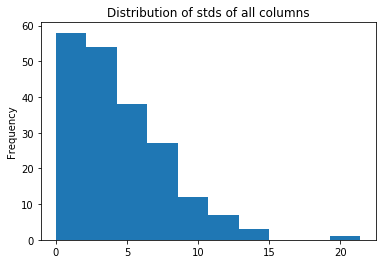

In [8]:
train[train.columns[2:]].std().plot('hist');
plt.title('Distribution of stds of all columns');

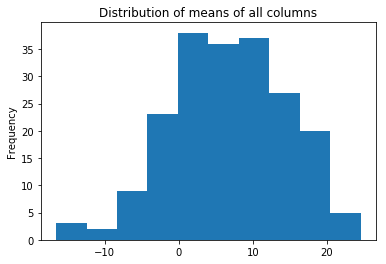

In [9]:
train[train.columns[2:]].mean().plot('hist');
plt.title('Distribution of means of all columns');

Distributions of first 28 columns


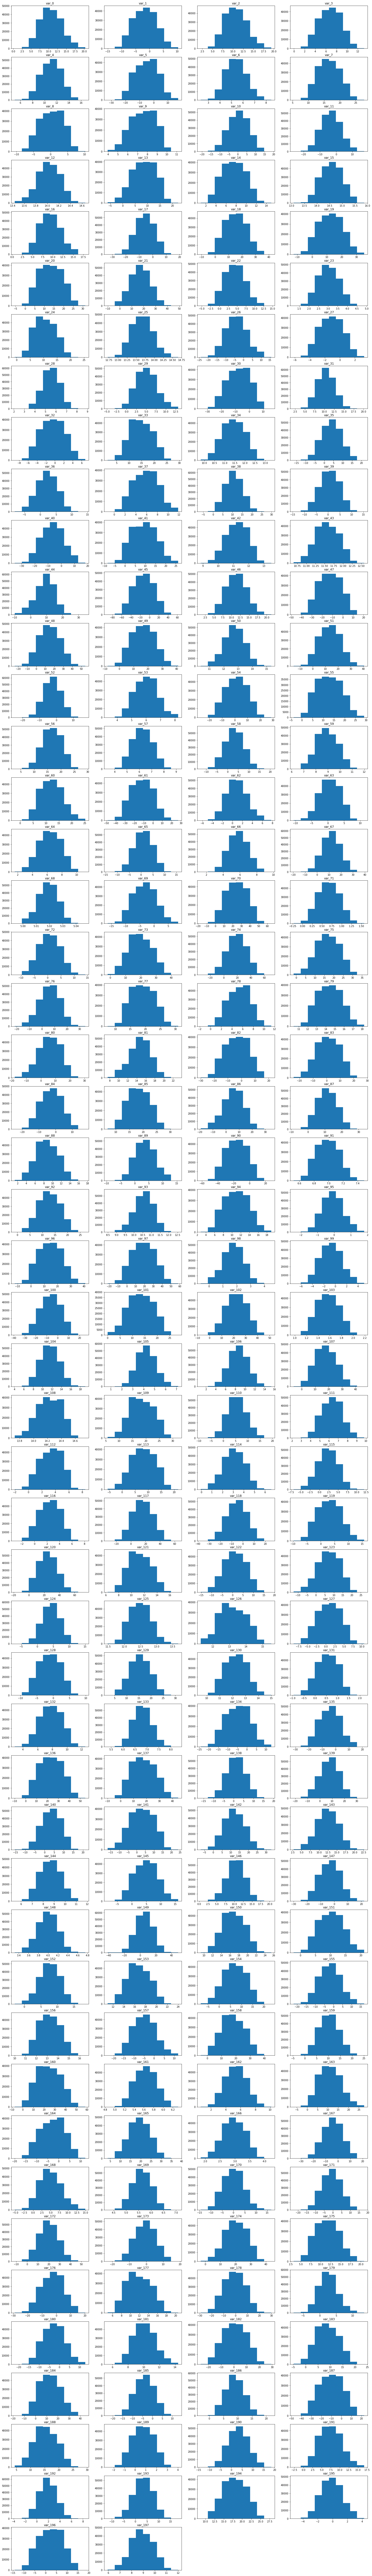

In [14]:
print('Distributions of first 200 columns')
plt.figure(figsize=(26, 192))
for i, col in enumerate(list(train.columns)[2:200]):
    plt.subplot(50, 4, i + 1)
    plt.hist(train[col])
    plt.title(col)

Distributions of first 200 columns


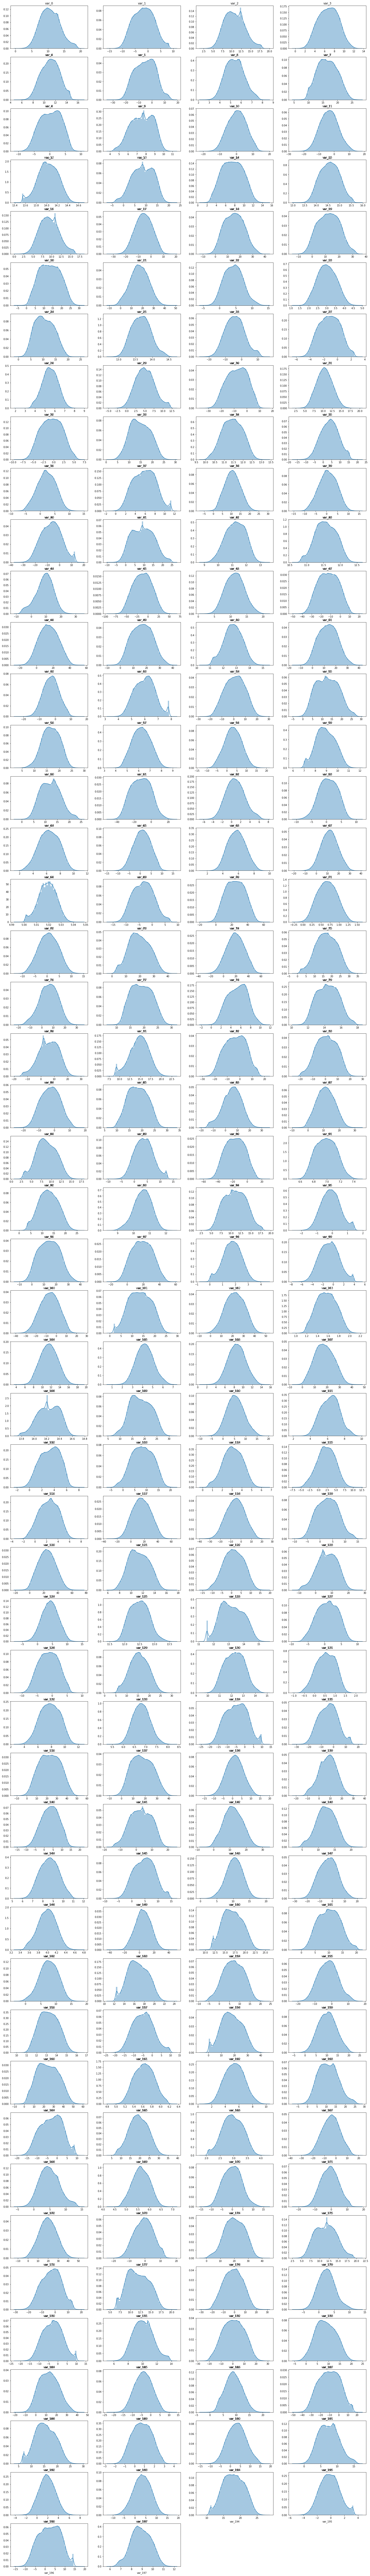

In [16]:
import seaborn as sns
print('Distributions of first 200 columns')
# plt.figure(figsize=(26, 24))
plt.figure(figsize=(26, 192))
for i, col in enumerate(list(train.columns)[2:200]):
    plt.subplot(50, 4, i + 1)
    sns.distplot(train[col])
    plt.title(col)

In [17]:
train['target'].value_counts(normalize=True)

0    0.89951
1    0.10049
Name: target, dtype: float64

In [18]:
# sns.heatmap(train.corr())

In [9]:
X = train.drop(['ID_code', 'target'], axis=1)
y = train['target']
X_test = test.drop(['ID_code'], axis=1)
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)

In [20]:
# Hyperparameters distributions
from scipy.stats import randint
from scipy.stats import uniform

# Model selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import average_precision_score, roc_auc_score, mean_absolute_error
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args # decorator to convert a list of parameters to named arguments
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import VerboseCallback # Callback to control the verbosity
from skopt.callbacks import DeltaXStopper # Stop the optimization If the last two positions at which 
# the objective has been evaluated are less than delta

In [21]:
from time import time
import pprint
import joblib

# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    best_score = optimizer.best_score_
    best_score_std = optimizer.cv_results_['std_test_score'][optimizer.best_index_]
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [40]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',
#                          class_weight='balanced',
                         objective='binary',
                         random_state= 42,
                         bagging_seed = 11,
                         verbosity= -1,
                         n_jobs=-1, 
                         verbose=0)

search_spaces = {
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'num_leaves': Integer(2, 500),
        'max_depth': Integer(0, 500),
        'min_child_samples': Integer(0, 200),
        'max_bin': Integer(100, 100000),
        'subsample': Real(0.01, 1.0, 'uniform'),
        'subsample_freq': Integer(0, 10),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'min_child_weight': Integer(0, 10),
        'subsample_for_bin': Integer(100000, 500000),
        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
        'scale_pos_weight': Real(1e-6, 500, 'log-uniform'),
        'n_estimators': Integer(10, 10000)        
        }

search_spaces = {
    'num_leaves': Integer(2, 500),
    'min_data_in_leaf': Integer(0, 200),
    'max_depth': Integer(0, 500),
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'bagging_freq': Integer(0, 10),
    'feature_fraction': Real(0.01, 1.0, 'uniform'),
    'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
    'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
    'subsample': Real(0.01, 1.0, 'uniform'),
    'min_gain_to_split': Real(0.01, 1.0, 'uniform'),
    'min_child_weight': Integer(0, 30)
}


opt = BayesSearchCV(clf,
                    search_spaces,
                    scoring='roc_auc',
                    cv=folds,
                    n_iter=40,
                    n_jobs=-1,
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=22)
    
best_params = report_perf(opt, X, y,'LightGBM', 
                          callbacks=[DeltaXStopper(0.001), 
                                     DeadlineStopper(60*5)])

LightGBM took 317.50 seconds,  candidates checked: 2, best CV score: 0.873 ± 0.003
Best parameters:
{'bagging_freq': 2,
 'feature_fraction': 0.25739435264644617,
 'learning_rate': 0.2102710733412174,
 'max_depth': 356,
 'min_child_weight': 29,
 'min_data_in_leaf': 40,
 'min_gain_to_split': 0.9391189944320584,
 'num_leaves': 106,
 'reg_alpha': 0.00047706111368021073,
 'reg_lambda': 0.012045158797759246,
 'subsample': 0.6875572440338598}



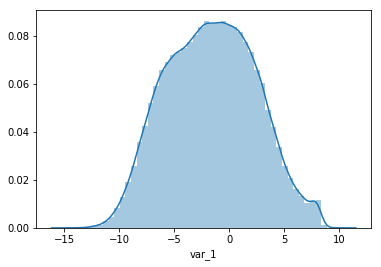

In [50]:
sns.distplot(X1['var_1'])

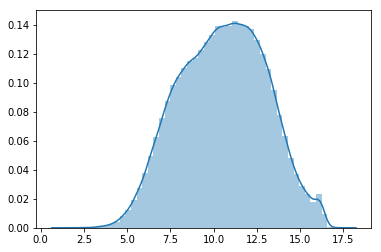

In [54]:
from scipy.stats import boxcox
t, _ = boxcox(X1['var_1']+17.5)
sns.distplot(t)

In [58]:
np.min(X1['var_1'])

-15.0434

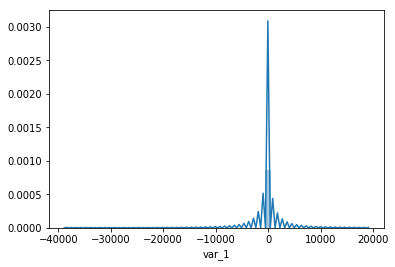

In [61]:
from scipy.stats import boxcox
t = np.tan(X1['var_1']+17.5)
sns.distplot(t)

In [15]:
from scipy.stats import boxcox
from lightgbm import LGBMClassifier
def get_score(X1, col, offset, method="org"):
    
    params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'scale_pos_weight': 8.951238929246692,
         'num_threads': 20}
    
    model = LGBMClassifier(**params)
    seed = 123
    np.random.seed(123)
    X = X1[col].values
    if method == "log":
        X = X1[col].values+offset+1.0
        X = np.log1p(X)
    elif method == "sin":
        X = np.sin(X)
    elif method == "cos":
        X = np.cos(X)
    elif method == "boxcox":
        X = X1[col].values+offset+1.0
        X, _ = boxcox(X)
    elif method == "sqrt":
        X = X1[col].values+offset+1.0
        X = np.sqrt(X)
    elif method == "cbrt":
        X = np.cbrt(X)
    else:
        X = X
    X = X.reshape(-1,1)
    X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=123)
    model.fit(X_train, Y_train)
    preds = model.predict_proba(X_val)[:,1]
    return roc_auc_score(Y_val, preds)

In [16]:
col_method = {}

In [17]:
def check_var(X1, col):
    m = np.min(X1[col])
    offset = 0.0
    if m < 0.0:
        offset = abs(m)+1.0
    methods = ['org', 'log', 'sin', 'cos', 'boxcox', 'sqrt', 'cbrt']
    scores = []
    for method in methods:
        scores.append(get_score(X1, col, offset, method))
    a = np.argmax(scores)
    print(col, a, scores)
    col_method[col] = methods[a]

In [18]:
X = train.drop(['ID_code', 'target'], axis=1)
y = train['target']
X_test = test.drop(['ID_code'], axis=1)
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)
X1 = X.copy()

In [101]:
check_var(X1, 'var_0')

var_0 0 [0.5499358116564833, 0.5499238222438366, 0.499231276894599, 0.5101347275313959, 0.549497898189166, 0.5499238222438366, 0.5499238222438366]


In [19]:
from tqdm import tqdm_notebook
# with LGBM
for col in tqdm_notebook(list(X1.columns)):
    check_var(X1, col)

var_0 0 [0.5495580906298038, 0.5495457910873814, 0.5, 0.5, 0.5495457910873814, 0.5495457910873814, 0.5495457910873814]
var_1 1 [0.5387832450173479, 0.5394657793092661, 0.5, 0.5041118164386162, 0.5394657793092661, 0.5394657793092661, 0.5387828803592599]
var_2 0 [0.5531596652029792, 0.5531596652029792, 0.5059530637328616, 0.5016984512766526, 0.5531596652029792, 0.5531596652029792, 0.5531596652029792]
var_3 1 [0.5094319223394146, 0.5101946916347265, 0.5, 0.5, 0.5101946916347265, 0.5101946916347265, 0.509430862445346]
var_4 0 [0.5078968447021741, 0.507883955572376, 0.5030229916924412, 0.5032652677996173, 0.5078968447021741, 0.507883955572376, 0.507883955572376]
var_5 6 [0.5167716308276494, 0.5146871531807641, 0.5, 0.4979042929288195, 0.5146871531807641, 0.5146871531807641, 0.5167724692004496]
var_6 2 [0.5609198619547616, 0.5609175001972391, 0.5618122143760147, 0.5399158934864399, 0.5609175001972391, 0.5609175001972391, 0.5609175001972391]
var_7 2 [0.5, 0.5, 0.5003010678517942, 0.5, 0.5, 0.

var_67 1 [0.541662258109425, 0.5420533522046734, 0.5, 0.5, 0.5420533522046734, 0.5420533522046734, 0.541651175229969]
var_68 0 [0.5017864020362234, 0.5017864020362234, 0.5017864020362234, 0.5017864020362234, 0.5017864020362234, 0.5017864020362234, 0.5017864020362234]
var_69 0 [0.5031163100827449, 0.5019813680165207, 0.5, 0.5, 0.5019813680165207, 0.5019813680165207, 0.5030750560065407]
var_70 0 [0.5298334245262555, 0.529662454411349, 0.5, 0.49752113270299725, 0.529662454411349, 0.529662454411349, 0.5298189881555986]
var_71 0 [0.5296590497998555, 0.5273218879542017, 0.5296590497998555, 0.5278061061826416, 0.5273218879542017, 0.5273218879542017, 0.5296590497998555]
var_72 1 [0.5007703896269428, 0.5018888198386269, 0.5, 0.5, 0.5018888198386269, 0.5018888198386269, 0.5007703555467478]
var_73 2 [0.5, 0.5, 0.5002056569375094, 0.5, 0.5, 0.5, 0.5]
var_74 4 [0.5135805760609462, 0.5139604134677432, 0.5, 0.5, 0.5139615483382411, 0.5139604134677432, 0.5135801364264291]
var_75 0 [0.534062122402088, 

var_132 0 [0.5280588926219956, 0.5280588926219956, 0.517550615479804, 0.5205603193041642, 0.5280588926219956, 0.5280588926219956, 0.5280588926219956]
var_133 3 [0.5411448559949874, 0.5411448559949874, 0.5399158628142642, 0.5417133749940999, 0.5411448559949874, 0.5411448559949874, 0.5411448559949874]
var_134 1 [0.5125411641896898, 0.5149317058449749, 0.5, 0.5007528996708024, 0.5149317058449749, 0.5149317058449749, 0.5125411641896898]
var_135 1 [0.5172141314892312, 0.5185470760811388, 0.5, 0.5, 0.5185470760811388, 0.5185470760811388, 0.5169957864950753]
var_136 2 [0.4987693641538714, 0.4987722609704574, 0.5, 0.5, 0.4987722609704574, 0.4987722609704574, 0.4987693641538714]
var_137 0 [0.5236824230200813, 0.5232372641032792, 0.5, 0.5001213254946613, 0.5232372641032792, 0.5232372641032792, 0.5236586009636857]
var_138 6 [0.5064122602820375, 0.5063738655342044, 0.5, 0.5014420830087905, 0.5063738655342044, 0.5063738655342044, 0.5064125533717156]
var_139 0 [0.5675203982747925, 0.5669751253767779

var_197 1 [0.5291644950482328, 0.5291658037277258, 0.5151660548987639, 0.5218380437559034, 0.5291644950482328, 0.5291658037277258, 0.5291658037277258]
var_198 0 [0.5417454955780094, 0.5417356055053828, 0.5012312458816215, 0.4973487175878174, 0.5417454955780094, 0.5417356055053828, 0.5417356055053828]
var_199 0 [0.5182564265449958, 0.5177306577426539, 0.49900477650974834, 0.5, 0.5177532086077712, 0.5177306577426539, 0.5182554382193371]


In [20]:
col_method

{'var_0': 'org',
 'var_1': 'log',
 'var_2': 'org',
 'var_3': 'log',
 'var_4': 'org',
 'var_5': 'cbrt',
 'var_6': 'sin',
 'var_7': 'sin',
 'var_8': 'log',
 'var_9': 'org',
 'var_10': 'org',
 'var_11': 'org',
 'var_12': 'cos',
 'var_13': 'log',
 'var_14': 'org',
 'var_15': 'cos',
 'var_16': 'org',
 'var_17': 'org',
 'var_18': 'org',
 'var_19': 'org',
 'var_20': 'cbrt',
 'var_21': 'log',
 'var_22': 'log',
 'var_23': 'log',
 'var_24': 'log',
 'var_25': 'cos',
 'var_26': 'log',
 'var_27': 'org',
 'var_28': 'log',
 'var_29': 'log',
 'var_30': 'org',
 'var_31': 'log',
 'var_32': 'log',
 'var_33': 'org',
 'var_34': 'cos',
 'var_35': 'cbrt',
 'var_36': 'boxcox',
 'var_37': 'log',
 'var_38': 'org',
 'var_39': 'org',
 'var_40': 'log',
 'var_41': 'cos',
 'var_42': 'log',
 'var_43': 'sin',
 'var_44': 'org',
 'var_45': 'log',
 'var_46': 'org',
 'var_47': 'log',
 'var_48': 'org',
 'var_49': 'org',
 'var_50': 'sin',
 'var_51': 'log',
 'var_52': 'org',
 'var_53': 'org',
 'var_54': 'log',
 'var_55': 'lo

In [103]:
col_method

{'var_0': 'org',
 'var_1': 'org',
 'var_2': 'org',
 'var_3': 'boxcox',
 'var_4': 'org',
 'var_5': 'org',
 'var_6': 'org',
 'var_7': 'cos',
 'var_8': 'boxcox',
 'var_9': 'org',
 'var_10': 'cos',
 'var_11': 'log',
 'var_12': 'cos',
 'var_13': 'org',
 'var_14': 'log',
 'var_15': 'cos',
 'var_16': 'boxcox',
 'var_17': 'log',
 'var_18': 'log',
 'var_19': 'boxcox',
 'var_20': 'org',
 'var_21': 'log',
 'var_22': 'boxcox',
 'var_23': 'log',
 'var_24': 'boxcox',
 'var_25': 'cos',
 'var_26': 'org',
 'var_27': 'log',
 'var_28': 'log',
 'var_29': 'cos',
 'var_30': 'cos',
 'var_31': 'log',
 'var_32': 'boxcox',
 'var_33': 'org',
 'var_34': 'cos',
 'var_35': 'log',
 'var_36': 'log',
 'var_37': 'boxcox',
 'var_38': 'org',
 'var_39': 'boxcox',
 'var_40': 'org',
 'var_41': 'sin',
 'var_42': 'log',
 'var_43': 'cos',
 'var_44': 'boxcox',
 'var_45': 'org',
 'var_46': 'sin',
 'var_47': 'log',
 'var_48': 'boxcox',
 'var_49': 'log',
 'var_50': 'log',
 'var_51': 'org',
 'var_52': 'boxcox',
 'var_53': 'sin',
 '

In [15]:
col_method = {'var_0': 'org',
 'var_1': 'org',
 'var_2': 'org',
 'var_3': 'boxcox',
 'var_4': 'org',
 'var_5': 'org',
 'var_6': 'org',
 'var_7': 'cos',
 'var_8': 'boxcox',
 'var_9': 'org',
 'var_10': 'cos',
 'var_11': 'log',
 'var_12': 'cos',
 'var_13': 'org',
 'var_14': 'log',
 'var_15': 'cos',
 'var_16': 'boxcox',
 'var_17': 'log',
 'var_18': 'log',
 'var_19': 'boxcox',
 'var_20': 'org',
 'var_21': 'log',
 'var_22': 'boxcox',
 'var_23': 'log',
 'var_24': 'boxcox',
 'var_25': 'cos',
 'var_26': 'org',
 'var_27': 'log',
 'var_28': 'log',
 'var_29': 'cos',
 'var_30': 'cos',
 'var_31': 'log',
 'var_32': 'boxcox',
 'var_33': 'org',
 'var_34': 'cos',
 'var_35': 'log',
 'var_36': 'log',
 'var_37': 'boxcox',
 'var_38': 'org',
 'var_39': 'boxcox',
 'var_40': 'org',
 'var_41': 'sin',
 'var_42': 'log',
 'var_43': 'cos',
 'var_44': 'boxcox',
 'var_45': 'org',
 'var_46': 'sin',
 'var_47': 'log',
 'var_48': 'boxcox',
 'var_49': 'log',
 'var_50': 'log',
 'var_51': 'org',
 'var_52': 'boxcox',
 'var_53': 'sin',
 'var_54': 'log',
 'var_55': 'org',
 'var_56': 'org',
 'var_57': 'org',
 'var_58': 'log',
 'var_59': 'cos',
 'var_60': 'boxcox',
 'var_61': 'org',
 'var_62': 'cos',
 'var_63': 'boxcox',
 'var_64': 'org',
 'var_65': 'log',
 'var_66': 'sin',
 'var_67': 'org',
 'var_68': 'org',
 'var_69': 'org',
 'var_70': 'org',
 'var_71': 'sin',
 'var_72': 'log',
 'var_73': 'org',
 'var_74': 'org',
 'var_75': 'log',
 'var_76': 'boxcox',
 'var_77': 'org',
 'var_78': 'boxcox',
 'var_79': 'sin',
 'var_80': 'boxcox',
 'var_81': 'org',
 'var_82': 'log',
 'var_83': 'boxcox',
 'var_84': 'log',
 'var_85': 'log',
 'var_86': 'log',
 'var_87': 'log',
 'var_88': 'log',
 'var_89': 'org',
 'var_90': 'log',
 'var_91': 'cos',
 'var_92': 'log',
 'var_93': 'sin',
 'var_94': 'org',
 'var_95': 'log',
 'var_96': 'cos',
 'var_97': 'log',
 'var_98': 'cos',
 'var_99': 'boxcox',
 'var_100': 'sin',
 'var_101': 'log',
 'var_102': 'log',
 'var_103': 'boxcox',
 'var_104': 'log',
 'var_105': 'boxcox',
 'var_106': 'boxcox',
 'var_107': 'log',
 'var_108': 'org',
 'var_109': 'log',
 'var_110': 'org',
 'var_111': 'org',
 'var_112': 'log',
 'var_113': 'log',
 'var_114': 'log',
 'var_115': 'log',
 'var_116': 'log',
 'var_117': 'log',
 'var_118': 'org',
 'var_119': 'boxcox',
 'var_120': 'cos',
 'var_121': 'org',
 'var_122': 'log',
 'var_123': 'boxcox',
 'var_124': 'log',
 'var_125': 'org',
 'var_126': 'sin',
 'var_127': 'org',
 'var_128': 'log',
 'var_129': 'org',
 'var_130': 'sin',
 'var_131': 'sin',
 'var_132': 'org',
 'var_133': 'cos',
 'var_134': 'log',
 'var_135': 'boxcox',
 'var_136': 'sin',
 'var_137': 'log',
 'var_138': 'org',
 'var_139': 'log',
 'var_140': 'org',
 'var_141': 'org',
 'var_142': 'org',
 'var_143': 'cos',
 'var_144': 'org',
 'var_145': 'boxcox',
 'var_146': 'log',
 'var_147': 'boxcox',
 'var_148': 'org',
 'var_149': 'log',
 'var_150': 'log',
 'var_151': 'org',
 'var_152': 'log',
 'var_153': 'cos',
 'var_154': 'log',
 'var_155': 'org',
 'var_156': 'org',
 'var_157': 'log',
 'var_158': 'sin',
 'var_159': 'cos',
 'var_160': 'cos',
 'var_161': 'org',
 'var_162': 'boxcox',
 'var_163': 'log',
 'var_164': 'org',
 'var_165': 'log',
 'var_166': 'sin',
 'var_167': 'org',
 'var_168': 'log',
 'var_169': 'cos',
 'var_170': 'org',
 'var_171': 'sin',
 'var_172': 'org',
 'var_173': 'log',
 'var_174': 'org',
 'var_175': 'org',
 'var_176': 'sin',
 'var_177': 'org',
 'var_178': 'boxcox',
 'var_179': 'log',
 'var_180': 'boxcox',
 'var_181': 'log',
 'var_182': 'sin',
 'var_183': 'cos',
 'var_184': 'log',
 'var_185': 'sin',
 'var_186': 'boxcox',
 'var_187': 'org',
 'var_188': 'log',
 'var_189': 'boxcox',
 'var_190': 'org',
 'var_191': 'org',
 'var_192': 'boxcox',
 'var_193': 'org',
 'var_194': 'org',
 'var_195': 'boxcox',
 'var_196': 'org',
 'var_197': 'org',
 'var_198': 'org',
 'var_199': 'boxcox'}



In [21]:
from scipy.stats import boxcox
def transform_var(X1, col):
    m = np.min(X1[col])
    offset = 0.0
    if m < 0.0:
        offset = abs(m)
    method = col_method[col]
    X = X1[col].values
    if method == "log":
        X = X1[col].values+offset+1.0
        X = np.log1p(X)
    elif method == "sin":
        X = np.sin(X)
    elif method == "cos":
        X = np.cos(X)
    elif method == "boxcox":
        X = X1[col].values+offset+1.0
        X, _ = boxcox(X)
    elif method == "sqrt":
        X = X1[col].values+offset+1.0
        X = np.sqrt(X)
    elif method == "cbrt":
        X = np.cbrt(X)
    else:
        X = X
    X1[col] = X
    
    return X1

In [24]:
from tqdm import tqdm, tqdm_notebook
X = train.drop(['ID_code', 'target'], axis=1)
y = train['target']
X_test = test.drop(['ID_code'], axis=1)
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)
X1 = X.copy()
X2 = X_test.copy()

for col in tqdm(list(X1.columns)):
    X1 = transform_var(X1, col)
    X2 = transform_var(X2, col)
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X1 = sc.fit_transform(X1)
# X2 = sc.transform(X2)

100%|██████████| 200/200 [00:06<00:00, 29.97it/s]


In [25]:
from time import ctime
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
#         X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 1000)
            
#             model = lgb.LGBMClassifier(max_depth=-1,
#                                n_estimators=999999,
#                                learning_rate=0.02,
#                                colsample_bytree=0.3,
#                                num_leaves=2,
#                                metric='auc',
#                                objective='binary', 
#                                n_jobs=-1)
#             model.fit(X_train, y_train, 
#                       eval_set=[(X_valid, y_valid)],
#                       verbose=1000, 
#                       early_stopping_rounds=1000)
            y_pred_valid = model.predict(X_valid)
#             y_pred_valid = model.predict_proba(X_valid)[:,1]
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
#             y_pred = model.predict_proba(X_test)[:,1]
        if model_type == 'xgb':
#             print('1')
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)
#             print('2')
            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
#             print('2a')
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
#             print('3')
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if (model_type == 'lgb') & (plot_feature_importance):
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if (model_type == 'lgb') & (plot_feature_importance):
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores


In [117]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 20}


oof_lgb, prediction_lgb, scores = train_model(X1, X2, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=False)

Fold 0 started at Sun Feb 24 21:38:46 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884535	valid_1's auc: 0.864263
[2000]	training's auc: 0.909577	valid_1's auc: 0.883308
[3000]	training's auc: 0.920957	valid_1's auc: 0.890598
[4000]	training's auc: 0.927629	valid_1's auc: 0.894363
[5000]	training's auc: 0.93236	valid_1's auc: 0.896387
[6000]	training's auc: 0.936436	valid_1's auc: 0.897252
Early stopping, best iteration is:
[6620]	training's auc: 0.938908	valid_1's auc: 0.897488
Fold 1 started at Sun Feb 24 22:25:02 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884972	valid_1's auc: 0.865009
[2000]	training's auc: 0.909725	valid_1's auc: 0.883511
[3000]	training's auc: 0.921193	valid_1's auc: 0.891021
[4000]	training's auc: 0.927872	valid_1's auc: 0.89471
[5000]	training's auc: 0.932448	valid_1's auc: 0.896543
[6000]	training's auc: 0.936411	valid_1's auc: 0.897459
[7000]	training's auc: 0.94

In [8]:
# sample_pos_weight = number of negative samples / number of positive samples
sample_pos_weight = 179902/ 20098

# 'scale_pos_weight': sample_pos_weight,
sample_pos_weight

8.951238929246692

In [118]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb
sub.to_csv('../submissions/sub5a.csv', index=False)

In [26]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'scale_pos_weight': 8.951238929246692,
         'num_threads': 20}


oof_lgb, prediction_lgb, scores = train_model(X1, X2, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=False)

Fold 0 started at Wed Feb 27 11:28:26 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.888188	valid_1's auc: 0.865433
[2000]	training's auc: 0.913179	valid_1's auc: 0.883297
[3000]	training's auc: 0.925119	valid_1's auc: 0.890136
[4000]	training's auc: 0.932459	valid_1's auc: 0.893885
[5000]	training's auc: 0.937803	valid_1's auc: 0.895542
[6000]	training's auc: 0.942905	valid_1's auc: 0.896172
[7000]	training's auc: 0.947871	valid_1's auc: 0.896363
[8000]	training's auc: 0.952599	valid_1's auc: 0.896491
[9000]	training's auc: 0.95691	valid_1's auc: 0.896589
[10000]	training's auc: 0.960958	valid_1's auc: 0.896542
Early stopping, best iteration is:
[9019]	training's auc: 0.956985	valid_1's auc: 0.896612
Fold 1 started at Wed Feb 27 11:33:37 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.888394	valid_1's auc: 0.865402
[2000]	training's auc: 0.913389	valid_1's auc: 0.883334
[3000]	training's auc: 

In [133]:
oof_lgb, prediction_lgb, scores = train_model(X1, X2, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=False)

Fold 0 started at Mon Feb 25 02:56:07 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	valid_0's auc: 0.825744
[2000]	valid_0's auc: 0.85429
[3000]	valid_0's auc: 0.867881
[4000]	valid_0's auc: 0.875929
[5000]	valid_0's auc: 0.881088
[6000]	valid_0's auc: 0.884787
[7000]	valid_0's auc: 0.887461
[8000]	valid_0's auc: 0.889618
[9000]	valid_0's auc: 0.891366
[10000]	valid_0's auc: 0.892719
[11000]	valid_0's auc: 0.893776
[12000]	valid_0's auc: 0.894667
[13000]	valid_0's auc: 0.895371
[14000]	valid_0's auc: 0.895953
[15000]	valid_0's auc: 0.896434
[16000]	valid_0's auc: 0.896817
[17000]	valid_0's auc: 0.897117
[18000]	valid_0's auc: 0.89735
[19000]	valid_0's auc: 0.897567
[20000]	valid_0's auc: 0.897705
[21000]	valid_0's auc: 0.897835
[22000]	valid_0's auc: 0.89792
[23000]	valid_0's auc: 0.898013
[24000]	valid_0's auc: 0.89805
[25000]	valid_0's auc: 0.898073
[26000]	valid_0's auc: 0.898097
[27000]	valid_0's auc: 0.89811
Early stopping, best iteration is:
[26577]	

In [187]:
oof_lgb, prediction_lgb, scores = train_model(X1, X2, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=False)

Fold 0 started at Mon Feb 25 04:46:21 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	valid_0's auc: 0.825106
[2000]	valid_0's auc: 0.854305
[3000]	valid_0's auc: 0.86791
[4000]	valid_0's auc: 0.875957
[5000]	valid_0's auc: 0.881121
[6000]	valid_0's auc: 0.884825
[7000]	valid_0's auc: 0.8875
[8000]	valid_0's auc: 0.889696
[9000]	valid_0's auc: 0.891365
[10000]	valid_0's auc: 0.892759
[11000]	valid_0's auc: 0.89382
[12000]	valid_0's auc: 0.894693
[13000]	valid_0's auc: 0.895392
[14000]	valid_0's auc: 0.895956
[15000]	valid_0's auc: 0.896414
[16000]	valid_0's auc: 0.896803
[17000]	valid_0's auc: 0.897099
[18000]	valid_0's auc: 0.897355
[19000]	valid_0's auc: 0.897541
[20000]	valid_0's auc: 0.897718
[21000]	valid_0's auc: 0.897818
[22000]	valid_0's auc: 0.897908
[23000]	valid_0's auc: 0.897984
[24000]	valid_0's auc: 0.898031
[25000]	valid_0's auc: 0.898053
[26000]	valid_0's auc: 0.89807
[27000]	valid_0's auc: 0.89809
Early stopping, best iteration is:
[26632]	v

In [161]:
oof_lgb, prediction_lgb, scores = train_model(X, X, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=False)

Fold 0 started at Mon Feb 25 04:18:31 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	valid_0's auc: 0.796435
[2000]	valid_0's auc: 0.822278
[3000]	valid_0's auc: 0.835726
[4000]	valid_0's auc: 0.843774
[5000]	valid_0's auc: 0.849163
[6000]	valid_0's auc: 0.853048
[7000]	valid_0's auc: 0.856126
[8000]	valid_0's auc: 0.858639
[9000]	valid_0's auc: 0.860726
[10000]	valid_0's auc: 0.862365
[11000]	valid_0's auc: 0.863759
[12000]	valid_0's auc: 0.86503
[13000]	valid_0's auc: 0.866139
[14000]	valid_0's auc: 0.867089
[15000]	valid_0's auc: 0.867967
[16000]	valid_0's auc: 0.868717
[17000]	valid_0's auc: 0.869418
[18000]	valid_0's auc: 0.87003
[19000]	valid_0's auc: 0.870598
[20000]	valid_0's auc: 0.871087
[21000]	valid_0's auc: 0.871584
[22000]	valid_0's auc: 0.871992
[23000]	valid_0's auc: 0.872372
[24000]	valid_0's auc: 0.87276
[25000]	valid_0's auc: 0.873104
[26000]	valid_0's auc: 0.873398
[27000]	valid_0's auc: 0.873676
[28000]	valid_0's auc: 0.873929
[29000]	v

KeyboardInterrupt: 

In [194]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 20}

oof_lgb, prediction_lgb, scores = train_model(X1, X2, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=False)

Fold 0 started at Mon Feb 25 05:34:01 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.884535	valid_1's auc: 0.864263
[2000]	training's auc: 0.909577	valid_1's auc: 0.883308
[3000]	training's auc: 0.920957	valid_1's auc: 0.890598
[4000]	training's auc: 0.927629	valid_1's auc: 0.894363
[5000]	training's auc: 0.93236	valid_1's auc: 0.896387
[6000]	training's auc: 0.936436	valid_1's auc: 0.897252
[7000]	training's auc: 0.94037	valid_1's auc: 0.897524
[8000]	training's auc: 0.944199	valid_1's auc: 0.897564
Early stopping, best iteration is:
[7870]	training's auc: 0.943734	valid_1's auc: 0.897625
Fold 1 started at Mon Feb 25 05:41:25 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.884972	valid_1's auc: 0.865009
[2000]	training's auc: 0.909725	valid_1's auc: 0.883511
[3000]	training's auc: 0.921193	valid_1's auc: 0.891021
[4000]	training's auc: 0.927872	valid_1's auc: 0.89471
[5000]	training's auc: 0.9

In [ ]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'scale_pos_weight': sample_pos_weight,
         'num_threads': 20}


oof_lgb, prediction_lgb, scores = train_model(X1, X2, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=False)

In [195]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 20}

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=False)

Fold 0 started at Mon Feb 25 12:10:16 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.884603	valid_1's auc: 0.86399
[2000]	training's auc: 0.90957	valid_1's auc: 0.883048
[3000]	training's auc: 0.9212	valid_1's auc: 0.890413
[4000]	training's auc: 0.928037	valid_1's auc: 0.894272
[5000]	training's auc: 0.932884	valid_1's auc: 0.89641
[6000]	training's auc: 0.936977	valid_1's auc: 0.897365
[7000]	training's auc: 0.940931	valid_1's auc: 0.897683
[8000]	training's auc: 0.944699	valid_1's auc: 0.897866
[9000]	training's auc: 0.948278	valid_1's auc: 0.897837
Early stopping, best iteration is:
[8300]	training's auc: 0.945744	valid_1's auc: 0.897903
Fold 1 started at Mon Feb 25 12:14:54 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.885138	valid_1's auc: 0.86556
[2000]	training's auc: 0.909804	valid_1's auc: 0.884064
[3000]	training's auc: 0.921293	valid_1's auc: 0.891299
[4000]	training's auc: 0.9281

In [134]:
# CV mean score: 0.8990, std: 0.0031.
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb
sub.to_csv('../submissions/sub5b.csv', index=False)

In [ ]:
# CV mean score: 0.8989, std: 0.0031. (TBD)
# sub = pd.read_csv('../data/sample_submission.csv.zip')
# sub['target'] = prediction_lgb
# sub.to_csv('../submissions/sub5c.csv', index=False)

In [16]:
from sklearn.preprocessing import PolynomialFeatures
p = PolynomialFeatures()
X1 = pd.concat([X,X_test], axis=0)
print(X1.shape)
X1 = p.fit_transform(X1)
X = X1[:len(X)]
X_test = X1[len(X):]

(400000, 200)


In [17]:
X.shape, X_test.shape

((200000, 20301), (200000, 20301))

In [ ]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 20}


oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=False)

Fold 0 started at Sun Feb 24 13:09:40 2019


Fold 0 started at Tue Feb 19 15:24:30 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.885014	valid_1's auc: 0.864492
[2000]	training's auc: 0.909721	valid_1's auc: 0.882867
[3000]	training's auc: 0.921202	valid_1's auc: 0.89042
[4000]	training's auc: 0.928088	valid_1's auc: 0.89445
[5000]	training's auc: 0.932895	valid_1's auc: 0.896647
[6000]	training's auc: 0.936977	valid_1's auc: 0.897681
[7000]	training's auc: 0.940894	valid_1's auc: 0.898105
[8000]	training's auc: 0.944607	valid_1's auc: 0.898296
Early stopping, best iteration is:
[8530]	training's auc: 0.946556	valid_1's auc: 0.898392
Fold 1 started at Tue Feb 19 15:31:00 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884713	valid_1's auc: 0.864687
[2000]	training's auc: 0.90936	valid_1's auc: 0.883356
[3000]	training's auc: 0.921266	valid_1's auc: 0.891113
[4000]	training's auc: 0.928168	valid_1's auc: 0.895326
[5000]	training's auc: 0.932

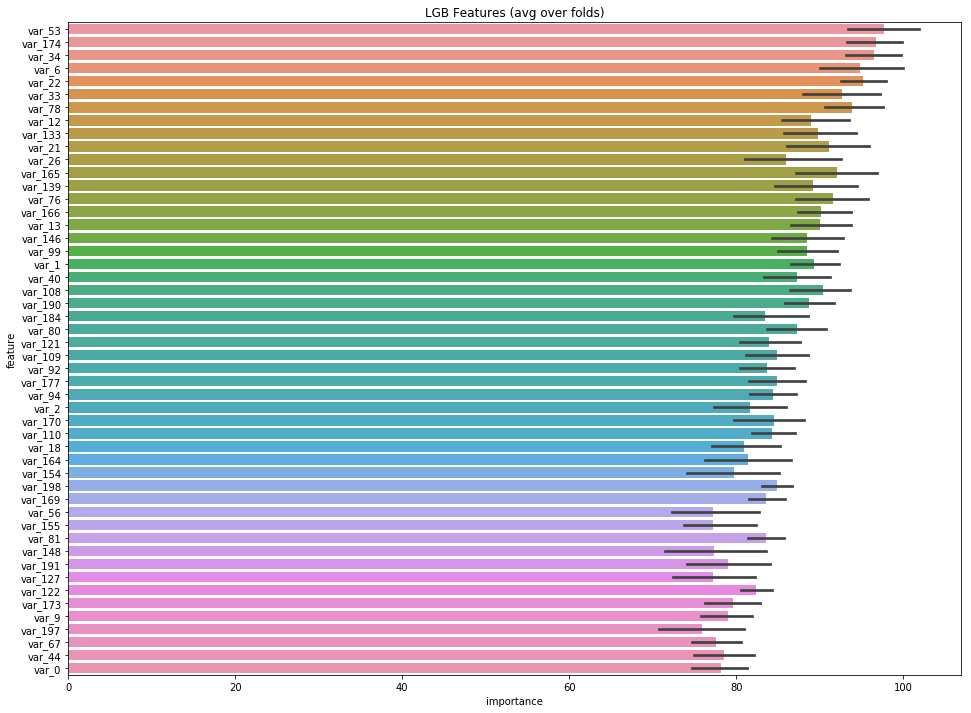

In [41]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}

params = {
    'colsample_bytree': 0.3706219857878677,
    'learning_rate': 0.16624226726409647,
    'max_bin': 93400,
    'max_depth': 134,
    'min_child_samples': 22,
    'min_child_weight': 4,
    'n_estimators': 8028,
    'num_leaves': 27,
    'reg_alpha': 1.081049236893711e-05,
    'reg_lambda': 1.043686239159047,
    'scale_pos_weight': 0.19222548462579486,
    'subsample': 0.6941640075502717,
    'subsample_for_bin': 375140,
    'subsample_freq': 7,
}

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [19]:
np.save('../cache/oof_lgb', oof_lgb)
np.save('../cache/prediction_lgb', prediction_lgb)
np.save('../cache/scores', scores)

In [27]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb
sub.to_csv('../submissions/sub1a.csv', index=False)

In [ ]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f ../submissions/sub1a.csv -m " "

In [ ]:
!kaggle competitions submissions -c santander-customer-transaction-prediction

Fold 0 started at Tue Feb 19 13:21:10 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.866485	valid_1's auc: 0.84906
[2000]	training's auc: 0.895269	valid_1's auc: 0.872443
[3000]	training's auc: 0.908978	valid_1's auc: 0.882687
[4000]	training's auc: 0.91745	valid_1's auc: 0.888379
[5000]	training's auc: 0.92327	valid_1's auc: 0.892014
[6000]	training's auc: 0.927657	valid_1's auc: 0.894364
[7000]	training's auc: 0.93108	valid_1's auc: 0.896081
[8000]	training's auc: 0.933934	valid_1's auc: 0.897067
[9000]	training's auc: 0.936585	valid_1's auc: 0.897746
[10000]	training's auc: 0.939144	valid_1's auc: 0.898183
[11000]	training's auc: 0.941678	valid_1's auc: 0.898428
Early stopping, best iteration is:
[10897]	training's auc: 0.941448	valid_1's auc: 0.898463
Fold 1 started at Tue Feb 19 13:30:07 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.866744	valid_1's auc: 0.849655
[2000]	training's auc: 0.8

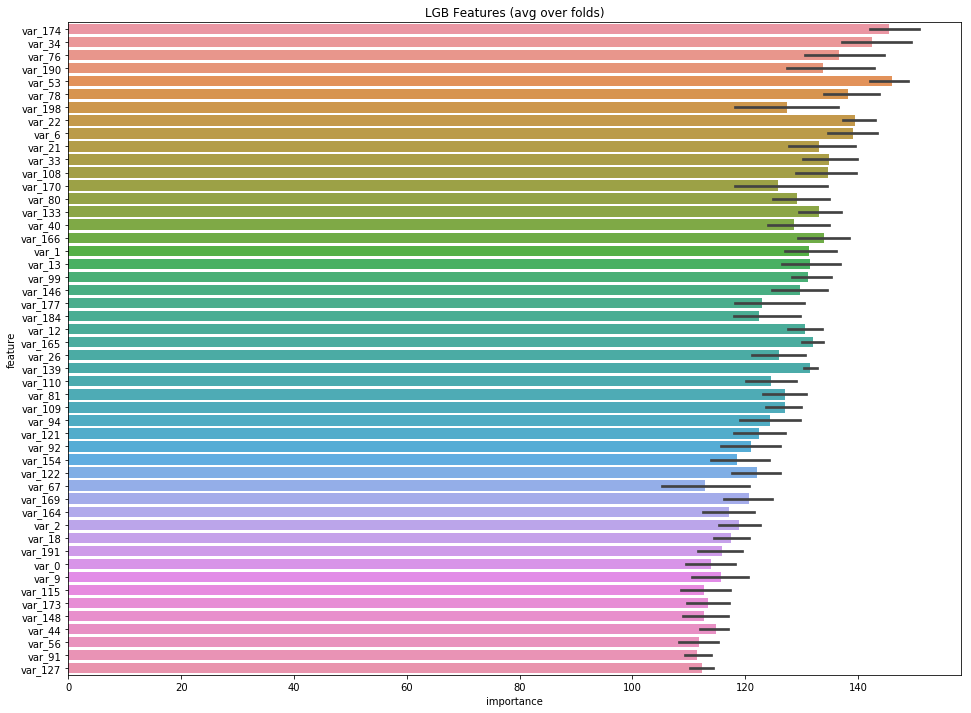

In [23]:
best = {'bagging_freq': 14, 'feature_fraction': 0.6645452259093495, 'learning_rate': 0.9104709179139949, 'max_depth': 18, 
        'min_child_weight': 0.1936027500260209, 'min_data_in_leaf': 6, 'min_gain_to_split': 0.3165755403433436, 
        'num_leaves': 1788, 'reg_alpha': 0.1962993164404836, 'metric': 'auc', 'boosting': 'gbdt',
         'verbosity': -1,
        'reg_lambda': 0.12729980022303397, 'subsample': 0.6191170180441716}
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.008,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}
oof_lgb1, prediction_lgb1, scores1 = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [24]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb1
sub.to_csv('../submissions/sub1b.csv', index=False)

In [21]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}

In [42]:
model = lgb.LGBMClassifier(**params, n_estimators = 20000, n_jobs = -1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884796	valid_1's auc: 0.863996
[2000]	training's auc: 0.909754	valid_1's auc: 0.883341
[3000]	training's auc: 0.921236	valid_1's auc: 0.891485
[4000]	training's auc: 0.928121	valid_1's auc: 0.895495
[5000]	training's auc: 0.932972	valid_1's auc: 0.897463
[6000]	training's auc: 0.936911	valid_1's auc: 0.898596
[7000]	training's auc: 0.94072	valid_1's auc: 0.899005
Early stopping, best iteration is:
[7641]	training's auc: 0.943127	valid_1's auc: 0.899255


LGBMClassifier(bagging_freq=5, bagging_seed=11, boosting='gbdt',
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.8201, importance_type='split',
        learning_rate=0.0123, max_depth=16, metric='auc',
        min_child_samples=20, min_child_weight=19.428902804238373,
        min_data_in_leaf=42, min_gain_to_split=0.01077313523861969,
        min_split_gain=0.0, n_estimators=20000, n_jobs=-1, num_leaves=8,
        num_threads=4, objective='binary', random_state=42,
        reg_alpha=1.728910519108444, reg_lambda=4.9847051755586085,
        silent=True, subsample=0.81, subsample_for_bin=200000,
        subsample_freq=0, verbosity=-1)

In [43]:
eli5.show_weights(model, targets=[0, 1], feature_names=list(X_train.columns), top=40, feature_filter=lambda x: x != '<BIAS>')

In [44]:
eli5.show_weights(model, targets=[0, 1], feature_names=list(X_train.columns), top=120, feature_filter=lambda x: x != '<BIAS>')

In [45]:
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:100]
X1 = X[top_features]
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.883739	valid_1's auc: 0.863615
[2000]	training's auc: 0.904231	valid_1's auc: 0.881132
[3000]	training's auc: 0.912039	valid_1's auc: 0.887247
[4000]	training's auc: 0.916339	valid_1's auc: 0.889774
[5000]	training's auc: 0.919738	valid_1's auc: 0.890673
[6000]	training's auc: 0.923393	valid_1's auc: 0.890992
[7000]	training's auc: 0.927153	valid_1's auc: 0.89109
Early stopping, best iteration is:
[6822]	training's auc: 0.926471	valid_1's auc: 0.891122


LGBMClassifier(bagging_freq=5, bagging_seed=11, boosting='gbdt',
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.8201, importance_type='split',
        learning_rate=0.0123, max_depth=16, metric='auc',
        min_child_samples=20, min_child_weight=19.428902804238373,
        min_data_in_leaf=42, min_gain_to_split=0.01077313523861969,
        min_split_gain=0.0, n_estimators=20000, n_jobs=-1, num_leaves=8,
        num_threads=4, objective='binary', random_state=42,
        reg_alpha=1.728910519108444, reg_lambda=4.9847051755586085,
        silent=True, subsample=0.81, subsample_for_bin=200000,
        subsample_freq=0, verbosity=-1)

In [46]:
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:110]
X1 = X[top_features]
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, stratify=y)
model = lgb.LGBMClassifier(**params, n_estimators = 20000, n_jobs = -1)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884874	valid_1's auc: 0.863816
[2000]	training's auc: 0.905387	valid_1's auc: 0.878726
[3000]	training's auc: 0.913169	valid_1's auc: 0.883672
[4000]	training's auc: 0.917501	valid_1's auc: 0.885457
[5000]	training's auc: 0.920693	valid_1's auc: 0.886076
Early stopping, best iteration is:
[5468]	training's auc: 0.922375	valid_1's auc: 0.886293


LGBMClassifier(bagging_freq=5, bagging_seed=11, boosting='gbdt',
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.8201, importance_type='split',
        learning_rate=0.0123, max_depth=16, metric='auc',
        min_child_samples=20, min_child_weight=19.428902804238373,
        min_data_in_leaf=42, min_gain_to_split=0.01077313523861969,
        min_split_gain=0.0, n_estimators=20000, n_jobs=-1, num_leaves=8,
        num_threads=4, objective='binary', random_state=42,
        reg_alpha=1.728910519108444, reg_lambda=4.9847051755586085,
        silent=True, subsample=0.81, subsample_for_bin=200000,
        subsample_freq=0, verbosity=-1)

In [51]:
X = train.drop(['ID_code', 'target'], axis=1)
X_test = test.drop(['ID_code'], axis=1)


In [52]:
columns = top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:30]
for col1 in tqdm_notebook(columns):
    for col2 in columns:
        X[col1 + '_' + col2] = X[col1] * X[col2]   
        X_test[col1 + '_' + col2] = X_test[col1] * X_test[col2]
        
        X[col1 + '__' + col2] = X[col1] / X[col2]   
        X_test[col1 + '__' + col2] = X_test[col1] / X_test[col2]

In [53]:
oof_lgb2, prediction_lgb_inter, scores2 = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)


Fold 0 started at Tue Feb 19 16:17:04 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884054	valid_1's auc: 0.861962
[2000]	training's auc: 0.909109	valid_1's auc: 0.880804
[3000]	training's auc: 0.9208	valid_1's auc: 0.888573
[4000]	training's auc: 0.928138	valid_1's auc: 0.892489
[5000]	training's auc: 0.933742	valid_1's auc: 0.894392
[6000]	training's auc: 0.939031	valid_1's auc: 0.895506
[7000]	training's auc: 0.944003	valid_1's auc: 0.896052
Early stopping, best iteration is:
[7332]	training's auc: 0.945604	valid_1's auc: 0.896094
Fold 1 started at Tue Feb 19 16:54:14 2019
Training until validation scores don't improve for 200 rounds.


KeyboardInterrupt: 

In [17]:
X = train.drop(['ID_code', 'target'], axis=1)
X_test = test.drop(['ID_code'], axis=1)


In [55]:
columns = top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:10]
for col1 in tqdm_notebook(columns):
    for col2 in columns:
        X[col1 + '_' + col2] = X[col1] * X[col2]   
        X_test[col1 + '_' + col2] = X_test[col1] * X_test[col2]
        
        X[col1 + '__' + col2] = X[col1] / X[col2]   
        X_test[col1 + '__' + col2] = X_test[col1] / X_test[col2]

Fold 0 started at Tue Feb 19 16:56:44 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.883658	valid_1's auc: 0.86286
[2000]	training's auc: 0.909206	valid_1's auc: 0.882228
[3000]	training's auc: 0.920836	valid_1's auc: 0.890004
[4000]	training's auc: 0.927904	valid_1's auc: 0.893952
[5000]	training's auc: 0.932834	valid_1's auc: 0.896024
[6000]	training's auc: 0.937139	valid_1's auc: 0.897046
[7000]	training's auc: 0.941286	valid_1's auc: 0.897438
[8000]	training's auc: 0.945246	valid_1's auc: 0.897627
Early stopping, best iteration is:
[8320]	training's auc: 0.946518	valid_1's auc: 0.897761
Fold 1 started at Tue Feb 19 17:06:59 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.883323	valid_1's auc: 0.863649
[2000]	training's auc: 0.908523	valid_1's auc: 0.882941
[3000]	training's auc: 0.920697	valid_1's auc: 0.890695
[4000]	training's auc: 0.927751	valid_1's auc: 0.894752
[5000]	training's auc: 0.9

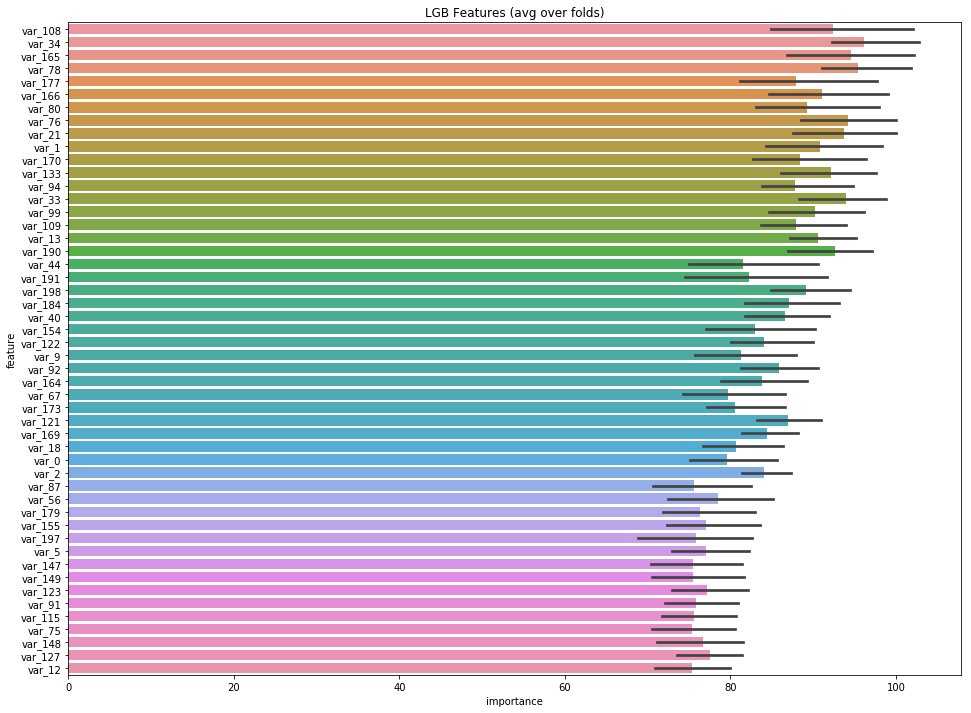

In [56]:
oof_lgb2, prediction_lgb_inter, scores2 = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)


In [57]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb_inter
sub.to_csv('../submissions/sub1c.csv', index=False)

In [16]:

xgb_params = {'eta': 0.05, 'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 
          'objective': 'binary:logistic', 'eval_metric': 'auc', 'silent': True, 'nthread': 4}
oof_xgb, prediction_xgb, scores = train_model(X, X_test, y, params=xgb_params, folds=folds, model_type='xgb')

Fold 0 started at Tue Feb 19 18:43:50 2019
[0]	train-auc:0.608758	valid_data-auc:0.601929
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 200 rounds.
[500]	train-auc:0.907889	valid_data-auc:0.872789
[1000]	train-auc:0.932237	valid_data-auc:0.887631
[1500]	train-auc:0.943743	valid_data-auc:0.893153
[2000]	train-auc:0.951329	valid_data-auc:0.894989
[2500]	train-auc:0.957301	valid_data-auc:0.895685
Stopping. Best iteration:
[2641]	train-auc:0.958613	valid_data-auc:0.895861

Fold 1 started at Tue Feb 19 19:09:56 2019
[0]	train-auc:0.599652	valid_data-auc:0.592425
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 200 rounds.
[500]	train-auc:0.907902	valid_data-auc:0.874244
[1000]	train-auc:0.932342	valid_data-auc:0.889326
[1500]	train-auc:0.943571	valid_data-auc:0.894195
[2000]	train-auc:0.951021	valid_data-

In [17]:
np.save('../cache/oof_xgb', oof_xgb)
np.save('../cache/prediction_xgb', prediction_xgb)
np.save('../cache/scores_xgb', scores)

In [18]:
cat_params = {'depth': 13,
              'l2_leaf_reg': 10,
              'bootstrap_type': 'Bernoulli',
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 50,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat, prediction_cat, _ = train_model(X, X_test, y, params=cat_params, folds=folds, model_type='cat')

Fold 0 started at Tue Feb 19 22:12:22 2019
Fold 1 started at Tue Feb 19 23:40:41 2019
Fold 2 started at Wed Feb 20 00:58:51 2019
Fold 3 started at Wed Feb 20 01:56:55 2019
Fold 4 started at Wed Feb 20 03:01:35 2019
CV mean score: 0.8853, std: 0.0029.


In [19]:
np.save('../cache/oof_cat', oof_cat)
np.save('../cache/prediction_cat', prediction_cat)
# np.save('../cache/scores_xgb', scores)

In [15]:
X = pd.DataFrame()
oof_lgb = np.load('../cache/oof_lgb.npy')
oof_xgb = np.load('../cache/oof_xgb.npy')
oof_cat = np.load('../cache/oof_cat.npy')
X['lgb'] = oof_lgb
X['xgb'] = oof_xgb
X['cat'] = oof_cat

In [16]:
X_test = pd.DataFrame()
prediction_lgb = np.load('../cache/prediction_lgb.npy')
prediction_xgb = np.load('../cache/prediction_xgb.npy')
prediction_cat = np.load('../cache/prediction_cat.npy')
X_test['lgb'] = prediction_lgb
X_test['xgb'] = prediction_xgb
X_test['cat'] = prediction_cat

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=5000)
rf.fit(X,y)
preds = rf.predict(X_test)

In [19]:
preds = rf.predict_proba(X_test)[:,1]

In [20]:
preds

array([0.063 , 0.3526, 0.3106, ..., 0.    , 0.1332, 0.1004])

In [21]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = preds
sub.to_csv('../submissions/sub1d.csv', index=False)

In [22]:
preds1 = np.clip(preds, 0.05, 0.95)

In [23]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = preds1
sub.to_csv('../submissions/sub1e.csv', index=False) 

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=20)
rf.fit(X,y)
preds = rf.predict(X_test)

In [30]:
preds = rf.predict_proba(X_test)[:,1]


In [31]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = preds
sub.to_csv('../submissions/sub1g.csv', index=False) 

In [32]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = (prediction_lgb + prediction_xgb)/2
sub.to_csv('../submissions/sub1h.csv', index=False) 

In [33]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = (prediction_lgb + prediction_xgb + prediction_cat)/3
sub.to_csv('../submissions/sub1i.csv', index=False) 

In [27]:


x = [2.5,0.5,2.2,1.9,3.1,2.3,2,1,1.5,1.1]
y = [2.4,0.7,2.9,2.2,3.0,2.7,1.6,1.1,1.6,0.9]
X = pd.DataFrame()
X['x'] = x
X['y'] = y

In [28]:
X

x    y
0  2.5  2.4
1  0.5  0.7
2  2.2  2.9
3  1.9  2.2
4  3.1  3.0
5  2.3  2.7
6  2.0  1.6
7  1.0  1.1
8  1.5  1.6
9  1.1  0.9

In [29]:
X1= X-X.mean()

In [30]:
X1

x     y
0  0.69  0.49
1 -1.31 -1.21
2  0.39  0.99
3  0.09  0.29
4  1.29  1.09
5  0.49  0.79
6  0.19 -0.31
7 -0.81 -0.81
8 -0.31 -0.31
9 -0.71 -1.01

In [35]:
np.cov(X1.T).shape

(2, 2)

In [51]:
np.cov(X1.T)

array([[0.61655556, 0.61544444],
       [0.61544444, 0.71655556]])

In [34]:
??np.cov

In [36]:
np.linalg.eig(np.cov(X1.T))

(array([0.0490834 , 1.28402771]), array([[-0.73517866, -0.6778734 ],
        [ 0.6778734 , -0.73517866]]))

In [38]:
e_val, e_vec = np.linalg.eig(np.cov(X1.T))

In [37]:
np.cov(X1.T)

array([[0.61655556, 0.61544444],
       [0.61544444, 0.71655556]])

In [ ]:
-.827970186 
1.77758033
-.992197494 
-.274210416
-1.67580142 
-.912949103
.0991094375 
1.14457216
.438046137 
1.22382056

-.175115307 
.142857227
.384374989 
.130417207
-.209498461 
.175282444
-.349824698 
.0464172582
.0177646297 
-.162675287

In [39]:
np.dot(X1, e_vec)

array([[-0.17511531, -0.82797019],
       [ 0.14285723,  1.77758033],
       [ 0.38437499, -0.99219749],
       [ 0.13041721, -0.27421042],
       [-0.20949846, -1.67580142],
       [ 0.17528244, -0.9129491 ],
       [-0.3498247 ,  0.09910944],
       [ 0.04641726,  1.14457216],
       [ 0.01776463,  0.43804614],
       [-0.16267529,  1.22382056]])

In [40]:
X2 = np.dot(X1, e_vec)

In [41]:
X2

array([[-0.17511531, -0.82797019],
       [ 0.14285723,  1.77758033],
       [ 0.38437499, -0.99219749],
       [ 0.13041721, -0.27421042],
       [-0.20949846, -1.67580142],
       [ 0.17528244, -0.9129491 ],
       [-0.3498247 ,  0.09910944],
       [ 0.04641726,  1.14457216],
       [ 0.01776463,  0.43804614],
       [-0.16267529,  1.22382056]])

In [42]:
np.cov(X2.T)

array([[ 4.90833989e-02, -4.69085064e-17],
       [-4.69085064e-17,  1.28402771e+00]])

In [43]:
np.linalg.eig(np.cov(X2.T))

(array([0.0490834 , 1.28402771]), array([[ 1.0000000e+00, -3.7984309e-17],
        [ 0.0000000e+00,  1.0000000e+00]]))

In [45]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X2)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [46]:
pca.components_

array([[0., 1.],
       [1., 0.]])

In [50]:
pca.mean_

array([ 2.74780199e-16, -2.44249065e-16])

In [56]:
(0.0490834 + 1.28402771)/2 

0.6165555549999999

In [59]:
1.28402771 + 0.0490834

1.33311111

In [58]:
0.61655556 + 0.71655556

1.3331111199999999

In [64]:
sub_blend = pd.read_csv('../submissions/submission_lgb.csv')
sub_blend.head()

ID_code    target
0  test_0  0.098667
1  test_1  0.210239
2  test_2  0.177556
3  test_3  0.197435
4  test_4  0.040729

In [65]:
sub_l2 = pd.read_csv('../submissions/sub12l2.csv')
sub_l2.head()

ID_code    target
0  test_0  0.099658
1  test_1  0.198545
2  test_2  0.166282
3  test_3  0.220686
4  test_4  0.043329

In [67]:
sub_12w = pd.read_csv('../submissions/sub12w.csv')
sub_12w.head()

ID_code    target
0  test_0  0.061032
1  test_1  0.136968
2  test_2  0.102828
3  test_3  0.142510
4  test_4  0.038794

In [68]:
sub_12s = pd.read_csv('../submissions/sub12s.csv')
sub_12s.head()

ID_code    target
0  test_0  0.059043
1  test_1  0.132137
2  test_2  0.105327
3  test_3  0.133768
4  test_4  0.038310

In [ ]:
sub_901 = 

In [69]:
sub_my2 = 0.6 * sub_blend['target'] + 0.2 * sub_l2['target'] + 0.1 * sub_12w['target'] +  0.1 * sub_12s['target']

In [70]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = sub_my2
sub.to_csv('../submissions/sub12l7.csv', index=False)

In [72]:
sub_901 = pd.read_csv('../submissions/lgb_submission_901.csv')
sub_901.head()

ID_code    target
0  test_0  0.133169
1  test_1  0.288001
2  test_2  0.252864
3  test_3  0.279868
4  test_4  0.064258

In [73]:
sub_my2 = 0.6 * sub_901['target'] + 0.2 * sub_blend['target'] + 0.1 * sub_12w['target'] +  0.1 * sub_12s['target']

In [74]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = sub_my2
sub.to_csv('../submissions/sub9l1.csv', index=False)

In [75]:
sub_my2 = 0.7 * sub_901['target'] + 0.1 * sub_l2['target'] + 0.1 * sub_12w['target'] +  0.1 * sub_12s['target']

In [76]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = sub_my2
sub.to_csv('../submissions/sub9l2.csv', index=False)

In [8]:
train.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7   var_8   var_9  var_10   var_11   var_12   var_13  var_14  \
0  18.6266 -4.9200  5.7470  2.9252   3.1821  14.0137   0.5745  8.7989   
1  16.5338  3.1468  8.0851 -0.4032   8.0585  14.0239   8.4135  5.4345   
2  14.6155 -4.9193  5.9525 -0.3249 -11.2648  14.1929   7.3124  7.5244   
3  14.9250 -5.8609  8.2450  2.3061   2.8102  13.8463  11.9704  6.4569   
4  19.2514  6.2654  7.6784 -9.4458 -12.1419  13.8481   7.8895  7.7894   

    var_15   var_16   var_17   var_18   var_19   var_20   var_21   var_22  \
0  14.5691   5.7487  -7.2393   4.2840  30.7133  10.5350  16.2191   2.5791   
1  13.7003  13.8275 -15.5849   7.8000  28.5708   3.4287   2.7407   8.5524   
2  14.6472   7.6782  -1.7395   4.7011  20.4775  17.7559  18.1377   1.2145   
3  14.8372  10.7430  -0.4299  15.9426  13.7257  20.3010  12.5579   6.8202   
4  15.0553   8.4871  -3.0680   6.5263  11.3152  21.4246  18.9608  10.1102   

   var_23   var_24   var_25   var_26  var_27  var_28  var_29   var_30  \
0  2.4716  14.3831  13.4325  -5.1488 -0.4073  4.9306  5.9965  -0.3085   
1  3.3716   6.9779  13.8910 -11.7684 -2.5586  5.0464  0.5481  -9.2987   
2  3.5137   5.6777  13.2177  -7.9940 -2.9029  5.8463  6.1439 -11.1025   
3  2.7229  12.1354  13.7367   0.8135 -0.9059  5.9070  2.8407 -15.2398   
4  2.7142  14.2080  13.5433   3.1736 -3.3423  5.9015  7.9352  -3.1582   

    var_31  var_32   var_33   var_34   var_35  var_36  var_37   var_38  \
0  12.9041 -3.8766  16.8911  11.1920  10.5785  0.6764  7.8871   4.6667   
1   7.8755  1.2859  19.3710  11.3702   0.7399  2.7995  5.8434  10.8160   
2  12.4858 -2.2871  19.0422  11.0449   4.1087  4.6974  6.9346  10.8917   
3  10.4407 -2.5731   6.1796  10.6093  -5.9158  8.1723  2.8521   9.1738   
4   9.4668 -0.0083  19.3239  12.4057   0.6329  2.7922  5.8184  19.3038   

   var_39   var_40   var_41   var_42   var_43   var_44   var_45   var_46  \
0  3.8743  -5.2387   7.3746  11.5767  12.0446  11.6418  -7.0170   5.9226   
1  3.6783 -11.1147   1.8730   9.8775  11.7842   1.2444 -47.3797   7.3718   
2  0.9003 -13.5174   2.2439  11.5283  12.0406   4.1006  -7.9078  11.1405   
3  0.6665  -3.8294  -1.0370  11.7770  11.2834   8.0485 -24.6840  12.7404   
4  1.4450  -5.5963  14.0685  11.9171  11.5111   6.9087 -65.4863  13.8657   

    var_47   var_48   var_49   var_50   var_51  var_52  var_53  var_54  \
0 -14.2136  16.0283   5.3253  12.9194  29.0460 -0.6940  5.1736 -0.7474   
1   0.1948  34.4014  25.7037  11.8343  13.2256 -4.1083  6.6885 -8.0946   
2  -5.7864  20.7477   6.8874  12.9143  19.5856  0.7268  6.4059  9.3124   
3 -35.1659   0.7613   8.3838  12.6832   9.5503  1.7895  5.2091  8.0913   
4   0.0444  -0.1346  14.4268  13.3273  10.4857 -1.4367  5.7555 -8.5414   

    var_55   var_56  var_57  var_58   var_59   var_60   var_61  var_62  \
0  14.8322  11.2668  5.3822  2.0183  10.1166  16.1828   4.9590  2.0771   
1  18.5995  19.3219  7.0118  1.9210   8.8682   8.0109  -7.2417  1.7944   
2   6.2846  15.6372  5.8200  1.1000   9.1854  12.5963 -10.3734  0.8748   
3  12.3972  14.4698  6.5850  3.3164   9.4638  15.7820 -25.0222  3.4418   
4  14.1482  16.9840  6.1812  1.9548   9.2048   8.6591 -27.7439 -0.4952   

   var_63  var_64  var_65  var_66   var_67  var_68  var_69   var_70  var_71  \
0 -0.2154  8.6748  9.5319  5.8056  22.4321  5.0109 -4.7010  21.6374  0.5663   
1 -1.3147  8.1042  1.5365  5.4007   7.9344  5.0220  2.2302  40.5632  0.5134   
2  5.8042  3.7163 -1.1016  7.3667   9.8565  5.0228 -5.7828   2.3612  0.8520   
3 -4.3923  8.6464  6.3072  5.6221  23.6143  5.0220 -3.9989   4.0462

In [10]:
for col in list(train.columns):
    if train[col].nunique() < 50000:
        print(col, train[col].nunique())

target 2
var_6 38599
var_9 49417
var_12 9561
var_15 19810
var_23 24913
var_25 14853
var_28 35859
var_34 25164
var_42 31592
var_43 15188
var_50 32308
var_53 33460
var_57 35545
var_59 37744
var_66 47722
var_68 451
var_71 13527
var_91 7962
var_93 26708
var_95 29387
var_98 33266
var_103 9376
var_105 39115
var_108 8525
var_111 46464
var_114 43084
var_125 16059
var_126 32411
var_130 36638
var_131 21464
var_133 19236
var_144 40595
var_148 10608
var_156 40634
var_161 11071
var_166 17902
var_169 18242
var_189 41764
var_197 40537


In [12]:
from datetime import datetime
epoch_datetime = pd.datetime(1900, 1, 1)
trf_var_68_s = (train['var_68']*10000 - 7000 + epoch_datetime.toordinal()).astype(int)
date_s = trf_var_68_s.map(datetime.fromordinal)

In [13]:
date_s

0        2018-01-11
1        2018-05-02
2        2018-05-10
3        2018-05-02
4        2018-07-22
5        2018-01-12
6        2018-03-21
7        2018-01-30
8        2018-02-28
9        2018-06-08
10       2018-04-18
11       2018-06-04
12       2018-01-31
13       2018-06-16
14       2018-04-15
15       2017-12-18
16       2018-05-24
17       2018-05-23
18       2017-12-13
19       2018-06-26
20       2018-06-12
21       2018-07-01
22       2018-07-14
23       2018-09-20
24       2018-04-21
25       2018-06-26
26       2018-03-22
27       2018-08-20
28       2018-05-25
29       2018-04-14
            ...    
199970   2018-05-06
199971   2018-03-24
199972   2017-11-23
199973   2017-11-08
199974   2018-06-09
199975   2018-03-20
199976   2018-01-28
199977   2018-05-13
199978   2018-04-24
199979   2017-10-15
199980   2017-11-16
199981   2018-03-14
199982   2018-02-18
199983   2018-05-06
199984   2018-03-07
199985   2018-03-25
199986   2018-04-08
199987   2018-03-19
199988   2018-05-06


In [36]:
train['var_12'].describe()

count    200000.000000
mean         14.023978
std           0.190059
min          13.434600
25%          13.894000
50%          14.025500
75%          14.164200
max          14.654500
Name: var_12, dtype: float64

In [65]:
from datetime import datetime
epoch_datetime = pd.datetime(1900, 1, 1)
trf_var_68_s = (train['var_12']*5000 - 28000 + epoch_datetime.toordinal()).astype(int)
date_s = trf_var_68_s.map(datetime.fromordinal)

In [66]:
date_s

0        2015-03-07
1        2015-04-27
2        2017-08-19
3        2012-11-20
4        2012-11-29
5        2010-01-14
6        2017-03-22
7        2018-12-27
8        2015-11-21
9        2014-07-01
10       2013-09-14
11       2010-06-29
12       2017-09-16
13       2012-04-02
14       2013-12-14
15       2016-12-21
16       2016-08-24
17       2014-08-11
18       2014-07-25
19       2019-02-20
20       2014-07-09
21       2015-03-29
22       2012-07-06
23       2020-06-04
24       2010-03-09
25       2016-01-19
26       2014-08-11
27       2018-09-13
28       2015-07-28
29       2016-04-20
            ...    
199970   2016-07-28
199971   2009-12-20
199972   2015-03-26
199973   2014-08-07
199974   2014-10-10
199975   2018-07-17
199976   2012-05-13
199977   2014-12-22
199978   2010-08-20
199979   2015-10-08
199980   2014-03-13
199981   2010-10-09
199982   2016-07-13
199983   2020-09-15
199984   2009-01-11
199985   2012-09-28
199986   2012-10-03
199987   2018-03-29
199988   2016-01-05


In [67]:
train_df = train.copy()
train_df['date'] = date_s
train_df = train_df.drop('var_12', axis=1).sort_values('date')

In [68]:
train_df.head()

ID_code  target    var_0    var_1    var_2   var_3    var_4  \
123780  train_123780       0   7.9705 -10.3050   9.6848  5.9806  10.6412   
11380    train_11380       0   9.8774   4.1744   9.4196  6.3656  14.4918   
194133  train_194133       0  10.3572  -2.9723  10.4274  3.8318  13.9731   
29748    train_29748       0   9.6260   0.0543  12.6695  6.6044  10.0667   
82874    train_82874       0  13.6205  -4.5638  11.7021  6.3504  11.0195   

          var_5   var_6    var_7   var_8   var_9   var_10   var_11   var_13  \
123780  -9.7962  5.8832  20.5592  4.3205  8.4799 -12.4072  -7.7502  16.1224   
11380   -0.8374  6.0838  14.3438 -3.6758  6.0918   7.9075  -3.6142  13.2350   
194133 -13.0911  5.4939  18.4708 -1.7246  8.8252  -2.8265  -8.3379  10.3423   
29748    2.0294  5.8611  13.8221  3.7581  8.0301   4.4656 -12.2108   7.5588   
82874    1.7413  5.0003  19.5714 -0.1223  8.7994  -0.4188   0.4327   0.9262   

        var_14   var_15   var_16   var_17   var_18   var_19   var_20   var_21  \
123780  6.8788  14.2637   9.3004  -1.4304  15.9959   7.8628  11.0566  16.2742   
11380   8.9299  15.3239  10.2553   4.0805  11.9123  14.3568   9.8901  10.6760   
194133  9.5401  14.0905  12.2353  -3.5791  20.5650   9.0898  16.2075  27.6940   
29748   9.8702  14.5035   8.7783   0.6540   3.3967  13.7814  19.2822  24.7255   
82874   5.3378  14.1864   9.1174 -10.9696  23.7699   3.7936  15.3292  15.5835   

        var_22  var_23   var_24   var_25   var_26  var_27  var_28  var_29  \
123780  3.4131  3.2566   6.7565  13.4132  -0.5390  1.0548  4.8419  4.3247   
11380   2.5225  2.9494  12.4616  13.8058 -10.4888 -1.5663  5.0995  5.8208   
194133  0.0478  2.1517   5.2220  13.4825   5.1847 -0.0555  5.7164  7.1262   
29748   5.0830  3.3687  12.3007  13.1890 -13.3420 -1.6379  5.7456  7.0203   
82874   2.4849  3.7592   4.1976  13.3105  -1.7829 -1.0801  6.5947  6.7182   

        var_30   var_31  var_32   var_33   var_34   var_35  var_36  var_37  \
123780 -0.2166   9.8253 -0.2129  14.8971  12.0067  -4.4558  3.9737  7.3069   
11380   2.8558   9.1413 -1.4471  13.5446  11.0032   9.7648  0.8021  7.7481   
194133 -9.2957   9.5376 -5.0514  15.0484  12.0985   5.9513  1.8726  4.3220   
29748  -0.4479   5.5763  1.8268  15.3432  10.8980  -2.7560  6.6717  6.2572   
82874  -6.3480  12.8635 -0.2062   9.2138  11.8799  14.1405  4.1977  4.4343   

         var_38  var_39   var_40   var_41   var_42   var_43   var_44   var_45  \
123780   6.7252  4.8898  -9.5872   7.6934  11.6275  11.5157  15.8151 -41.6353   
11380    4.9139  4.8042 -11.5437  13.4583  10.1276  11.0050   9.4751  -3.5522   
194133  19.6366  4.9601 -17.0842  14.5643  10.2675  11.3588  13.2427 -16.7764   
29748    2.6600  6.1949 -12.2692  12.7499  10.2236  11.3744  12.6962 -23.7886   
82874   20.1214  0.2565 -14.4552   3.9832  11.4401  10.8488   1.3737 -23.8214   

         var_46   var_47   var_48   var_49   var_50   var_51  var_52  var_53  \
123780  16.1424   9.4152  22.3207   6.5259  13.3937   0.5202 -2.9876  6.6524   
11380   12.1888   1.6387  35.8925  17.0140  13.3634  19.0484  2.0322  5.7773   
194133  11.3585 -27.7134   6.4468   6.8784  13.7495   7.5291 -1.0616  5.6428   
29748    8.9023  -1.6479  23.5820  12.8413  11.6165   6.2634  1.0363  5.3810   
82874   16.1719 -19.8757   4.8114   7.8730  12.1592  15.0205  1.6433  5.8471   

         var_54   var_55   var_56  var_57  var_58   var_59   var_60   var_61  \
123780  14.4619   9.8294  18.7265  6.7730  1.6103   7.7376  15.1980  -0.0580   
11380    4.1761  10.8173  19.5095  6.0325 -0.8478   9.4911   2.4592  -7.2410   
194133  -9.1446  14.3321  13.6951  6.9202  4.3687   9.5624  12.2863  -7.4593   
29748    3.0877   6.7179  18.8477  5.5410 -1.5800  10.6473  10.0087 -32.3995   
82874   10.3169  12.9065  17.3286  6.4260  3.8916   9.0254  11.2823 -26.7947   

        var_62  var_63  var_64  var_65  var_66   var_67  var_68  var_69  \
123780 -0.6715 -0.6130  5.8802 -5.2018  3.6096  15.0894  5.0157 -0.6502   
11380   1.7397  3.2961  8.3361  3.2063  5.2208  19.3595  5.0304

In [28]:
import re
from sklearn.preprocessing import LabelEncoder
def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
        le = LabelEncoder()
        df[targ_pre+n] = le.fit_transform(df[targ_pre+n])
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [72]:
add_datepart(train_df, 'date')

In [74]:
train_df.head()

ID_code  target    var_0    var_1    var_2   var_3    var_4  \
123780  train_123780       0   7.9705 -10.3050   9.6848  5.9806  10.6412   
11380    train_11380       0   9.8774   4.1744   9.4196  6.3656  14.4918   
194133  train_194133       0  10.3572  -2.9723  10.4274  3.8318  13.9731   
29748    train_29748       0   9.6260   0.0543  12.6695  6.6044  10.0667   
82874    train_82874       0  13.6205  -4.5638  11.7021  6.3504  11.0195   

          var_5   var_6    var_7   var_8   var_9   var_10   var_11   var_13  \
123780  -9.7962  5.8832  20.5592  4.3205  8.4799 -12.4072  -7.7502  16.1224   
11380   -0.8374  6.0838  14.3438 -3.6758  6.0918   7.9075  -3.6142  13.2350   
194133 -13.0911  5.4939  18.4708 -1.7246  8.8252  -2.8265  -8.3379  10.3423   
29748    2.0294  5.8611  13.8221  3.7581  8.0301   4.4656 -12.2108   7.5588   
82874    1.7413  5.0003  19.5714 -0.1223  8.7994  -0.4188   0.4327   0.9262   

        var_14   var_15   var_16   var_17   var_18   var_19   var_20   var_21  \
123780  6.8788  14.2637   9.3004  -1.4304  15.9959   7.8628  11.0566  16.2742   
11380   8.9299  15.3239  10.2553   4.0805  11.9123  14.3568   9.8901  10.6760   
194133  9.5401  14.0905  12.2353  -3.5791  20.5650   9.0898  16.2075  27.6940   
29748   9.8702  14.5035   8.7783   0.6540   3.3967  13.7814  19.2822  24.7255   
82874   5.3378  14.1864   9.1174 -10.9696  23.7699   3.7936  15.3292  15.5835   

        var_22  var_23   var_24   var_25   var_26  var_27  var_28  var_29  \
123780  3.4131  3.2566   6.7565  13.4132  -0.5390  1.0548  4.8419  4.3247   
11380   2.5225  2.9494  12.4616  13.8058 -10.4888 -1.5663  5.0995  5.8208   
194133  0.0478  2.1517   5.2220  13.4825   5.1847 -0.0555  5.7164  7.1262   
29748   5.0830  3.3687  12.3007  13.1890 -13.3420 -1.6379  5.7456  7.0203   
82874   2.4849  3.7592   4.1976  13.3105  -1.7829 -1.0801  6.5947  6.7182   

        var_30   var_31  var_32   var_33   var_34   var_35  var_36  var_37  \
123780 -0.2166   9.8253 -0.2129  14.8971  12.0067  -4.4558  3.9737  7.3069   
11380   2.8558   9.1413 -1.4471  13.5446  11.0032   9.7648  0.8021  7.7481   
194133 -9.2957   9.5376 -5.0514  15.0484  12.0985   5.9513  1.8726  4.3220   
29748  -0.4479   5.5763  1.8268  15.3432  10.8980  -2.7560  6.6717  6.2572   
82874  -6.3480  12.8635 -0.2062   9.2138  11.8799  14.1405  4.1977  4.4343   

         var_38  var_39   var_40   var_41   var_42   var_43   var_44   var_45  \
123780   6.7252  4.8898  -9.5872   7.6934  11.6275  11.5157  15.8151 -41.6353   
11380    4.9139  4.8042 -11.5437  13.4583  10.1276  11.0050   9.4751  -3.5522   
194133  19.6366  4.9601 -17.0842  14.5643  10.2675  11.3588  13.2427 -16.7764   
29748    2.6600  6.1949 -12.2692  12.7499  10.2236  11.3744  12.6962 -23.7886   
82874   20.1214  0.2565 -14.4552   3.9832  11.4401  10.8488   1.3737 -23.8214   

         var_46   var_47   var_48   var_49   var_50   var_51  var_52  var_53  \
123780  16.1424   9.4152  22.3207   6.5259  13.3937   0.5202 -2.9876  6.6524   
11380   12.1888   1.6387  35.8925  17.0140  13.3634  19.0484  2.0322  5.7773   
194133  11.3585 -27.7134   6.4468   6.8784  13.7495   7.5291 -1.0616  5.6428   
29748    8.9023  -1.6479  23.5820  12.8413  11.6165   6.2634  1.0363  5.3810   
82874   16.1719 -19.8757   4.8114   7.8730  12.1592  15.0205  1.6433  5.8471   

         var_54   var_55   var_56  var_57  var_58   var_59   var_60   var_61  \
123780  14.4619   9.8294  18.7265  6.7730  1.6103   7.7376  15.1980  -0.0580   
11380    4.1761  10.8173  19.5095  6.0325 -0.8478   9.4911   2.4592  -7.2410   
194133  -9.1446  14.3321  13.6951  6.9202  4.3687   9.5624  12.2863  -7.4593   
29748    3.0877   6.7179  18.8477  5.5410 -1.5800  10.6473  10.0087 -32.3995   
82874   10.3169  12.9065  17.3286  6.4260  3.8916   9.0254  11.2823 -26.7947   

        var_62  var_63  var_64  var_65  var_66   var_67  var_68  var_69  \
123780 -0.6715 -0.6130  5.8802 -5.2018  3.6096  15.0894  5.0157 -0.6502   
11380   1.7397  3.2961  8.3361  3.2063  5.2208  19.3595  5.0304

In [79]:
cols = ['var_' + str(i) for i in range(200)]
cols.remove('var_12')

In [83]:
X3 = train_df.drop(['ID_code', 'target'], axis=1)
model = lgb.LGBMClassifier(
             boost="gbdt",
             metric="auc",
             boost_from_average="false",
             n_estimators=999999,
             learning_rate = 0.0083,
             num_leaves = 13,
             max_depth=-1,
             tree_learner = "serial",
             feature_fraction = 0.041,
             bagging_freq = 5,
             bagging_fraction = 0.335,
             min_data_in_leaf = 80,
             min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
             objective='binary', 
             n_jobs=-1)
#     col = 'var_68'
np.random.seed(123)
y = train['target']
X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)


Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.773989	valid_1's auc: 0.495331
Early stopping, best iteration is:
[360]	training's auc: 0.701515	valid_1's auc: 0.50909


LGBMClassifier(bagging_fraction=0.335, bagging_freq=5, boost='gbdt',
        boost_from_average='false', boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.041,
        importance_type='split', learning_rate=0.0083, max_depth=-1,
        metric='auc', min_child_samples=20, min_child_weight=0.001,
        min_data_in_leaf=80, min_split_gain=0.0,
        min_sum_hessian_in_leaf=10.0, n_estimators=999999, n_jobs=-1,
        num_leaves=13, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, tree_learner='serial')

In [84]:
X3.head()

var_0    var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
123780   7.9705 -10.3050   9.6848  5.9806  10.6412  -9.7962  5.8832  20.5592   
11380    9.8774   4.1744   9.4196  6.3656  14.4918  -0.8374  6.0838  14.3438   
194133  10.3572  -2.9723  10.4274  3.8318  13.9731 -13.0911  5.4939  18.4708   
29748    9.6260   0.0543  12.6695  6.6044  10.0667   2.0294  5.8611  13.8221   
82874   13.6205  -4.5638  11.7021  6.3504  11.0195   1.7413  5.0003  19.5714   

         var_8   var_9   var_10   var_11   var_13  var_14   var_15   var_16  \
123780  4.3205  8.4799 -12.4072  -7.7502  16.1224  6.8788  14.2637   9.3004   
11380  -3.6758  6.0918   7.9075  -3.6142  13.2350  8.9299  15.3239  10.2553   
194133 -1.7246  8.8252  -2.8265  -8.3379  10.3423  9.5401  14.0905  12.2353   
29748   3.7581  8.0301   4.4656 -12.2108   7.5588  9.8702  14.5035   8.7783   
82874  -0.1223  8.7994  -0.4188   0.4327   0.9262  5.3378  14.1864   9.1174   

         var_17   var_18   var_19   var_20   var_21  var_22  var_23   var_24  \
123780  -1.4304  15.9959   7.8628  11.0566  16.2742  3.4131  3.2566   6.7565   
11380    4.0805  11.9123  14.3568   9.8901  10.6760  2.5225  2.9494  12.4616   
194133  -3.5791  20.5650   9.0898  16.2075  27.6940  0.0478  2.1517   5.2220   
29748    0.6540   3.3967  13.7814  19.2822  24.7255  5.0830  3.3687  12.3007   
82874  -10.9696  23.7699   3.7936  15.3292  15.5835  2.4849  3.7592   4.1976   

         var_25   var_26  var_27  var_28  var_29  var_30   var_31  var_32  \
123780  13.4132  -0.5390  1.0548  4.8419  4.3247 -0.2166   9.8253 -0.2129   
11380   13.8058 -10.4888 -1.5663  5.0995  5.8208  2.8558   9.1413 -1.4471   
194133  13.4825   5.1847 -0.0555  5.7164  7.1262 -9.2957   9.5376 -5.0514   
29748   13.1890 -13.3420 -1.6379  5.7456  7.0203 -0.4479   5.5763  1.8268   
82874   13.3105  -1.7829 -1.0801  6.5947  6.7182 -6.3480  12.8635 -0.2062   

         var_33   var_34   var_35  var_36  var_37   var_38  var_39   var_40  \
123780  14.8971  12.0067  -4.4558  3.9737  7.3069   6.7252  4.8898  -9.5872   
11380   13.5446  11.0032   9.7648  0.8021  7.7481   4.9139  4.8042 -11.5437   
194133  15.0484  12.0985   5.9513  1.8726  4.3220  19.6366  4.9601 -17.0842   
29748   15.3432  10.8980  -2.7560  6.6717  6.2572   2.6600  6.1949 -12.2692   
82874    9.2138  11.8799  14.1405  4.1977  4.4343  20.1214  0.2565 -14.4552   

         var_41   var_42   var_43   var_44   var_45   var_46   var_47  \
123780   7.6934  11.6275  11.5157  15.8151 -41.6353  16.1424   9.4152   
11380   13.4583  10.1276  11.0050   9.4751  -3.5522  12.1888   1.6387   
194133  14.5643  10.2675  11.3588  13.2427 -16.7764  11.3585 -27.7134   
29748   12.7499  10.2236  11.3744  12.6962 -23.7886   8.9023  -1.6479   
82874    3.9832  11.4401  10.8488   1.3737 -23.8214  16.1719 -19.8757   

         var_48   var_49   var_50   var_51  var_52  var_53   var_54   var_55  \
123780  22.3207   6.5259  13.3937   0.5202 -2.9876  6.6524  14.4619   9.8294   
11380   35.8925  17.0140  13.3634  19.0484  2.0322  5.7773   4.1761  10.8173   
194133   6.4468   6.8784  13.7495   7.5291 -1.0616  5.6428  -9.1446  14.3321   
29748   23.5820  12.8413  11.6165   6.2634  1.0363  5.3810   3.0877   6.7179   
82874    4.8114   7.8730  12.1592  15.0205  1.6433  5.8471  10.3169  12.9065   

         var_56  var_57  var_58   var_59   var_60   var_61  var_62  var_63  \
123780  18.7265  6.7730  1.6103   7.7376  15.1980  -0.0580 -0.6715 -0.6130   
11380   19.5095  6.0325 -0.8478   9.4911   2.4592  -7.2410  1.7397  3.2961   
194133  13.6951  6.9202  4.3687   9.5624  12.2863  -7.4593  1.5634 -2.4150   
29748   18.8477  5.5410 -1.5800  10.6473  10.0087 -32.3995 -1.8151  2.0011   
82874   17.3286  6.4260  3.8916   9.0254  11.2823 -26.7947  2.5926  3.2110   

        var_64  var_65  var_66   var_67  var_68  var_69   var_70  var_71  \
123780  5.8802 -5.2018  3.6096  15.0894  5.0157 -0.6502  25.1171  0.6744   
11380   8.3361  3.2063  5.2208  19.3595  5.0304 -0.6514   8.3156  0.7014   
194133  5.9563  8.

In [152]:
train['var_108'].head()

0    14.1104
1    13.9550
2    14.1963
3    14.3256
4    14.0837
Name: var_108, dtype: float64

In [154]:
epoch_datetime.toordinal()

693596

In [300]:
from datetime import datetime
epoch_datetime = pd.datetime(1900, 1, 1)
# trf_var_68_s = (train['var_68']*10000 - 7000 + epoch_datetime.toordinal()).astype(int)
# trf_var_68_s = (train['var_108']*10000 - 103000 + epoch_datetime.toordinal()).astype(int)
trf_var_68_s = (np.power(2, train['var_108']+0.665) + epoch_datetime.toordinal()).astype(int)
date_s = trf_var_68_s.map(datetime.fromordinal)
date_s

0        1976-10-12
1        1968-12-10
2        1981-06-29
3        1989-02-18
4        1975-05-17
5        1978-07-23
6        1995-08-21
7        1983-08-07
8        1991-07-25
9        1975-06-28
10       1975-03-04
11       1973-07-19
12       1975-07-13
13       1980-02-14
14       1995-07-01
15       1981-09-20
16       1993-01-05
17       1993-06-17
18       1981-09-17
19       1987-08-24
20       1985-12-14
21       1987-05-21
22       1980-11-07
23       1991-08-10
24       1988-04-29
25       1986-03-05
26       1979-06-12
27       1992-12-15
28       1986-07-08
29       1970-12-13
            ...    
199970   1999-08-13
199971   1976-01-16
199972   1976-11-22
199973   1993-07-02
199974   1979-08-02
199975   1973-12-23
199976   1975-09-24
199977   1984-02-16
199978   1976-05-01
199979   1971-11-14
199980   1985-02-12
199981   1993-08-01
199982   1985-03-29
199983   1986-10-19
199984   1966-08-15
199985   1972-03-19
199986   1985-03-25
199987   1990-10-30
199988   1989-09-07


In [301]:
train_df = train.copy()
train_df['date'] = date_s
train_df = train_df.drop('var_108', axis=1).sort_values('date')
# train_df = train_df.sort_values('date')

In [302]:
train_df.head()

ID_code  target    var_0   var_1    var_2    var_3    var_4  \
84841    train_84841       0   7.3082  1.0805   7.0364   7.8664   8.7437   
85967    train_85967       0  11.2407 -3.1990  12.4041  10.5771  11.7576   
164995  train_164995       0   9.3615 -5.9293   6.9295   5.8491  11.5186   
193129  train_193129       0   7.0171 -2.5421   9.0985   6.4582   8.8214   
142396  train_142396       0   7.3330  5.4510  10.6579   5.0349  11.6242   

          var_5   var_6    var_7   var_8   var_9  var_10  var_11   var_12  \
84841    0.3904  4.5692  15.9952  0.0040  7.0381 -8.4087 -0.7883  14.0109   
85967  -19.4136  5.8725  12.7503 -3.0605  7.1766 -8.5018  7.0891  14.1013   
164995 -13.8290  5.9358  15.0372 -1.8127  7.8879 -6.0024 -1.9431  14.1248   
193129   4.9185  3.6479  18.8087 -4.0509  8.4548 -6.7873  1.6268  14.0053   
142396   2.4979  5.1234  21.5179 -0.9217  8.6907 -2.8711  5.4283  14.1917   

         var_13   var_14   var_15   var_16  var_17   var_18   var_19   var_20  \
84841    3.1664   8.3437  14.0494   5.1579  0.3484   0.6672  20.6518  14.6041   
85967    6.2713   9.8765  14.7701  10.4218 -4.3152  31.5687   6.3718   5.3325   
164995   7.1818   7.9418  13.9429  11.4284 -5.0779   0.8392  21.3447  19.7277   
193129  15.6656   8.6915  15.0260  10.5394 -9.6981  13.8188  12.8068  12.5137   
142396   9.0491  11.8256  14.4894  14.3557 -8.4149  20.5224  28.7776  25.5629   

         var_21  var_22  var_23   var_24   var_25   var_26  var_27  var_28  \
84841   25.3273  3.9831  3.6367  12.6341  13.1851   1.2343 -1.5072  6.0821   
85967   13.5578  4.9028  3.7393  10.5581  14.3394  -6.1072 -1.1349  4.9939   
164995   5.4066  7.5862  3.3441  15.8701  14.1262  -2.7017 -3.5300  4.7353   
193129   6.5839  2.5928  2.9413  10.0178  13.2502 -14.4004  1.2029  5.9100   
142396  19.4957  4.9038  3.7295  12.7560  13.8874 -11.3756  0.8945  5.4663   

        var_29   var_30   var_31  var_32   var_33   var_34  var_35  var_36  \
84841   3.2430  -1.8129   8.2948 -1.3108  15.7134  10.4507  0.3433  4.0961   
85967   8.8786   3.4715   9.3704  1.4598  18.2142  12.2396  4.6418 -2.6804   
164995  6.1221 -16.0197  11.4439 -2.2632  15.1955  11.2520  3.1570  3.5946   
193129  9.8948  -3.5326   9.2376 -0.9407  15.1514  11.8589  2.7093 -4.3209   
142396 -0.7368  -2.7605   9.7059  2.6156  14.8735  10.7970  4.6148  2.4462   

        var_37   var_38  var_39   var_40   var_41   var_42   var_43   var_44  \
84841   4.6621  22.8352  5.2114   8.7228   5.8290  10.5227  11.1593   5.0347   
85967   7.3514   4.2878  3.9829  11.4344   2.0906  11.5557  11.2220  13.7868   
164995  8.8597   6.0414  2.7803  -3.2353  14.1393   9.6317  11.3999   8.7689   
193129  5.3166  12.9654 -2.1705 -16.1162  16.4847  11.0588  11.2898   5.7881   
142396  3.7807   5.2678 -0.6420   2.2306  12.3334  10.7096  11.6518  11.8396   

         var_45   var_46   var_47   var_48   var_49   var_50   var_51  var_52  \
84841  -21.7082  15.2130 -15.7264  33.8905  14.2090  11.9246  25.8630 -1.2224   
85967   14.0252  16.9125 -24.4872  26.0020  25.0900  13.0584  26.5361  3.1508   
164995 -19.3354  11.7038 -22.3577  27.3522  16.3337  13.5274  16.3655 -4.9269   
193129   0.9377   8.2374  -8.4263  29.4831  19.9825  13.2971  10.3489  0.6229   
142396  -2.6590   9.8211 -19.8565  22.4423  19.4048  13.1657   8.4276  3.7977   

        var_53   var_54   var_55   var_56  var_57   var_58  var_59   var_60  \
84841   5.5241   4.6607  20.7188  27.0319  7.6936  11.2063  7.7925  16.8738   
85967   7.3998 -10.4931   9.5067  14.4842  7.2306   7.0003  8.6086  12.3694   
164995  6.1529   7.2729  15.4085  20.1311  7.4289   3.7170  9.5119   4.2950   
193129  6.2860 -14.7144   6.8207  15.9124  6.9636   5.4649  8.9177   7.6405   
142396  6.2623   1.9047   6.3005  15.4988  7.9572  -5.4110  9.6363  13.0165   

         var_61  var_62  var_63  var_64  var_65  var_66   var_67  var_68  \
84841  -13.2374  1.4347 -1.5985  7.8508 -5.0209  6.2802  13.3962  5.0120   
85967  -33.1002  3.3390 -0.3323  5.0428  0.2866  5.4975   3.5930  5.0093 

In [303]:
train_df.tail()

ID_code  target    var_0   var_1    var_2   var_3    var_4  \
150642  train_150642       0   8.2173 -7.5343  10.6589  9.9646  13.1336   
29963    train_29963       0  13.0512 -4.7267  10.9852  8.3989  10.7021   
46351    train_46351       0  15.1110 -1.0568  12.2585  8.0911   9.2645   
144891  train_144891       1  16.5284  2.1325   7.2717  6.5091  11.9399   
138716  train_138716       0  12.0978 -1.2167  12.4383  9.8867  12.5503   

         var_5   var_6    var_7   var_8   var_9  var_10  var_11   var_12  \
150642 -2.0696  4.6415  17.3465  3.2575  9.2271 -2.5207  1.6181  13.9641   
29963  -3.1778  5.7220  10.6545 -5.8817  8.6882  9.9097  7.8727  14.2021   
46351   0.3964  4.8378  17.4560 -0.2478  8.2868 -1.5307  7.4061  14.1243   
144891  2.5706  7.1995  15.7393  2.8329  7.9979  4.5763 -2.6755  14.1433   
138716  3.0606  6.6593  12.4885  4.9440  9.1076  6.0459 -2.5141  13.9441   

         var_13   var_14   var_15   var_16   var_17   var_18   var_19  \
150642   1.3678  10.4264  14.3021  12.7792  -3.9578  24.4467   4.6641   
29963    9.9478   9.8459  15.3232   8.0289 -14.8010  17.1852   5.8033   
46351   13.5920   5.5647  14.9040  11.5189  -7.6630  17.0584  20.2159   
144891  12.4911   8.8499  13.9567  11.8892 -10.1048  15.0966   6.5978   
138716   4.3396   6.6604  15.1888  13.5045   2.1952  10.5909  13.2808   

         var_20   var_21  var_22  var_23   var_24   var_25  var_26  var_27  \
150642  10.5900  26.5902  7.6136  2.5639  17.1048  13.0687 -5.3478  0.4344   
29963    9.5480  16.5334  9.0929  2.9687   5.5949  13.8858 -4.7142 -0.8695   
46351    8.5466  18.1264  0.7251  2.7749   8.1296  13.8447 -5.3221  0.5098   
144891   6.3213  11.5921  4.1770  2.5375   8.6893  13.8461 -0.0469  0.4854   
138716  13.3622  28.6081  2.8281  3.6532   6.0233  13.6118 -1.4510 -2.9005   

        var_28  var_29   var_30   var_31  var_32   var_33   var_34  var_35  \
150642  5.1039  6.8932 -11.1880  11.0514  1.9534  14.7190  11.7166  3.9923   
29963   6.5407  4.1615 -14.7248  12.2251  1.1990  21.6383  11.7435 -7.3606   
46351   7.0369  0.8543 -12.0557  12.9656  2.2886  12.1635  10.9475  1.1203   
144891  5.1647  3.6285   1.2832   9.1645 -3.2428  19.3057  10.9991  1.1376   
138716  5.3728  6.0336   4.7601   8.9819  0.8459  11.4402  11.9849  7.9017   

        var_36  var_37   var_38  var_39   var_40   var_41   var_42   var_43  \
150642  7.0586  7.8381  10.6839  0.2591   5.2278  12.8944  10.6731  11.5797   
29963   2.4597  4.3440   8.0184 -1.2745  -5.6317  13.7799  12.1144  11.4699   
46351  -2.4103  3.2735   8.7115  5.6121   3.9638   6.2358  11.0083  11.4829   
144891  1.5146  8.0270   9.4601  6.4858   3.5150   2.7751  10.6858  11.3765   
138716  3.3243  7.3393  16.2302  1.9494 -10.1679  24.1922  11.6306  11.6637   

         var_44   var_45   var_46   var_47   var_48   var_49   var_50  \
150642   4.3792 -33.4488  10.0151 -23.5617  11.0638   8.4640  12.1433   
29963    5.8748  21.3904   9.6074 -20.8610   9.4770  16.3284  13.3241   
46351    8.6705 -36.6464  10.9642  -3.3956  26.1868  24.8032  13.1136   
144891   7.7243 -43.6995   9.4979  12.6392   1.8564   5.5557  13.0731   
138716  13.4800 -39.2910  11.4910  -6.2373  28.0885  24.8682  13.1679   

         var_51   var_52  var_53   var_54   var_55   var_56  var_57  var_58  \
150642  16.0451 -11.9697  5.6152   7.0916  11.1929  18.5061  6.6954  6.7018   
29963    4.7514  -6.6480  6.5968  19.2041   9.2400  11.9594  5.7257  8.3785   
46351   21.6256   0.2924  6.0348  12.5503  15.0914  20.6315  6.3325  6.6970   
144891  29.3947  -4.8188  5.9126  -7.0007  11.8520  20.5147  5.3915 -1.4033   
138716   8.4463   2.2126  5.8881   8.4645   3.5487  18.0949  7.1087  1.7197   

         var_59   var_60   var_61  var_62  var_63  var_64  var_65  var_66  \
150642   7.7234  18.3240   6.8372  1.5229 -2.4437  5.2922  7.8829  4.3876   
29963   10.2181  11.6868 -29.5649 -0.1441  2.4744  2.8656 -4.3601  6.2944   
46351    8.7871  15.2093 -12.0502 -2.6699 -0.8104  6.4464 -3.4801  6.4530   
144891   7.9022   6.4069 -32.26

In [304]:
add_datepart(train_df, 'date')

In [305]:
X3 = train_df.drop(['ID_code', 'target'], axis=1)
model = lgb.LGBMClassifier(
             boost="gbdt",
             metric="auc",
             boost_from_average="false",
             n_estimators=999999,
             learning_rate = 0.0083,
             num_leaves = 13,
             max_depth=-1,
             tree_learner = "serial",
             feature_fraction = 0.041,
             bagging_freq = 5,
             bagging_fraction = 0.335,
             min_data_in_leaf = 80,
             min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
             objective='binary', 
             n_jobs=-1)
#     col = 'var_68'
np.random.seed(123)
y = train['target']
X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)


Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774183	valid_1's auc: 0.501097
Early stopping, best iteration is:
[557]	training's auc: 0.731451	valid_1's auc: 0.508407


LGBMClassifier(bagging_fraction=0.335, bagging_freq=5, boost='gbdt',
        boost_from_average='false', boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.041,
        importance_type='split', learning_rate=0.0083, max_depth=-1,
        metric='auc', min_child_samples=20, min_child_weight=0.001,
        min_data_in_leaf=80, min_split_gain=0.0,
        min_sum_hessian_in_leaf=10.0, n_estimators=999999, n_jobs=-1,
        num_leaves=13, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, tree_learner='serial')

In [306]:
cols = [col for col in list(train.columns) if 'var_' in col]

In [8]:
from datetime import datetime

epoch = datetime.utcfromtimestamp(0)

def unix_time_seconds(dt):
    return (dt - epoch).total_seconds()

In [339]:
from datetime import datetime
# epoch_datetime = pd.datetime(1970, 1, 1)
# trf_var_68_s = (train['var_68']*10000 - 7000 + epoch_datetime.toordinal()).astype(int)
# trf_var_68_s = (train['var_108']*10000 - 103000 + epoch_datetime.toordinal()).astype(int)
for col in cols:
    trf_var_68_s = [datetime.utcfromtimestamp(np.power(2, x)) for x in train[col]]
    trf_var_68_s = pd.Series([unix_time_seconds(x) for x in trf_var_68_s])
#     datetime.fromtimestamp(1485714600).strftime("%A, %B %d, %Y %I:%M:%S")
#     print(trf_var_68_s)
#     date_s = trf_var_68_s.map(datetime.fromordinal)
    date_s = trf_var_68_s.map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
#     date_s = date_s.strftime('%Y/%m/%d')
#     date_s = date_s.date()
#     print(date_s)
    train_df = train.copy()
    train_df['date'] = date_s
    train_df = train_df.drop(col, axis=1).sort_values('date')
    add_datepart(train_df, 'date')
    X3 = train_df.drop(['ID_code', 'target'], axis=1)
    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
    #                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
    #     col = 'var_68'
    np.random.seed(123)
    y = train['target']
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
    print(col)
    print('---------------------')

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774636	valid_1's auc: 0.495202
Early stopping, best iteration is:
[70]	training's auc: 0.605964	valid_1's auc: 0.503799
var_0
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.770623	valid_1's auc: 0.502045
Early stopping, best iteration is:
[401]	training's auc: 0.707477	valid_1's auc: 0.509111
var_1
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.779261	valid_1's auc: 0.509786
Early stopping, best iteration is:
[756]	training's auc: 0.75591	valid_1's auc: 0.5116
var_2
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.769831	valid_1's auc: 0.50246
Early stopping, best iteration is:
[401]	training's auc: 0.707207	valid_1's auc: 0.508737
var_3
---------------------
Training until validation scores don't improve for 10

ValueError: year 119002 is out of range

In [341]:
from datetime import datetime
# epoch_datetime = pd.datetime(1970, 1, 1)
# trf_var_68_s = (train['var_68']*10000 - 7000 + epoch_datetime.toordinal()).astype(int)
# trf_var_68_s = (train['var_108']*10000 - 103000 + epoch_datetime.toordinal()).astype(int)
for col in ['var_17']:
    trf_var_68_s = [datetime.utcfromtimestamp(x) for x in train[col]]
    trf_var_68_s = pd.Series([unix_time_seconds(x) for x in trf_var_68_s])
#     datetime.fromtimestamp(1485714600).strftime("%A, %B %d, %Y %I:%M:%S")
#     print(trf_var_68_s)
#     date_s = trf_var_68_s.map(datetime.fromordinal)
    date_s = trf_var_68_s.map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
#     date_s = date_s.strftime('%Y/%m/%d')
#     date_s = date_s.date()
#     print(date_s)
    train_df = train.copy()
    train_df['date'] = date_s
    train_df = train_df.drop(col, axis=1).sort_values('date')
    add_datepart(train_df, 'date')
    X3 = train_df.drop(['ID_code', 'target'], axis=1)
    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
    #                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
    #     col = 'var_68'
    np.random.seed(123)
    y = train['target']
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
    print(col)
    print('---------------------')

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.770517	valid_1's auc: 0.499264
Early stopping, best iteration is:
[380]	training's auc: 0.70731	valid_1's auc: 0.503894
var_17
---------------------


In [342]:
train['var_17'].head()

0    -7.2393
1   -15.5849
2    -1.7395
3    -0.4299
4    -3.0680
Name: var_17, dtype: float64

In [343]:
cols1 = ['var_'+str(i) for i in range(18,200)]

In [345]:
from datetime import datetime
# epoch_datetime = pd.datetime(1970, 1, 1)
# trf_var_68_s = (train['var_68']*10000 - 7000 + epoch_datetime.toordinal()).astype(int)
# trf_var_68_s = (train['var_108']*10000 - 103000 + epoch_datetime.toordinal()).astype(int)
for col in cols1:
    
    trf_var_68_s = [datetime.utcfromtimestamp(np.power(2, x)) for x in train[col]]
    trf_var_68_s = pd.Series([unix_time_seconds(x) for x in trf_var_68_s])
#     datetime.fromtimestamp(1485714600).strftime("%A, %B %d, %Y %I:%M:%S")
#     print(trf_var_68_s)
#     date_s = trf_var_68_s.map(datetime.fromordinal)
    date_s = trf_var_68_s.map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
#     date_s = date_s.strftime('%Y/%m/%d')
#     date_s = date_s.date()
#     print(date_s)
    train_df = train.copy()
    train_df['date'] = date_s
    train_df = train_df.drop(col, axis=1).sort_values('date')
    add_datepart(train_df, 'date')
    X3 = train_df.drop(['ID_code', 'target'], axis=1)
    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
    #                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
    #     col = 'var_68'
    np.random.seed(123)
    y = train['target']
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
    print(col)
    print('---------------------')

NameError: name 'x' is not defined

In [362]:
from datetime import datetime
epoch_datetime = pd.datetime(1900, 1, 1)
# trf_var_68_s = (train['var_68']*10000 - 7000 + epoch_datetime.toordinal()).astype(int)
# trf_var_68_s = (train['var_108']*10000 - 103000 + epoch_datetime.toordinal()).astype(int)
for col in cols:
    
#     trf_var_68_s = [datetime.utcfromtimestamp(np.power(2, x)) for x in train[col]]
#     trf_var_68_s = pd.Series([unix_time_seconds(x) for x in trf_var_68_s])
#     datetime.fromtimestamp(1485714600).strftime("%A, %B %d, %Y %I:%M:%S")
#     print(trf_var_68_s)
#     date_s = trf_var_68_s.map(datetime.fromordinal)
#     date_s = trf_var_68_s.map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
#     date_s = date_s.strftime('%Y/%m/%d')
#     date_s = date_s.date()
#     print(date_s)
#     if (train[col] < 0).any() == True:
#         continue
    s = (train[col]*1000 - 7000 + epoch_datetime.toordinal()).astype(int)
    date_s = s.map(datetime.fromordinal)
#     date_s = date_s.astype('str')
    date_s = date_s.map(lambda x: str(x))
    date_s = date_s.map(lambda x: x.split(' ')[0])
    date_s = date_s.map(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
#     print(date_s)
    train_df = train.copy()
    train_df['date'] = date_s
    train_df = train_df.drop(col, axis=1).sort_values('date')
    add_datepart(train_df, 'date')
    X3 = train_df.drop(['ID_code', 'target'], axis=1)
    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
    #                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
    #     col = 'var_68'
    np.random.seed(123)
    y = train['target']
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
    print(col)
    print('---------------------')

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.771909	valid_1's auc: 0.500072
Early stopping, best iteration is:
[21]	training's auc: 0.555351	valid_1's auc: 0.50502
var_0
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775808	valid_1's auc: 0.505926
Early stopping, best iteration is:
[470]	training's auc: 0.721048	valid_1's auc: 0.510262
var_1
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774478	valid_1's auc: 0.500611
Early stopping, best iteration is:
[492]	training's auc: 0.723197	valid_1's auc: 0.508661
var_2
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776524	valid_1's auc: 0.502755
Early stopping, best iteration is:
[64]	training's auc: 0.599909	valid_1's auc: 0.511587
var_3
---------------------
Training until validation scores don't improve for 

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776873	valid_1's auc: 0.502782
Early stopping, best iteration is:
[1]	training's auc: 0.505633	valid_1's auc: 0.508328
var_34
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775915	valid_1's auc: 0.503701
[2000]	training's auc: 0.82389	valid_1's auc: 0.504652
Early stopping, best iteration is:
[1739]	training's auc: 0.813742	valid_1's auc: 0.507063
var_35
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775846	valid_1's auc: 0.500341
Early stopping, best iteration is:
[212]	training's auc: 0.670827	valid_1's auc: 0.510798
var_36
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774809	valid_1's auc: 0.514653
Early stopping, best iteration is:
[810]	training's auc: 0.759785	valid_1's auc: 0.516615
var_37
------------

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 1633-09-24 00:00:00

In [363]:
epoch_datetime = pd.datetime(1900, 1, 1)

In [364]:
epoch_datetime

datetime.datetime(1900, 1, 1, 0, 0)

In [365]:
import time
time.time()

1553282713.4568748

In [366]:
round(time.time())

1553282734

In [367]:
from datetime import datetime
dt = datetime.now()
dt

datetime.datetime(2019, 3, 23, 0, 56, 9, 968662)

In [376]:
(datetime.utcnow() - datetime(1970, 1, 1)).total_seconds()

1553282880.951434

In [382]:
(datetime(2019,2,1) - datetime(1970, 1, 1)).total_seconds()

1548979200.0

In [378]:
train['var_12'].describe()

count    200000.000000
mean         14.023978
std           0.190059
min          13.434600
25%          13.894000
50%          14.025500
75%          14.164200
max          14.654500
Name: var_12, dtype: float64

In [430]:
test['var_12'].describe()

count    200000.000000
mean         14.022662
std           0.190071
min          13.424500
25%          13.891000
50%          14.024600
75%          14.162900
max          14.682000
Name: var_12, dtype: float64

In [379]:
1548979200/14.654

105703507.57472363

In [ ]:
1548982800

In [380]:
14.654 

1465400000.0

In [383]:
np.power(10, 14.654)

450816704541460.06

In [401]:
np.power(4.237, 14.654)

1544951077.0846162

In [31]:
np.power(4.2263, 14.682)

1550063338.8206234

In [37]:
np.power(4.2232, 14.682)

1533453780.4096897

In [25]:
1548979200/14.682

105501920.71924806

In [15]:
unix_time_seconds(datetime.utcfromtimestamp(1545761025))

1545761025.0

In [16]:
datetime.fromtimestamp(1545761025.0).strftime('%Y-%m-%d')

'2018-12-25'

In [404]:
train['var_81'].describe()

count    200000.000000
mean         14.719024
std           2.299567
min           7.586500
25%          13.214775
50%          14.844500
75%          16.340800
max          23.132400
Name: var_81, dtype: float64

In [405]:
test['var_81'].describe()

count    200000.000000
mean         14.729931
std           2.295052
min           8.204700
25%          13.222100
50%          14.865200
75%          16.334300
max          23.437300
Name: var_81, dtype: float64

In [415]:
np.power(2.4665, 23.437)

1545984746.7997153

In [34]:
bins = np.arange(4.2263, 4.2230, -0.0001)

In [35]:
bins

array([4.2263, 4.2262, 4.2261, 4.226 , 4.2259, 4.2258, 4.2257, 4.2256,
       4.2255, 4.2254, 4.2253, 4.2252, 4.2251, 4.225 , 4.2249, 4.2248,
       4.2247, 4.2246, 4.2245, 4.2244, 4.2243, 4.2242, 4.2241, 4.224 ,
       4.2239, 4.2238, 4.2237, 4.2236, 4.2235, 4.2234, 4.2233, 4.2232,
       4.2231, 4.223 ])

In [36]:
from datetime import datetime
# epoch_datetime = pd.datetime(1970, 1, 1)
# trf_var_68_s = (train['var_68']*10000 - 7000 + epoch_datetime.toordinal()).astype(int)
# trf_var_68_s = (train['var_108']*10000 - 103000 + epoch_datetime.toordinal()).astype(int)

for val in bins:
    for col in ['var_12']:

#         trf_var_68_s = [datetime.utcfromtimestamp(int(round(np.power(val, x)))) for x in train[col]]
        trf_var_68_s = pd.Series([int(round(np.power(val, x))) for x in train[col]])
#         trf_var_68_s = pd.Series([val * x for x in train[col]])
#         print(trf_var_68_s)
#         trf_var_68_s = pd.Series([unix_time_seconds(x) for x in trf_var_68_s])
#         print(trf_var_68_s)
    #     datetime.fromtimestamp(1485714600).strftime("%A, %B %d, %Y %I:%M:%S")
    #     print(trf_var_68_s)
    #     date_s = trf_var_68_s.map(datetime.fromordinal)
        date_s = trf_var_68_s.map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
    #     date_s = date_s.strftime('%Y/%m/%d')
    #     date_s = date_s.date()
        print(date_s)
        train_df = train.copy()
        train_df['date'] = date_s
        train_df = train_df.drop(col, axis=1).sort_values('date')
        add_datepart(train_df, 'date')
        print(train_df.head())
        X3 = train_df.drop(['ID_code', 'target'], axis=1)
        model = lgb.LGBMClassifier(
                     boost="gbdt",
                     metric="auc",
                     boost_from_average="false",
                     n_estimators=999999,
                     learning_rate = 0.0083,
                     num_leaves = 13,
                     max_depth=-1,
                     tree_learner = "serial",
                     feature_fraction = 0.041,
                     bagging_freq = 5,
                     bagging_fraction = 0.335,
                     min_data_in_leaf = 80,
                     min_sum_hessian_in_leaf = 10.0,
        #                  random_seed = 42 + params,
                     objective='binary', 
                     n_jobs=-1)
        #     col = 'var_68'
        np.random.seed(123)
        y = train['target']
        X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
        print(col)
        print('---------------------')

0         1988-09-30
1         1989-01-09
2         1994-04-10
3         1984-09-23
4         1984-10-07
5         1980-11-28
6         1993-03-31
7         1997-12-29
8         1990-03-14
9         1987-06-14
10        1986-01-18
11        1981-06-12
12        1994-06-21
13        1983-10-11
14        1986-06-23
15        1992-08-22
16        1991-11-18
17        1987-08-28
18        1987-07-27
19        1998-06-11
20        1987-06-27
21        1988-11-12
22        1984-02-27
23        2002-07-25
24        1981-01-29
25        1990-07-18
26        1987-08-27
27        1997-02-28
28        1989-07-14
29        1991-02-06
             ...    
199970    1991-09-16
199971    1980-10-31
199972    1988-11-05
199973    1987-08-20
199974    1987-12-19
199975    1996-09-16
199976    1983-12-10
199977    1988-05-05
199978    1981-08-13
199979    1989-12-11
199980    1986-11-26
199981    1981-10-14
199982    1991-08-13
199983    2003-07-20
199984    1979-10-24
199985    1984-07-03
199986    198

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.778598	valid_1's auc: 0.50032
Early stopping, best iteration is:
[10]	training's auc: 0.539362	valid_1's auc: 0.50334
var_12
---------------------
0         1988-09-28
1         1989-01-07
2         1994-04-07
3         1984-09-21
4         1984-10-05
5         1980-11-27
6         1993-03-28
7         1997-12-26
8         1990-03-11
9         1987-06-11
10        1986-01-17
11        1981-06-10
12        1994-06-18
13        1983-10-09
14        1986-06-21
15        1992-08-19
16        1991-11-15
17        1987-08-26
18        1987-07-25
19        1998-06-07
20        1987-06-25
21        1988-11-10
22        1984-02-25
23        2002-07-21
24        1981-01-28
25        1990-07-16
26        1987-08-25
27        1997-02-24
28        1989-07-12
29        1991-02-03
             ...    
199970    1991-09-13
199971    1980-10-30
199972    1988-11-03
199973    1987-08-18
199974    1987-12-17
199975  

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.780573	valid_1's auc: 0.493714
Early stopping, best iteration is:
[16]	training's auc: 0.549509	valid_1's auc: 0.505652
var_12
---------------------
0         1988-09-25
1         1989-01-05
2         1994-04-04
3         1984-09-19
4         1984-10-03
5         1980-11-25
6         1993-03-25
7         1997-12-22
8         1990-03-09
9         1987-06-09
10        1986-01-15
11        1981-06-09
12        1994-06-15
13        1983-10-08
14        1986-06-19
15        1992-08-16
16        1991-11-13
17        1987-08-24
18        1987-07-23
19        1998-06-04
20        1987-06-23
21        1988-11-08
22        1984-02-24
23        2002-07-17
24        1981-01-27
25        1990-07-13
26        1987-08-23
27        1997-02-21
28        1989-07-09
29        1991-02-01
             ...    
199970    1991-09-10
199971    1980-10-28
199972    1988-11-01
199973    1987-08-16
199974    1987-12-15
199975

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.777184	valid_1's auc: 0.504551
Early stopping, best iteration is:
[109]	training's auc: 0.627287	valid_1's auc: 0.511186
var_12
---------------------
0         1988-09-23
1         1989-01-02
2         1994-04-01
3         1984-09-18
4         1984-10-02
5         1980-11-24
6         1993-03-22
7         1997-12-19
8         1990-03-06
9         1987-06-07
10        1986-01-13
11        1981-06-08
12        1994-06-12
13        1983-10-06
14        1986-06-17
15        1992-08-13
16        1991-11-10
17        1987-08-22
18        1987-07-21
19        1998-05-31
20        1987-06-21
21        1988-11-06
22        1984-02-22
23        2002-07-13
24        1981-01-25
25        1990-07-11
26        1987-08-21
27        1997-02-17
28        1989-07-07
29        1991-01-29
             ...    
199970    1991-09-08
199971    1980-10-27
199972    1988-10-30
199973    1987-08-14
199974    1987-12-12
19997

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.780313	valid_1's auc: 0.503738
Early stopping, best iteration is:
[5]	training's auc: 0.524219	valid_1's auc: 0.506947
var_12
---------------------
0         1988-09-21
1         1988-12-31
2         1994-03-29
3         1984-09-16
4         1984-09-30
5         1980-11-23
6         1993-03-19
7         1997-12-16
8         1990-03-04
9         1987-06-05
10        1986-01-11
11        1981-06-06
12        1994-06-09
13        1983-10-04
14        1986-06-15
15        1992-08-11
16        1991-11-07
17        1987-08-20
18        1987-07-18
19        1998-05-28
20        1987-06-19
21        1988-11-03
22        1984-02-20
23        2002-07-09
24        1981-01-24
25        1990-07-08
26        1987-08-19
27        1997-02-14
28        1989-07-04
29        1991-01-27
             ...    
199970    1991-09-05
199971    1980-10-26
199972    1988-10-27
199973    1987-08-11
199974    1987-12-10
199975 

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774922	valid_1's auc: 0.501342
Early stopping, best iteration is:
[81]	training's auc: 0.610621	valid_1's auc: 0.517846
var_12
---------------------
0         1988-09-18
1         1988-12-29
2         1994-03-26
3         1984-09-14
4         1984-09-28
5         1980-11-21
6         1993-03-16
7         1997-12-12
8         1990-03-01
9         1987-06-03
10        1986-01-09
11        1981-06-05
12        1994-06-06
13        1983-10-03
14        1986-06-13
15        1992-08-08
16        1991-11-05
17        1987-08-18
18        1987-07-16
19        1998-05-24
20        1987-06-17
21        1988-11-01
22        1984-02-18
23        2002-07-05
24        1981-01-23
25        1990-07-06
26        1987-08-17
27        1997-02-11
28        1989-07-02
29        1991-01-24
             ...    
199970    1991-09-03
199971    1980-10-24
199972    1988-10-25
199973    1987-08-09
199974    1987-12-08
199975

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.778285	valid_1's auc: 0.500336
Early stopping, best iteration is:
[238]	training's auc: 0.674374	valid_1's auc: 0.507418
var_12
---------------------
0         1988-09-16
1         1988-12-26
2         1994-03-23
3         1984-09-12
4         1984-09-26
5         1980-11-20
6         1993-03-14
7         1997-12-09
8         1990-02-27
9         1987-06-01
10        1986-01-07
11        1981-06-04
12        1994-06-03
13        1983-10-01
14        1986-06-11
15        1992-08-05
16        1991-11-02
17        1987-08-16
18        1987-07-14
19        1998-05-21
20        1987-06-15
21        1988-10-30
22        1984-02-17
23        2002-07-01
24        1981-01-22
25        1990-07-03
26        1987-08-15
27        1997-02-07
28        1989-06-30
29        1991-01-21
             ...    
199970    1991-08-31
199971    1980-10-23
199972    1988-10-23
199973    1987-08-07
199974    1987-12-06
19997

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774234	valid_1's auc: 0.494085
Early stopping, best iteration is:
[53]	training's auc: 0.593409	valid_1's auc: 0.507526
var_12
---------------------
0         1988-09-14
1         1988-12-24
2         1994-03-20
3         1984-09-11
4         1984-09-25
5         1980-11-19
6         1993-03-11
7         1997-12-05
8         1990-02-24
9         1987-05-30
10        1986-01-05
11        1981-06-02
12        1994-05-31
13        1983-09-29
14        1986-06-09
15        1992-08-02
16        1991-10-30
17        1987-08-13
18        1987-07-12
19        1998-05-17
20        1987-06-13
21        1988-10-27
22        1984-02-15
23        2002-06-27
24        1981-01-20
25        1990-07-01
26        1987-08-13
27        1997-02-04
28        1989-06-27
29        1991-01-19
             ...    
199970    1991-08-28
199971    1980-10-22
199972    1988-10-20
199973    1987-08-05
199974    1987-12-04
199975

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775453	valid_1's auc: 0.502561
Early stopping, best iteration is:
[2]	training's auc: 0.513364	valid_1's auc: 0.51152
var_12
---------------------
0         1988-09-12
1         1988-12-22
2         1994-03-17
3         1984-09-09
4         1984-09-23
5         1980-11-18
6         1993-03-08
7         1997-12-02
8         1990-02-22
9         1987-05-28
10        1986-01-03
11        1981-06-01
12        1994-05-28
13        1983-09-28
14        1986-06-07
15        1992-07-30
16        1991-10-28
17        1987-08-11
18        1987-07-10
19        1998-05-14
20        1987-06-11
21        1988-10-25
22        1984-02-13
23        2002-06-23
24        1981-01-19
25        1990-06-28
26        1987-08-10
27        1997-02-01
28        1989-06-25
29        1991-01-16
             ...    
199970    1991-08-26
199971    1980-10-21
199972    1988-10-18
199973    1987-08-03
199974    1987-12-02
199975  

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776325	valid_1's auc: 0.501212
Early stopping, best iteration is:
[70]	training's auc: 0.606534	valid_1's auc: 0.511752
var_12
---------------------
0         1988-09-09
1         1988-12-20
2         1994-03-14
3         1984-09-07
4         1984-09-21
5         1980-11-16
6         1993-03-05
7         1997-11-28
8         1990-02-19
9         1987-05-26
10        1986-01-01
11        1981-05-31
12        1994-05-25
13        1983-09-26
14        1986-06-05
15        1992-07-28
16        1991-10-25
17        1987-08-09
18        1987-07-08
19        1998-05-10
20        1987-06-08
21        1988-10-23
22        1984-02-12
23        2002-06-19
24        1981-01-18
25        1990-06-26
26        1987-08-08
27        1997-01-28
28        1989-06-23
29        1991-01-14
             ...    
199970    1991-08-23
199971    1980-10-19
199972    1988-10-16
199973    1987-08-01
199974    1987-11-29
199975

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774861	valid_1's auc: 0.499823
Early stopping, best iteration is:
[26]	training's auc: 0.566688	valid_1's auc: 0.512423
var_12
---------------------
0         1988-09-07
1         1988-12-17
2         1994-03-11
3         1984-09-05
4         1984-09-19
5         1980-11-15
6         1993-03-02
7         1997-11-25
8         1990-02-17
9         1987-05-24
10        1985-12-30
11        1981-05-29
12        1994-05-22
13        1983-09-25
14        1986-06-03
15        1992-07-25
16        1991-10-22
17        1987-08-07
18        1987-07-06
19        1998-05-07
20        1987-06-06
21        1988-10-21
22        1984-02-10
23        2002-06-15
24        1981-01-16
25        1990-06-23
26        1987-08-06
27        1997-01-25
28        1989-06-20
29        1991-01-11
             ...    
199970    1991-08-20
199971    1980-10-18
199972    1988-10-14
199973    1987-07-30
199974    1987-11-27
199975

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.773475	valid_1's auc: 0.500746
Early stopping, best iteration is:
[142]	training's auc: 0.644013	valid_1's auc: 0.508114
var_12
---------------------
0         1988-09-05
1         1988-12-15
2         1994-03-08
3         1984-09-04
4         1984-09-18
5         1980-11-14
6         1993-02-27
7         1997-11-21
8         1990-02-15
9         1987-05-21
10        1985-12-28
11        1981-05-28
12        1994-05-19
13        1983-09-23
14        1986-06-02
15        1992-07-22
16        1991-10-20
17        1987-08-05
18        1987-07-04
19        1998-05-03
20        1987-06-04
21        1988-10-18
22        1984-02-08
23        2002-06-11
24        1981-01-15
25        1990-06-21
26        1987-08-04
27        1997-01-22
28        1989-06-18
29        1991-01-09
             ...    
199970    1991-08-18
199971    1980-10-17
199972    1988-10-11
199973    1987-07-28
199974    1987-11-25
19997

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776256	valid_1's auc: 0.495733
Early stopping, best iteration is:
[27]	training's auc: 0.565199	valid_1's auc: 0.518183
var_12
---------------------
0         1988-09-03
1         1988-12-13
2         1994-03-05
3         1984-09-02
4         1984-09-16
5         1980-11-12
6         1993-02-24
7         1997-11-18
8         1990-02-12
9         1987-05-19
10        1985-12-26
11        1981-05-27
12        1994-05-16
13        1983-09-21
14        1986-05-31
15        1992-07-19
16        1991-10-17
17        1987-08-03
18        1987-07-01
19        1998-04-30
20        1987-06-02
21        1988-10-16
22        1984-02-07
23        2002-06-07
24        1981-01-14
25        1990-06-18
26        1987-08-02
27        1997-01-18
28        1989-06-16
29        1991-01-06
             ...    
199970    1991-08-15
199971    1980-10-16
199972    1988-10-09
199973    1987-07-25
199974    1987-11-23
199975

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774137	valid_1's auc: 0.501519
Early stopping, best iteration is:
[130]	training's auc: 0.640806	valid_1's auc: 0.507392
var_12
---------------------
0         1988-08-31
1         1988-12-10
2         1994-03-02
3         1984-08-31
4         1984-09-14
5         1980-11-11
6         1993-02-22
7         1997-11-15
8         1990-02-10
9         1987-05-17
10        1985-12-24
11        1981-05-25
12        1994-05-13
13        1983-09-20
14        1986-05-29
15        1992-07-17
16        1991-10-14
17        1987-08-01
18        1987-06-29
19        1998-04-26
20        1987-05-31
21        1988-10-14
22        1984-02-05
23        2002-06-03
24        1981-01-12
25        1990-06-16
26        1987-07-31
27        1997-01-15
28        1989-06-13
29        1991-01-03
             ...    
199970    1991-08-12
199971    1980-10-14
199972    1988-10-07
199973    1987-07-23
199974    1987-11-21
19997

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776846	valid_1's auc: 0.4983
Early stopping, best iteration is:
[30]	training's auc: 0.570653	valid_1's auc: 0.504933
var_12
---------------------
0         1988-08-29
1         1988-12-08
2         1994-02-27
3         1984-08-29
4         1984-09-12
5         1980-11-10
6         1993-02-19
7         1997-11-11
8         1990-02-07
9         1987-05-15
10        1985-12-23
11        1981-05-24
12        1994-05-10
13        1983-09-18
14        1986-05-27
15        1992-07-14
16        1991-10-12
17        1987-07-30
18        1987-06-27
19        1998-04-23
20        1987-05-29
21        1988-10-11
22        1984-02-03
23        2002-05-30
24        1981-01-11
25        1990-06-13
26        1987-07-29
27        1997-01-12
28        1989-06-11
29        1991-01-01
             ...    
199970    1991-08-10
199971    1980-10-13
199972    1988-10-05
199973    1987-07-21
199974    1987-11-19
199975  

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776222	valid_1's auc: 0.498927
Early stopping, best iteration is:
[173]	training's auc: 0.659225	valid_1's auc: 0.511263
var_12
---------------------
0         1988-08-27
1         1988-12-06
2         1994-02-24
3         1984-08-28
4         1984-09-10
5         1980-11-09
6         1993-02-16
7         1997-11-08
8         1990-02-05
9         1987-05-13
10        1985-12-21
11        1981-05-23
12        1994-05-07
13        1983-09-16
14        1986-05-25
15        1992-07-11
16        1991-10-09
17        1987-07-27
18        1987-06-25
19        1998-04-19
20        1987-05-27
21        1988-10-09
22        1984-02-02
23        2002-05-26
24        1981-01-10
25        1990-06-11
26        1987-07-27
27        1997-01-08
28        1989-06-08
29        1990-12-29
             ...    
199970    1991-08-07
199971    1980-10-12
199972    1988-10-02
199973    1987-07-19
199974    1987-11-16
19997

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.773824	valid_1's auc: 0.503184
Early stopping, best iteration is:
[74]	training's auc: 0.60707	valid_1's auc: 0.516463
var_12
---------------------
0         1988-08-25
1         1988-12-03
2         1994-02-21
3         1984-08-26
4         1984-09-09
5         1980-11-07
6         1993-02-13
7         1997-11-04
8         1990-02-02
9         1987-05-11
10        1985-12-19
11        1981-05-21
12        1994-05-04
13        1983-09-15
14        1986-05-23
15        1992-07-08
16        1991-10-06
17        1987-07-25
18        1987-06-23
19        1998-04-16
20        1987-05-25
21        1988-10-07
22        1984-01-31
23        2002-05-22
24        1981-01-08
25        1990-06-08
26        1987-07-24
27        1997-01-05
28        1989-06-06
29        1990-12-27
             ...    
199970    1991-08-05
199971    1980-10-10
199972    1988-09-30
199973    1987-07-17
199974    1987-11-14
199975 

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.768648	valid_1's auc: 0.49965
Early stopping, best iteration is:
[2]	training's auc: 0.515924	valid_1's auc: 0.512065
var_12
---------------------
0         1988-08-22
1         1988-12-01
2         1994-02-18
3         1984-08-24
4         1984-09-07
5         1980-11-06
6         1993-02-10
7         1997-11-01
8         1990-01-31
9         1987-05-09
10        1985-12-17
11        1981-05-20
12        1994-05-01
13        1983-09-13
14        1986-05-21
15        1992-07-06
16        1991-10-04
17        1987-07-23
18        1987-06-21
19        1998-04-12
20        1987-05-23
21        1988-10-05
22        1984-01-29
23        2002-05-18
24        1981-01-07
25        1990-06-06
26        1987-07-22
27        1997-01-02
28        1989-06-04
29        1990-12-24
             ...    
199970    1991-08-02
199971    1980-10-09
199972    1988-09-28
199973    1987-07-15
199974    1987-11-12
199975  

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.77525	valid_1's auc: 0.498379
Early stopping, best iteration is:
[59]	training's auc: 0.598383	valid_1's auc: 0.504615
var_12
---------------------
0         1988-08-20
1         1988-11-29
2         1994-02-15
3         1984-08-22
4         1984-09-05
5         1980-11-05
6         1993-02-08
7         1997-10-28
8         1990-01-28
9         1987-05-07
10        1985-12-15
11        1981-05-18
12        1994-04-28
13        1983-09-11
14        1986-05-19
15        1992-07-03
16        1991-10-01
17        1987-07-21
18        1987-06-19
19        1998-04-09
20        1987-05-20
21        1988-10-02
22        1984-01-28
23        2002-05-14
24        1981-01-06
25        1990-06-03
26        1987-07-20
27        1996-12-29
28        1989-06-01
29        1990-12-22
             ...    
199970    1991-07-30
199971    1980-10-08
199972    1988-09-25
199973    1987-07-13
199974    1987-11-10
199975 

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.771033	valid_1's auc: 0.499154
Early stopping, best iteration is:
[180]	training's auc: 0.659472	valid_1's auc: 0.504548
var_12
---------------------
0         1988-08-18
1         1988-11-27
2         1994-02-12
3         1984-08-21
4         1984-09-03
5         1980-11-03
6         1993-02-05
7         1997-10-25
8         1990-01-26
9         1987-05-05
10        1985-12-13
11        1981-05-17
12        1994-04-25
13        1983-09-10
14        1986-05-17
15        1992-06-30
16        1991-09-28
17        1987-07-19
18        1987-06-17
19        1998-04-05
20        1987-05-18
21        1988-09-30
22        1984-01-26
23        2002-05-10
24        1981-01-05
25        1990-06-01
26        1987-07-18
27        1996-12-26
28        1989-05-30
29        1990-12-19
             ...    
199970    1991-07-28
199971    1980-10-07
199972    1988-09-23
199973    1987-07-11
199974    1987-11-08
19997

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776509	valid_1's auc: 0.499162
Early stopping, best iteration is:
[83]	training's auc: 0.61405	valid_1's auc: 0.506967
var_12
---------------------
0         1988-08-16
1         1988-11-24
2         1994-02-09
3         1984-08-19
4         1984-09-02
5         1980-11-02
6         1993-02-02
7         1997-10-21
8         1990-01-24
9         1987-05-03
10        1985-12-11
11        1981-05-16
12        1994-04-22
13        1983-09-08
14        1986-05-15
15        1992-06-27
16        1991-09-26
17        1987-07-17
18        1987-06-15
19        1998-04-02
20        1987-05-16
21        1988-09-28
22        1984-01-24
23        2002-05-06
24        1981-01-03
25        1990-05-29
26        1987-07-16
27        1996-12-23
28        1989-05-28
29        1990-12-17
             ...    
199970    1991-07-25
199971    1980-10-05
199972    1988-09-21
199973    1987-07-09
199974    1987-11-06
199975 

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.770329	valid_1's auc: 0.501372
Early stopping, best iteration is:
[69]	training's auc: 0.605328	valid_1's auc: 0.511779
var_12
---------------------
0         1988-08-13
1         1988-11-22
2         1994-02-06
3         1984-08-17
4         1984-08-31
5         1980-11-01
6         1993-01-30
7         1997-10-18
8         1990-01-21
9         1987-05-01
10        1985-12-09
11        1981-05-14
12        1994-04-19
13        1983-09-07
14        1986-05-13
15        1992-06-25
16        1991-09-23
17        1987-07-15
18        1987-06-13
19        1998-03-29
20        1987-05-14
21        1988-09-26
22        1984-01-23
23        2002-05-01
24        1981-01-02
25        1990-05-27
26        1987-07-14
27        1996-12-19
28        1989-05-25
29        1990-12-14
             ...    
199970    1991-07-22
199971    1980-10-04
199972    1988-09-19
199973    1987-07-06
199974    1987-11-03
199975

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775077	valid_1's auc: 0.503928
Early stopping, best iteration is:
[174]	training's auc: 0.658327	valid_1's auc: 0.512551
var_12
---------------------
0         1988-08-11
1         1988-11-20
2         1994-02-03
3         1984-08-15
4         1984-08-29
5         1980-10-31
6         1993-01-27
7         1997-10-15
8         1990-01-19
9         1987-04-28
10        1985-12-07
11        1981-05-13
12        1994-04-16
13        1983-09-05
14        1986-05-11
15        1992-06-22
16        1991-09-20
17        1987-07-13
18        1987-06-10
19        1998-03-26
20        1987-05-12
21        1988-09-23
22        1984-01-21
23        2002-04-27
24        1981-01-01
25        1990-05-24
26        1987-07-12
27        1996-12-16
28        1989-05-23
29        1990-12-11
             ...    
199970    1991-07-20
199971    1980-10-03
199972    1988-09-16
199973    1987-07-04
199974    1987-11-01
19997

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.769713	valid_1's auc: 0.510677
Early stopping, best iteration is:
[504]	training's auc: 0.722195	valid_1's auc: 0.514877
var_12
---------------------
0         1988-08-09
1         1988-11-17
2         1994-01-31
3         1984-08-14
4         1984-08-27
5         1980-10-29
6         1993-01-24
7         1997-10-11
8         1990-01-16
9         1987-04-26
10        1985-12-05
11        1981-05-12
12        1994-04-13
13        1983-09-03
14        1986-05-09
15        1992-06-19
16        1991-09-18
17        1987-07-10
18        1987-06-08
19        1998-03-22
20        1987-05-10
21        1988-09-21
22        1984-01-19
23        2002-04-23
24        1980-12-30
25        1990-05-22
26        1987-07-10
27        1996-12-13
28        1989-05-21
29        1990-12-09
             ...    
199970    1991-07-17
199971    1980-10-02
199972    1988-09-14
199973    1987-07-02
199974    1987-10-30
19997

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.771019	valid_1's auc: 0.502791
Early stopping, best iteration is:
[13]	training's auc: 0.546071	valid_1's auc: 0.516197
var_12
---------------------
0         1988-08-07
1         1988-11-15
2         1994-01-29
3         1984-08-12
4         1984-08-26
5         1980-10-28
6         1993-01-22
7         1997-10-08
8         1990-01-14
9         1987-04-24
10        1985-12-03
11        1981-05-10
12        1994-04-10
13        1983-09-02
14        1986-05-07
15        1992-06-16
16        1991-09-15
17        1987-07-08
18        1987-06-06
19        1998-03-19
20        1987-05-08
21        1988-09-19
22        1984-01-17
23        2002-04-19
24        1980-12-29
25        1990-05-19
26        1987-07-07
27        1996-12-09
28        1989-05-18
29        1990-12-06
             ...    
199970    1991-07-14
199971    1980-09-30
199972    1988-09-12
199973    1987-06-30
199974    1987-10-28
199975

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.777558	valid_1's auc: 0.498298
Early stopping, best iteration is:
[64]	training's auc: 0.601625	valid_1's auc: 0.510944
var_12
---------------------
0         1988-08-04
1         1988-11-13
2         1994-01-26
3         1984-08-10
4         1984-08-24
5         1980-10-27
6         1993-01-19
7         1997-10-04
8         1990-01-11
9         1987-04-22
10        1985-12-01
11        1981-05-09
12        1994-04-07
13        1983-08-31
14        1986-05-05
15        1992-06-14
16        1991-09-12
17        1987-07-06
18        1987-06-04
19        1998-03-15
20        1987-05-06
21        1988-09-16
22        1984-01-16
23        2002-04-15
24        1980-12-28
25        1990-05-17
26        1987-07-05
27        1996-12-06
28        1989-05-16
29        1990-12-04
             ...    
199970    1991-07-12
199971    1980-09-29
199972    1988-09-10
199973    1987-06-28
199974    1987-10-26
199975

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.773616	valid_1's auc: 0.50081
Early stopping, best iteration is:
[147]	training's auc: 0.64875	valid_1's auc: 0.508356
var_12
---------------------
0         1988-08-02
1         1988-11-11
2         1994-01-23
3         1984-08-08
4         1984-08-22
5         1980-10-26
6         1993-01-16
7         1997-10-01
8         1990-01-09
9         1987-04-20
10        1985-11-30
11        1981-05-08
12        1994-04-04
13        1983-08-29
14        1986-05-03
15        1992-06-11
16        1991-09-10
17        1987-07-04
18        1987-06-02
19        1998-03-12
20        1987-05-04
21        1988-09-14
22        1984-01-14
23        2002-04-11
24        1980-12-27
25        1990-05-14
26        1987-07-03
27        1996-12-03
28        1989-05-14
29        1990-12-01
             ...    
199970    1991-07-09
199971    1980-09-28
199972    1988-09-07
199973    1987-06-26
199974    1987-10-24
199975 

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.773928	valid_1's auc: 0.495978
Early stopping, best iteration is:
[91]	training's auc: 0.619411	valid_1's auc: 0.511277
var_12
---------------------
0         1988-07-31
1         1988-11-08
2         1994-01-20
3         1984-08-07
4         1984-08-20
5         1980-10-24
6         1993-01-13
7         1997-09-27
8         1990-01-07
9         1987-04-18
10        1985-11-28
11        1981-05-06
12        1994-04-01
13        1983-08-28
14        1986-05-01
15        1992-06-08
16        1991-09-07
17        1987-07-02
18        1987-05-31
19        1998-03-08
20        1987-05-02
21        1988-09-12
22        1984-01-12
23        2002-04-07
24        1980-12-25
25        1990-05-12
26        1987-07-01
27        1996-11-29
28        1989-05-11
29        1990-11-29
             ...    
199970    1991-07-07
199971    1980-09-26
199972    1988-09-05
199973    1987-06-24
199974    1987-10-21
199975

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.77273	valid_1's auc: 0.500607
Early stopping, best iteration is:
[2]	training's auc: 0.514025	valid_1's auc: 0.506936
var_12
---------------------
0         1988-07-29
1         1988-11-06
2         1994-01-17
3         1984-08-05
4         1984-08-19
5         1980-10-23
6         1993-01-10
7         1997-09-24
8         1990-01-04
9         1987-04-16
10        1985-11-26
11        1981-05-05
12        1994-03-29
13        1983-08-26
14        1986-04-29
15        1992-06-05
16        1991-09-04
17        1987-06-30
18        1987-05-29
19        1998-03-05
20        1987-04-30
21        1988-09-10
22        1984-01-11
23        2002-04-03
24        1980-12-24
25        1990-05-09
26        1987-06-29
27        1996-11-26
28        1989-05-09
29        1990-11-26
             ...    
199970    1991-07-04
199971    1980-09-25
199972    1988-09-03
199973    1987-06-22
199974    1987-10-19
199975  

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.771567	valid_1's auc: 0.50287
Early stopping, best iteration is:
[3]	training's auc: 0.52126	valid_1's auc: 0.510867
var_12
---------------------
0         1988-07-26
1         1988-11-04
2         1994-01-14
3         1984-08-03
4         1984-08-17
5         1980-10-22
6         1993-01-07
7         1997-09-21
8         1990-01-02
9         1987-04-14
10        1985-11-24
11        1981-05-04
12        1994-03-26
13        1983-08-25
14        1986-04-27
15        1992-06-03
16        1991-09-02
17        1987-06-28
18        1987-05-27
19        1998-03-01
20        1987-04-27
21        1988-09-07
22        1984-01-09
23        2002-03-30
24        1980-12-23
25        1990-05-07
26        1987-06-27
27        1996-11-23
28        1989-05-07
29        1990-11-24
             ...    
199970    1991-07-01
199971    1980-09-24
199972    1988-09-01
199973    1987-06-20
199974    1987-10-17
199975   

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775691	valid_1's auc: 0.501437
[2000]	training's auc: 0.825894	valid_1's auc: 0.505735
Early stopping, best iteration is:
[1705]	training's auc: 0.814689	valid_1's auc: 0.507544
var_12
---------------------
0         1988-07-24
1         1988-11-01
2         1994-01-11
3         1984-08-01
4         1984-08-15
5         1980-10-20
6         1993-01-05
7         1997-09-17
8         1989-12-30
9         1987-04-12
10        1985-11-22
11        1981-05-02
12        1994-03-23
13        1983-08-23
14        1986-04-25
15        1992-05-31
16        1991-08-30
17        1987-06-26
18        1987-05-25
19        1998-02-26
20        1987-04-25
21        1988-09-05
22        1984-01-07
23        2002-03-26
24        1980-12-21
25        1990-05-04
26        1987-06-25
27        1996-11-20
28        1989-05-04
29        1990-11-21
             ...    
199970    1991-06-29
199971    1980-09-23
199972    1

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776891	valid_1's auc: 0.501076
Early stopping, best iteration is:
[74]	training's auc: 0.608655	valid_1's auc: 0.506289
var_12
---------------------
0         1988-07-22
1         1988-10-30
2         1994-01-08
3         1984-07-31
4         1984-08-13
5         1980-10-19
6         1993-01-02
7         1997-09-14
8         1989-12-28
9         1987-04-10
10        1985-11-20
11        1981-05-01
12        1994-03-20
13        1983-08-21
14        1986-04-23
15        1992-05-28
16        1991-08-28
17        1987-06-24
18        1987-05-22
19        1998-02-22
20        1987-04-23
21        1988-09-03
22        1984-01-06
23        2002-03-22
24        1980-12-20
25        1990-05-02
26        1987-06-23
27        1996-11-16
28        1989-05-02
29        1990-11-19
             ...    
199970    1991-06-26
199971    1980-09-21
199972    1988-08-27
199973    1987-06-15
199974    1987-10-13
199975

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.777236	valid_1's auc: 0.495477
Early stopping, best iteration is:
[1]	training's auc: 0.515378	valid_1's auc: 0.505602
var_12
---------------------
0         1988-07-20
1         1988-10-28
2         1994-01-05
3         1984-07-29
4         1984-08-12
5         1980-10-18
6         1992-12-30
7         1997-09-10
8         1989-12-25
9         1987-04-08
10        1985-11-18
11        1981-04-30
12        1994-03-17
13        1983-08-20
14        1986-04-21
15        1992-05-25
16        1991-08-25
17        1987-06-21
18        1987-05-20
19        1998-02-19
20        1987-04-21
21        1988-09-01
22        1984-01-04
23        2002-03-18
24        1980-12-19
25        1990-04-29
26        1987-06-21
27        1996-11-13
28        1989-04-29
29        1990-11-16
             ...    
199970    1991-06-23
199971    1980-09-20
199972    1988-08-25
199973    1987-06-13
199974    1987-10-11
199975 

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774181	valid_1's auc: 0.499755
Early stopping, best iteration is:
[104]	training's auc: 0.626053	valid_1's auc: 0.509088
var_12
---------------------
0         1988-07-17
1         1988-10-26
2         1994-01-02
3         1984-07-27
4         1984-08-10
5         1980-10-17
6         1992-12-27
7         1997-09-07
8         1989-12-23
9         1987-04-05
10        1985-11-16
11        1981-04-28
12        1994-03-14
13        1983-08-18
14        1986-04-19
15        1992-05-23
16        1991-08-22
17        1987-06-19
18        1987-05-18
19        1998-02-15
20        1987-04-19
21        1988-08-29
22        1984-01-02
23        2002-03-14
24        1980-12-17
25        1990-04-27
26        1987-06-18
27        1996-11-10
28        1989-04-27
29        1990-11-13
             ...    
199970    1991-06-21
199971    1980-09-19
199972    1988-08-22
199973    1987-06-11
199974    1987-10-09
19997

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.772699	valid_1's auc: 0.497216
Early stopping, best iteration is:
[13]	training's auc: 0.542832	valid_1's auc: 0.508349
var_12
---------------------


In [417]:
test['var_81'].describe()

count    200000.000000
mean         14.729931
std           2.295052
min           8.204700
25%          13.222100
50%          14.865200
75%          16.334300
max          23.437300
Name: var_81, dtype: float64

In [419]:
1545984746/23.437

65963423.049025044

In [426]:
1545984746/365**3

31.79264137042854

In [424]:
23.437 * (365**3)

1139673928.625

In [427]:
from datetime import datetime
# epoch_datetime = pd.datetime(1970, 1, 1)
# trf_var_68_s = (train['var_68']*10000 - 7000 + epoch_datetime.toordinal()).astype(int)
# trf_var_68_s = (train['var_108']*10000 - 103000 + epoch_datetime.toordinal()).astype(int)
for val in [2.4665]:
    for col in ['var_81']:

#         trf_var_68_s = [datetime.utcfromtimestamp(int(round(np.power(val, x)))) for x in train[col]]
        trf_var_68_s = [datetime.utcfromtimestamp(365**3 * x) for x in train[col]]
#         print(trf_var_68_s)
        trf_var_68_s = pd.Series([unix_time_seconds(x) for x in trf_var_68_s])
#         print(trf_var_68_s)
    #     datetime.fromtimestamp(1485714600).strftime("%A, %B %d, %Y %I:%M:%S")
    #     print(trf_var_68_s)
    #     date_s = trf_var_68_s.map(datetime.fromordinal)
        date_s = trf_var_68_s.map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
    #     date_s = date_s.strftime('%Y/%m/%d')
    #     date_s = date_s.date()
        print(date_s)
        train_df = train.copy()
        train_df['date'] = date_s
        train_df = train_df.drop(col, axis=1).sort_values('date')
        add_datepart(train_df, 'date')
        X3 = train_df.drop(['ID_code', 'target'], axis=1)
        model = lgb.LGBMClassifier(
                     boost="gbdt",
                     metric="auc",
                     boost_from_average="false",
                     n_estimators=999999,
                     learning_rate = 0.0083,
                     num_leaves = 13,
                     max_depth=-1,
                     tree_learner = "serial",
                     feature_fraction = 0.041,
                     bagging_freq = 5,
                     bagging_fraction = 0.335,
                     min_data_in_leaf = 80,
                     min_sum_hessian_in_leaf = 10.0,
        #                  random_seed = 42 + params,
                     objective='binary', 
                     n_jobs=-1)
        #     col = 'var_68'
        np.random.seed(123)
        y = train['target']
        X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
        print(col)
        print('---------------------')

0         1991-04-28
1         1998-01-05
2         1994-04-27
3         1986-03-30
4         1990-07-18
5         1993-09-11
6         1988-12-21
7         1990-07-18
8         1992-11-22
9         1995-08-14
10        1993-05-05
11        1992-04-13
12        2000-07-30
13        1988-10-01
14        1993-01-03
15        1993-08-19
16        1984-12-07
17        1996-07-25
18        1992-09-11
19        1996-12-31
20        1993-03-05
21        1999-05-13
22        1988-05-26
23        1991-11-11
24        1996-08-13
25        1992-09-02
26        1991-07-13
27        1991-12-26
28        1990-07-31
29        1993-07-10
             ...    
199970    1994-07-31
199971    1992-12-03
199972    1998-10-07
199973    2000-07-07
199974    1998-05-24
199975    1997-04-04
199976    1998-07-25
199977    1991-12-01
199978    1990-04-08
199979    1988-10-01
199980    1986-11-17
199981    1993-09-11
199982    1993-04-27
199983    1992-10-20
199984    1998-01-30
199985    1995-11-23
199986    199

In [428]:
train['var_12'].describe()

count    200000.000000
mean         14.023978
std           0.190059
min          13.434600
25%          13.894000
50%          14.025500
75%          14.164200
max          14.654500
Name: var_12, dtype: float64

In [429]:
test['var_12'].describe()

count    200000.000000
mean         14.022662
std           0.190071
min          13.424500
25%          13.891000
50%          14.024600
75%          14.162900
max          14.682000
Name: var_12, dtype: float64

In [46]:
start_date = "2018-06-01"
end_date = "2019-02-01"
interval = 1
for timestamp in pd.date_range(start_date , end_date , freq=str(interval)+"D"):
    
    print(timestamp)
    maxVal = 14.682
    s = int(unix_time_seconds(timestamp))
    print(s)
    s = s/maxVal
    col = 'var_12'
    trf_var_68_s = pd.Series([s * x for x in train[col]])
#         trf_var_68_s = pd.Series([val * x for x in train[col]])
#         print(trf_var_68_s)
#         trf_var_68_s = pd.Series([unix_time_seconds(x) for x in trf_var_68_s])
#         print(trf_var_68_s)
    #     datetime.fromtimestamp(1485714600).strftime("%A, %B %d, %Y %I:%M:%S")
    #     print(trf_var_68_s)
    #     date_s = trf_var_68_s.map(datetime.fromordinal)
    date_s = trf_var_68_s.map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
#     date_s = date_s.strftime('%Y/%m/%d')
#     date_s = date_s.date()
#     print(date_s)
    train_df = train.copy()
    train_df['date'] = date_s
    train_df = train_df.drop(col, axis=1).sort_values('date')
    add_datepart(train_df, 'date')
#     print(train_df.head())
    X3 = train_df.drop(['ID_code', 'target'], axis=1)
    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
    #                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
    #     col = 'var_68'
    np.random.seed(123)
    y = train['target']
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
    print(col, timestamp)
    print('---------------------')

2018-06-01 00:00:00
1527811200
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.773536	valid_1's auc: 0.504727
Early stopping, best iteration is:
[30]	training's auc: 0.574348	valid_1's auc: 0.506682
var_12 2018-06-01 00:00:00
---------------------
2018-06-02 00:00:00
1527897600
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775003	valid_1's auc: 0.504439
Early stopping, best iteration is:
[426]	training's auc: 0.715146	valid_1's auc: 0.510304
var_12 2018-06-02 00:00:00
---------------------
2018-06-03 00:00:00
1527984000
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.773038	valid_1's auc: 0.499887
Early stopping, best iteration is:
[741]	training's auc: 0.752634	valid_1's auc: 0.506141
var_12 2018-06-03 00:00:00
---------------------
2018-06-04 00:00:00
1528070400
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776572	vali

Early stopping, best iteration is:
[603]	training's auc: 0.741752	valid_1's auc: 0.508973
var_12 2018-06-28 00:00:00
---------------------
2018-06-29 00:00:00
1530230400
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.777185	valid_1's auc: 0.499505
Early stopping, best iteration is:
[469]	training's auc: 0.720212	valid_1's auc: 0.508219
var_12 2018-06-29 00:00:00
---------------------
2018-06-30 00:00:00
1530316800
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.777172	valid_1's auc: 0.503493
Early stopping, best iteration is:
[67]	training's auc: 0.60292	valid_1's auc: 0.509467
var_12 2018-06-30 00:00:00
---------------------
2018-07-01 00:00:00
1530403200
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.773491	valid_1's auc: 0.509957
[2000]	training's auc: 0.820395	valid_1's auc: 0.50948
Early stopping, best iteration is:
[1380]	training's auc: 0.796072	valid_1's 

[1000]	training's auc: 0.774136	valid_1's auc: 0.511035
Early stopping, best iteration is:
[668]	training's auc: 0.747232	valid_1's auc: 0.517457
var_12 2018-07-26 00:00:00
---------------------
2018-07-27 00:00:00
1532649600
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776883	valid_1's auc: 0.493172
Early stopping, best iteration is:
[14]	training's auc: 0.543867	valid_1's auc: 0.504587
var_12 2018-07-27 00:00:00
---------------------
2018-07-28 00:00:00
1532736000
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.773935	valid_1's auc: 0.502662
Early stopping, best iteration is:
[265]	training's auc: 0.683244	valid_1's auc: 0.511151
var_12 2018-07-28 00:00:00
---------------------
2018-07-29 00:00:00
1532822400
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.779114	valid_1's auc: 0.493694
Early stopping, best iteration is:
[21]	training's auc: 0.559437	valid_1's 

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.773746	valid_1's auc: 0.500101
Early stopping, best iteration is:
[761]	training's auc: 0.753886	valid_1's auc: 0.503735
var_12 2018-08-24 00:00:00
---------------------
2018-08-25 00:00:00
1535155200
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774903	valid_1's auc: 0.509167
Early stopping, best iteration is:
[735]	training's auc: 0.754696	valid_1's auc: 0.514474
var_12 2018-08-25 00:00:00
---------------------
2018-08-26 00:00:00
1535241600
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776718	valid_1's auc: 0.492657
Early stopping, best iteration is:
[36]	training's auc: 0.576597	valid_1's auc: 0.502409
var_12 2018-08-26 00:00:00
---------------------
2018-08-27 00:00:00
1535328000
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.779096	valid_1's auc: 0.503893
Early stopp

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.778698	valid_1's auc: 0.48859
Early stopping, best iteration is:
[10]	training's auc: 0.537188	valid_1's auc: 0.502192
var_12 2018-09-21 00:00:00
---------------------
2018-09-22 00:00:00
1537574400
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.770996	valid_1's auc: 0.509405
Early stopping, best iteration is:
[824]	training's auc: 0.758806	valid_1's auc: 0.511544
var_12 2018-09-22 00:00:00
---------------------
2018-09-23 00:00:00
1537660800
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.773652	valid_1's auc: 0.502841
Early stopping, best iteration is:
[573]	training's auc: 0.734371	valid_1's auc: 0.50767
var_12 2018-09-23 00:00:00
---------------------
2018-09-24 00:00:00
1537747200
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.770756	valid_1's auc: 0.497073
Early stoppin

[1000]	training's auc: 0.773196	valid_1's auc: 0.50425
[2000]	training's auc: 0.822821	valid_1's auc: 0.504447
[3000]	training's auc: 0.852599	valid_1's auc: 0.50466
[4000]	training's auc: 0.873155	valid_1's auc: 0.505977
Early stopping, best iteration is:
[3945]	training's auc: 0.872214	valid_1's auc: 0.506573
var_12 2018-10-18 00:00:00
---------------------
2018-10-19 00:00:00
1539907200
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776811	valid_1's auc: 0.497041
Early stopping, best iteration is:
[399]	training's auc: 0.709087	valid_1's auc: 0.507573
var_12 2018-10-19 00:00:00
---------------------
2018-10-20 00:00:00
1539993600
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.77073	valid_1's auc: 0.501112
Early stopping, best iteration is:
[2]	training's auc: 0.513778	valid_1's auc: 0.509635
var_12 2018-10-20 00:00:00
---------------------
2018-10-21 00:00:00
1540080000
Training until validation scor

[1000]	training's auc: 0.775787	valid_1's auc: 0.504302
Early stopping, best iteration is:
[846]	training's auc: 0.765339	valid_1's auc: 0.506389
var_12 2018-11-14 00:00:00
---------------------
2018-11-15 00:00:00
1542240000
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.77657	valid_1's auc: 0.509838
Early stopping, best iteration is:
[99]	training's auc: 0.622116	valid_1's auc: 0.513638
var_12 2018-11-15 00:00:00
---------------------
2018-11-16 00:00:00
1542326400
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.778424	valid_1's auc: 0.500288
Early stopping, best iteration is:
[13]	training's auc: 0.547839	valid_1's auc: 0.513774
var_12 2018-11-16 00:00:00
---------------------
2018-11-17 00:00:00
1542412800
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.772893	valid_1's auc: 0.501911
Early stopping, best iteration is:
[5]	training's auc: 0.527276	valid_1's auc

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775492	valid_1's auc: 0.509133
[2000]	training's auc: 0.825471	valid_1's auc: 0.505076
Early stopping, best iteration is:
[1001]	training's auc: 0.775664	valid_1's auc: 0.509177
var_12 2018-12-13 00:00:00
---------------------
2018-12-14 00:00:00
1544745600
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.781577	valid_1's auc: 0.497099
Early stopping, best iteration is:
[32]	training's auc: 0.570671	valid_1's auc: 0.509802
var_12 2018-12-14 00:00:00
---------------------
2018-12-15 00:00:00
1544832000
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.777437	valid_1's auc: 0.502472
Early stopping, best iteration is:
[192]	training's auc: 0.663834	valid_1's auc: 0.506846
var_12 2018-12-15 00:00:00
---------------------
2018-12-16 00:00:00
1544918400
Training until validation scores don't improve for 1000 rounds.
[1000]	tra

[1000]	training's auc: 0.773803	valid_1's auc: 0.503861
Early stopping, best iteration is:
[80]	training's auc: 0.612151	valid_1's auc: 0.507941
var_12 2019-01-10 00:00:00
---------------------
2019-01-11 00:00:00
1547164800
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776586	valid_1's auc: 0.502928
Early stopping, best iteration is:
[202]	training's auc: 0.666086	valid_1's auc: 0.506422
var_12 2019-01-11 00:00:00
---------------------
2019-01-12 00:00:00
1547251200
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.777529	valid_1's auc: 0.498044
Early stopping, best iteration is:
[18]	training's auc: 0.554308	valid_1's auc: 0.506273
var_12 2019-01-12 00:00:00
---------------------
2019-01-13 00:00:00
1547337600
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775523	valid_1's auc: 0.500697
Early stopping, best iteration is:
[8]	training's auc: 0.535225	valid_1's au

In [48]:
start_date = "2019-02-01"
end_date = "2019-02-16"
interval = 1
for timestamp in pd.date_range(start_date , end_date , freq=str(interval)+"D"):
    
    print(timestamp)
    maxVal = 14.682
    s = int(unix_time_seconds(timestamp))
    print(s)
    s = s/maxVal
    col = 'var_12'
    trf_var_68_s = pd.Series([s * x for x in train[col]])
#         trf_var_68_s = pd.Series([val * x for x in train[col]])
#         print(trf_var_68_s)
#         trf_var_68_s = pd.Series([unix_time_seconds(x) for x in trf_var_68_s])
#         print(trf_var_68_s)
    #     datetime.fromtimestamp(1485714600).strftime("%A, %B %d, %Y %I:%M:%S")
    #     print(trf_var_68_s)
    #     date_s = trf_var_68_s.map(datetime.fromordinal)
    date_s = trf_var_68_s.map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
#     date_s = date_s.strftime('%Y/%m/%d')
#     date_s = date_s.date()
#     print(date_s)
    train_df = train.copy()
    train_df['date'] = date_s
    train_df = train_df.drop(col, axis=1).sort_values('date')
    add_datepart(train_df, 'date')
#     print(train_df.head())
    X3 = train_df.drop(['ID_code', 'target'], axis=1)
    print(X3.head())
    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
    #                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
    #     col = 'var_68'
    np.random.seed(123)
    y = train['target']
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
    print(col, timestamp)
    print('---------------------')

2019-02-01 00:00:00
1548979200
          var_0    var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
123780   7.9705 -10.3050   9.6848  5.9806  10.6412  -9.7962  5.8832  20.5592   
11380    9.8774   4.1744   9.4196  6.3656  14.4918  -0.8374  6.0838  14.3438   
194133  10.3572  -2.9723  10.4274  3.8318  13.9731 -13.0911  5.4939  18.4708   
29748    9.6260   0.0543  12.6695  6.6044  10.0667   2.0294  5.8611  13.8221   
82874   13.6205  -4.5638  11.7021  6.3504  11.0195   1.7413  5.0003  19.5714   

         var_8   var_9   var_10   var_11   var_13  var_14   var_15   var_16  \
123780  4.3205  8.4799 -12.4072  -7.7502  16.1224  6.8788  14.2637   9.3004   
11380  -3.6758  6.0918   7.9075  -3.6142  13.2350  8.9299  15.3239  10.2553   
194133 -1.7246  8.8252  -2.8265  -8.3379  10.3423  9.5401  14.0905  12.2353   
29748   3.7581  8.0301   4.4656 -12.2108   7.5588  9.8702  14.5035   8.7783   
82874  -0.1223  8.7994  -0.4188   0.4327   0.9262  5.3378  14.1864   9.1174   

         var_

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775409	valid_1's auc: 0.489836
Early stopping, best iteration is:
[208]	training's auc: 0.667005	valid_1's auc: 0.50117
var_12 2019-02-01 00:00:00
---------------------
2019-02-02 00:00:00
1549065600
          var_0    var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
123780   7.9705 -10.3050   9.6848  5.9806  10.6412  -9.7962  5.8832  20.5592   
11380    9.8774   4.1744   9.4196  6.3656  14.4918  -0.8374  6.0838  14.3438   
194133  10.3572  -2.9723  10.4274  3.8318  13.9731 -13.0911  5.4939  18.4708   
29748    9.6260   0.0543  12.6695  6.6044  10.0667   2.0294  5.8611  13.8221   
82874   13.6205  -4.5638  11.7021  6.3504  11.0195   1.7413  5.0003  19.5714   

         var_8   var_9   var_10   var_11   var_13  var_14   var_15   var_16  \
123780  4.3205  8.4799 -12.4072  -7.7502  16.1224  6.8788  14.2637   9.3004   
11380  -3.6758  6.0918   7.9075  -3.6142  13.2350  8.9299  15.3239  10.2

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.782176	valid_1's auc: 0.507819
[2000]	training's auc: 0.827214	valid_1's auc: 0.502157
Early stopping, best iteration is:
[1040]	training's auc: 0.784135	valid_1's auc: 0.509818
var_12 2019-02-02 00:00:00
---------------------
2019-02-03 00:00:00
1549152000
          var_0    var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
123780   7.9705 -10.3050   9.6848  5.9806  10.6412  -9.7962  5.8832  20.5592   
11380    9.8774   4.1744   9.4196  6.3656  14.4918  -0.8374  6.0838  14.3438   
194133  10.3572  -2.9723  10.4274  3.8318  13.9731 -13.0911  5.4939  18.4708   
29748    9.6260   0.0543  12.6695  6.6044  10.0667   2.0294  5.8611  13.8221   
82966    8.1274   1.6498   7.6845  7.7287  13.8742 -18.1924  6.6545  19.0846   

         var_8   var_9   var_10   var_11   var_13  var_14   var_15   var_16  \
123780  4.3205  8.4799 -12.4072  -7.7502  16.1224  6.8788  14.2637   9.3004   
11380  -3.6758

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774483	valid_1's auc: 0.499436
Early stopping, best iteration is:
[395]	training's auc: 0.708168	valid_1's auc: 0.504521
var_12 2019-02-03 00:00:00
---------------------
2019-02-04 00:00:00
1549238400
          var_0    var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
123780   7.9705 -10.3050   9.6848  5.9806  10.6412  -9.7962  5.8832  20.5592   
11380    9.8774   4.1744   9.4196  6.3656  14.4918  -0.8374  6.0838  14.3438   
194133  10.3572  -2.9723  10.4274  3.8318  13.9731 -13.0911  5.4939  18.4708   
29748    9.6260   0.0543  12.6695  6.6044  10.0667   2.0294  5.8611  13.8221   
82874   13.6205  -4.5638  11.7021  6.3504  11.0195   1.7413  5.0003  19.5714   

         var_8   var_9   var_10   var_11   var_13  var_14   var_15   var_16  \
123780  4.3205  8.4799 -12.4072  -7.7502  16.1224  6.8788  14.2637   9.3004   
11380  -3.6758  6.0918   7.9075  -3.6142  13.2350  8.9299  15.3239  10.

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775115	valid_1's auc: 0.504412
Early stopping, best iteration is:
[134]	training's auc: 0.641059	valid_1's auc: 0.51344
var_12 2019-02-04 00:00:00
---------------------
2019-02-05 00:00:00
1549324800
          var_0    var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
123780   7.9705 -10.3050   9.6848  5.9806  10.6412  -9.7962  5.8832  20.5592   
11380    9.8774   4.1744   9.4196  6.3656  14.4918  -0.8374  6.0838  14.3438   
194133  10.3572  -2.9723  10.4274  3.8318  13.9731 -13.0911  5.4939  18.4708   
29748    9.6260   0.0543  12.6695  6.6044  10.0667   2.0294  5.8611  13.8221   
82874   13.6205  -4.5638  11.7021  6.3504  11.0195   1.7413  5.0003  19.5714   

         var_8   var_9   var_10   var_11   var_13  var_14   var_15   var_16  \
123780  4.3205  8.4799 -12.4072  -7.7502  16.1224  6.8788  14.2637   9.3004   
11380  -3.6758  6.0918   7.9075  -3.6142  13.2350  8.9299  15.3239  10.2

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775495	valid_1's auc: 0.502959
Early stopping, best iteration is:
[24]	training's auc: 0.564211	valid_1's auc: 0.508433
var_12 2019-02-05 00:00:00
---------------------
2019-02-06 00:00:00
1549411200
          var_0    var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
123780   7.9705 -10.3050   9.6848  5.9806  10.6412  -9.7962  5.8832  20.5592   
11380    9.8774   4.1744   9.4196  6.3656  14.4918  -0.8374  6.0838  14.3438   
194133  10.3572  -2.9723  10.4274  3.8318  13.9731 -13.0911  5.4939  18.4708   
29748    9.6260   0.0543  12.6695  6.6044  10.0667   2.0294  5.8611  13.8221   
82874   13.6205  -4.5638  11.7021  6.3504  11.0195   1.7413  5.0003  19.5714   

         var_8   var_9   var_10   var_11   var_13  var_14   var_15   var_16  \
123780  4.3205  8.4799 -12.4072  -7.7502  16.1224  6.8788  14.2637   9.3004   
11380  -3.6758  6.0918   7.9075  -3.6142  13.2350  8.9299  15.3239  10.2

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775517	valid_1's auc: 0.49831
Early stopping, best iteration is:
[14]	training's auc: 0.543894	valid_1's auc: 0.508633
var_12 2019-02-06 00:00:00
---------------------
2019-02-07 00:00:00
1549497600
          var_0    var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
123780   7.9705 -10.3050   9.6848  5.9806  10.6412  -9.7962  5.8832  20.5592   
11380    9.8774   4.1744   9.4196  6.3656  14.4918  -0.8374  6.0838  14.3438   
194133  10.3572  -2.9723  10.4274  3.8318  13.9731 -13.0911  5.4939  18.4708   
29748    9.6260   0.0543  12.6695  6.6044  10.0667   2.0294  5.8611  13.8221   
82874   13.6205  -4.5638  11.7021  6.3504  11.0195   1.7413  5.0003  19.5714   

         var_8   var_9   var_10   var_11   var_13  var_14   var_15   var_16  \
123780  4.3205  8.4799 -12.4072  -7.7502  16.1224  6.8788  14.2637   9.3004   
11380  -3.6758  6.0918   7.9075  -3.6142  13.2350  8.9299  15.3239  10.25

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.777357	valid_1's auc: 0.493155
Early stopping, best iteration is:
[11]	training's auc: 0.544566	valid_1's auc: 0.509726
var_12 2019-02-07 00:00:00
---------------------
2019-02-08 00:00:00
1549584000
          var_0    var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
123780   7.9705 -10.3050   9.6848  5.9806  10.6412  -9.7962  5.8832  20.5592   
11380    9.8774   4.1744   9.4196  6.3656  14.4918  -0.8374  6.0838  14.3438   
194133  10.3572  -2.9723  10.4274  3.8318  13.9731 -13.0911  5.4939  18.4708   
29748    9.6260   0.0543  12.6695  6.6044  10.0667   2.0294  5.8611  13.8221   
82966    8.1274   1.6498   7.6845  7.7287  13.8742 -18.1924  6.6545  19.0846   

         var_8   var_9   var_10   var_11   var_13  var_14   var_15   var_16  \
123780  4.3205  8.4799 -12.4072  -7.7502  16.1224  6.8788  14.2637   9.3004   
11380  -3.6758  6.0918   7.9075  -3.6142  13.2350  8.9299  15.3239  10.2

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.772633	valid_1's auc: 0.497952
Early stopping, best iteration is:
[232]	training's auc: 0.674758	valid_1's auc: 0.509428
var_12 2019-02-08 00:00:00
---------------------
2019-02-09 00:00:00
1549670400
          var_0    var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
123780   7.9705 -10.3050   9.6848  5.9806  10.6412  -9.7962  5.8832  20.5592   
11380    9.8774   4.1744   9.4196  6.3656  14.4918  -0.8374  6.0838  14.3438   
194133  10.3572  -2.9723  10.4274  3.8318  13.9731 -13.0911  5.4939  18.4708   
29748    9.6260   0.0543  12.6695  6.6044  10.0667   2.0294  5.8611  13.8221   
82966    8.1274   1.6498   7.6845  7.7287  13.8742 -18.1924  6.6545  19.0846   

         var_8   var_9   var_10   var_11   var_13  var_14   var_15   var_16  \
123780  4.3205  8.4799 -12.4072  -7.7502  16.1224  6.8788  14.2637   9.3004   
11380  -3.6758  6.0918   7.9075  -3.6142  13.2350  8.9299  15.3239  10.

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775911	valid_1's auc: 0.494721
Early stopping, best iteration is:
[50]	training's auc: 0.587953	valid_1's auc: 0.506373
var_12 2019-02-09 00:00:00
---------------------
2019-02-10 00:00:00
1549756800
          var_0    var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
123780   7.9705 -10.3050   9.6848  5.9806  10.6412  -9.7962  5.8832  20.5592   
11380    9.8774   4.1744   9.4196  6.3656  14.4918  -0.8374  6.0838  14.3438   
194133  10.3572  -2.9723  10.4274  3.8318  13.9731 -13.0911  5.4939  18.4708   
29748    9.6260   0.0543  12.6695  6.6044  10.0667   2.0294  5.8611  13.8221   
82966    8.1274   1.6498   7.6845  7.7287  13.8742 -18.1924  6.6545  19.0846   

         var_8   var_9   var_10   var_11   var_13  var_14   var_15   var_16  \
123780  4.3205  8.4799 -12.4072  -7.7502  16.1224  6.8788  14.2637   9.3004   
11380  -3.6758  6.0918   7.9075  -3.6142  13.2350  8.9299  15.3239  10.2

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.779614	valid_1's auc: 0.503378
Early stopping, best iteration is:
[22]	training's auc: 0.556081	valid_1's auc: 0.507143
var_12 2019-02-10 00:00:00
---------------------
2019-02-11 00:00:00
1549843200
          var_0    var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
123780   7.9705 -10.3050   9.6848  5.9806  10.6412  -9.7962  5.8832  20.5592   
11380    9.8774   4.1744   9.4196  6.3656  14.4918  -0.8374  6.0838  14.3438   
194133  10.3572  -2.9723  10.4274  3.8318  13.9731 -13.0911  5.4939  18.4708   
29748    9.6260   0.0543  12.6695  6.6044  10.0667   2.0294  5.8611  13.8221   
82874   13.6205  -4.5638  11.7021  6.3504  11.0195   1.7413  5.0003  19.5714   

         var_8   var_9   var_10   var_11   var_13  var_14   var_15   var_16  \
123780  4.3205  8.4799 -12.4072  -7.7502  16.1224  6.8788  14.2637   9.3004   
11380  -3.6758  6.0918   7.9075  -3.6142  13.2350  8.9299  15.3239  10.2

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.77485	valid_1's auc: 0.492419
Early stopping, best iteration is:
[11]	training's auc: 0.54038	valid_1's auc: 0.504152
var_12 2019-02-11 00:00:00
---------------------
2019-02-12 00:00:00
1549929600
          var_0    var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
123780   7.9705 -10.3050   9.6848  5.9806  10.6412  -9.7962  5.8832  20.5592   
11380    9.8774   4.1744   9.4196  6.3656  14.4918  -0.8374  6.0838  14.3438   
194133  10.3572  -2.9723  10.4274  3.8318  13.9731 -13.0911  5.4939  18.4708   
29748    9.6260   0.0543  12.6695  6.6044  10.0667   2.0294  5.8611  13.8221   
82874   13.6205  -4.5638  11.7021  6.3504  11.0195   1.7413  5.0003  19.5714   

         var_8   var_9   var_10   var_11   var_13  var_14   var_15   var_16  \
123780  4.3205  8.4799 -12.4072  -7.7502  16.1224  6.8788  14.2637   9.3004   
11380  -3.6758  6.0918   7.9075  -3.6142  13.2350  8.9299  15.3239  10.255

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775729	valid_1's auc: 0.498148
Early stopping, best iteration is:
[30]	training's auc: 0.565016	valid_1's auc: 0.506973
var_12 2019-02-12 00:00:00
---------------------
2019-02-13 00:00:00
1550016000
          var_0    var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
123780   7.9705 -10.3050   9.6848  5.9806  10.6412  -9.7962  5.8832  20.5592   
11380    9.8774   4.1744   9.4196  6.3656  14.4918  -0.8374  6.0838  14.3438   
194133  10.3572  -2.9723  10.4274  3.8318  13.9731 -13.0911  5.4939  18.4708   
29748    9.6260   0.0543  12.6695  6.6044  10.0667   2.0294  5.8611  13.8221   
82966    8.1274   1.6498   7.6845  7.7287  13.8742 -18.1924  6.6545  19.0846   

         var_8   var_9   var_10   var_11   var_13  var_14   var_15   var_16  \
123780  4.3205  8.4799 -12.4072  -7.7502  16.1224  6.8788  14.2637   9.3004   
11380  -3.6758  6.0918   7.9075  -3.6142  13.2350  8.9299  15.3239  10.2

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.777919	valid_1's auc: 0.493164
Early stopping, best iteration is:
[58]	training's auc: 0.597362	valid_1's auc: 0.506344
var_12 2019-02-13 00:00:00
---------------------
2019-02-14 00:00:00
1550102400
          var_0    var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
123780   7.9705 -10.3050   9.6848  5.9806  10.6412  -9.7962  5.8832  20.5592   
11380    9.8774   4.1744   9.4196  6.3656  14.4918  -0.8374  6.0838  14.3438   
194133  10.3572  -2.9723  10.4274  3.8318  13.9731 -13.0911  5.4939  18.4708   
29748    9.6260   0.0543  12.6695  6.6044  10.0667   2.0294  5.8611  13.8221   
82874   13.6205  -4.5638  11.7021  6.3504  11.0195   1.7413  5.0003  19.5714   

         var_8   var_9   var_10   var_11   var_13  var_14   var_15   var_16  \
123780  4.3205  8.4799 -12.4072  -7.7502  16.1224  6.8788  14.2637   9.3004   
11380  -3.6758  6.0918   7.9075  -3.6142  13.2350  8.9299  15.3239  10.2

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.773428	valid_1's auc: 0.493209
Early stopping, best iteration is:
[4]	training's auc: 0.524164	valid_1's auc: 0.500956
var_12 2019-02-14 00:00:00
---------------------
2019-02-15 00:00:00
1550188800
          var_0    var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
123780   7.9705 -10.3050   9.6848  5.9806  10.6412  -9.7962  5.8832  20.5592   
11380    9.8774   4.1744   9.4196  6.3656  14.4918  -0.8374  6.0838  14.3438   
194133  10.3572  -2.9723  10.4274  3.8318  13.9731 -13.0911  5.4939  18.4708   
29748    9.6260   0.0543  12.6695  6.6044  10.0667   2.0294  5.8611  13.8221   
82966    8.1274   1.6498   7.6845  7.7287  13.8742 -18.1924  6.6545  19.0846   

         var_8   var_9   var_10   var_11   var_13  var_14   var_15   var_16  \
123780  4.3205  8.4799 -12.4072  -7.7502  16.1224  6.8788  14.2637   9.3004   
11380  -3.6758  6.0918   7.9075  -3.6142  13.2350  8.9299  15.3239  10.25

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.7744	valid_1's auc: 0.493812
Early stopping, best iteration is:
[265]	training's auc: 0.682294	valid_1's auc: 0.501473
var_12 2019-02-15 00:00:00
---------------------
2019-02-16 00:00:00
1550275200
          var_0    var_1    var_2   var_3    var_4    var_5   var_6    var_7  \
123780   7.9705 -10.3050   9.6848  5.9806  10.6412  -9.7962  5.8832  20.5592   
11380    9.8774   4.1744   9.4196  6.3656  14.4918  -0.8374  6.0838  14.3438   
194133  10.3572  -2.9723  10.4274  3.8318  13.9731 -13.0911  5.4939  18.4708   
29748    9.6260   0.0543  12.6695  6.6044  10.0667   2.0294  5.8611  13.8221   
82874   13.6205  -4.5638  11.7021  6.3504  11.0195   1.7413  5.0003  19.5714   

         var_8   var_9   var_10   var_11   var_13  var_14   var_15   var_16  \
123780  4.3205  8.4799 -12.4072  -7.7502  16.1224  6.8788  14.2637   9.3004   
11380  -3.6758  6.0918   7.9075  -3.6142  13.2350  8.9299  15.3239  10.25

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.773593	valid_1's auc: 0.505405
Early stopping, best iteration is:
[62]	training's auc: 0.59826	valid_1's auc: 0.513271
var_12 2019-02-16 00:00:00
---------------------


In [49]:
cols = ['var_'+str(i) for i in range(200)]
for col in cols:
    X3 = train.copy()
#     train_df['date'] = date_s
#     train_df = train_df.drop(col, axis=1).sort_values('date')
#     add_datepart(train_df, 'date')
#     print(train_df.head())
    X3 = X3.drop(['ID_code', 'target'], axis=1)
#     print(X3.head())
    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
    #                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
    #     col = 'var_68'
    np.random.seed(123)
    y = train['target']
    X_train, X_valid, y_train, y_valid = train_test_split(X3[col].reshape(-1,1), y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
    print(col, timestamp)
    print('---------------------')

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.562701	valid_1's auc: 0.540492
Early stopping, best iteration is:
[315]	training's auc: 0.557941	valid_1's auc: 0.546602
var_0 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.559504	valid_1's auc: 0.546681
Early stopping, best iteration is:
[131]	training's auc: 0.551764	valid_1's auc: 0.551818
var_1 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.563549	valid_1's auc: 0.554954
Early stopping, best iteration is:
[230]	training's auc: 0.558294	valid_1's auc: 0.55966
var_2 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.535512	valid_1's auc: 0.504517
Early stopping, best iteration is:
[65]	training's auc: 0.52482	valid_1's auc: 0.510908
var_3 2019-02-16 00

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.548061	valid_1's auc: 0.515965
Early stopping, best iteration is:
[1]	training's auc: 0.529298	valid_1's auc: 0.52745
var_32 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.553966	valid_1's auc: 0.539897
Early stopping, best iteration is:
[165]	training's auc: 0.546399	valid_1's auc: 0.543749
var_33 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.560984	valid_1's auc: 0.538797
Early stopping, best iteration is:
[20]	training's auc: 0.549528	valid_1's auc: 0.545476
var_34 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.5488	valid_1's auc: 0.536374
Early stopping, best iteration is:
[114]	training's auc: 0.541063	valid_1's auc: 0.542137
var_35 2019-02-16 0

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.53932	valid_1's auc: 0.507213
Early stopping, best iteration is:
[135]	training's auc: 0.527179	valid_1's auc: 0.514997
var_63 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.537639	valid_1's auc: 0.503297
[2000]	training's auc: 0.539687	valid_1's auc: 0.503815
Early stopping, best iteration is:
[1365]	training's auc: 0.53885	valid_1's auc: 0.506043
var_64 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.536926	valid_1's auc: 0.501074
Early stopping, best iteration is:
[66]	training's auc: 0.524823	valid_1's auc: 0.51235
var_65 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.539465	valid_1's auc: 0.51987
Early stopping, best iteration is:
[12]	training's 

Early stopping, best iteration is:
[112]	training's auc: 0.549926	valid_1's auc: 0.545381
var_94 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.550292	valid_1's auc: 0.532566
Early stopping, best iteration is:
[105]	training's auc: 0.540779	valid_1's auc: 0.539496
var_95 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.532023	valid_1's auc: 0.493344
Early stopping, best iteration is:
[16]	training's auc: 0.512089	valid_1's auc: 0.507014
var_96 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.538834	valid_1's auc: 0.514779
Early stopping, best iteration is:
[340]	training's auc: 0.532326	valid_1's auc: 0.516083
var_97 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc

[2000]	training's auc: 0.542948	valid_1's auc: 0.51499
Early stopping, best iteration is:
[1160]	training's auc: 0.541493	valid_1's auc: 0.520419
var_125 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.534372	valid_1's auc: 0.490424
Early stopping, best iteration is:
[23]	training's auc: 0.516793	valid_1's auc: 0.500167
var_126 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.552764	valid_1's auc: 0.540722
Early stopping, best iteration is:
[16]	training's auc: 0.541564	valid_1's auc: 0.544697
var_127 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.542361	valid_1's auc: 0.512054
Early stopping, best iteration is:
[195]	training's auc: 0.535334	valid_1's auc: 0.519653
var_128 2019-02-16 00:00:00
---------------------
Training until validation 

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.54693	valid_1's auc: 0.521303
Early stopping, best iteration is:
[1]	training's auc: 0.52723	valid_1's auc: 0.529921
var_157 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.53301	valid_1's auc: 0.499711
Early stopping, best iteration is:
[368]	training's auc: 0.528503	valid_1's auc: 0.503976
var_158 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.534831	valid_1's auc: 0.510182
Early stopping, best iteration is:
[35]	training's auc: 0.521159	valid_1's auc: 0.517826
var_159 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.535782	valid_1's auc: 0.501004
Early stopping, best iteration is:
[805]	training's auc: 0.535059	valid_1's auc: 0.502015
var_160 2019-02-

[1000]	training's auc: 0.55144	valid_1's auc: 0.518502
Early stopping, best iteration is:
[23]	training's auc: 0.538711	valid_1's auc: 0.522044
var_188 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.535515	valid_1's auc: 0.502659
Early stopping, best iteration is:
[90]	training's auc: 0.523062	valid_1's auc: 0.50558
var_189 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.562899	valid_1's auc: 0.544872
Early stopping, best iteration is:
[13]	training's auc: 0.552042	valid_1's auc: 0.549795
var_190 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.558278	valid_1's auc: 0.528817
Early stopping, best iteration is:
[110]	training's auc: 0.550598	valid_1's auc: 0.53743
var_191 2019-02-16 00:00:00
---------------------
Training until validation scor

In [ ]:
done = ['var_4','var_10', 'var_14', 'var_17', 'var_27', 'var_29', 'var_37', 'var_39', 'var_42', 'var_46', 
       'var_47', 'var_69', 'var_79', 'var_96', 'var_124', 'var_126', 'var_140']

In [ ]:
done1 = ['var_29', 'var_39']

In [47]:
start_date = "2018-06-01"
end_date = "2019-02-15"
interval = 1
for timestamp in pd.date_range(start_date , end_date , freq=str(interval)+"D"):
    
    print(timestamp)
    maxVal = 14.682
    s = unix_time_seconds(timestamp)
    print(s)
    s = s/maxVal
    col = 'var_12'
    trf_var_68_s = pd.Series([s * x for x in train[col]])
#         trf_var_68_s = pd.Series([val * x for x in train[col]])
#         print(trf_var_68_s)
#         trf_var_68_s = pd.Series([unix_time_seconds(x) for x in trf_var_68_s])
#         print(trf_var_68_s)
    #     datetime.fromtimestamp(1485714600).strftime("%A, %B %d, %Y %I:%M:%S")
    #     print(trf_var_68_s)
    #     date_s = trf_var_68_s.map(datetime.fromordinal)
    date_s = trf_var_68_s.map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
#     date_s = date_s.strftime('%Y/%m/%d')
#     date_s = date_s.date()
#     print(date_s)
    train_df = train.copy()
    train_df['date'] = date_s
    train_df = train_df.drop(col, axis=1).sort_values('date')
    add_datepart(train_df, 'date')
#     print(train_df.head())
    X3 = train_df.drop(['ID_code', 'target'], axis=1)
    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
    #                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
    #     col = 'var_68'
    np.random.seed(123)
    y = train['target']
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
    print(col, timestamp)
    print('---------------------')

2018-06-01 00:00:00
1527811200.0
Training until validation scores don't improve for 1000 rounds.


KeyboardInterrupt: 

In [50]:
X3 = train.copy()
#     train_df['date'] = date_s
#     train_df = train_df.drop(col, axis=1).sort_values('date')
#     add_datepart(train_df, 'date')
#     print(train_df.head())
X3 = X3.drop(['ID_code', 'target'], axis=1)
#     print(X3.head())
model = lgb.LGBMClassifier(
             boost="gbdt",
             metric="auc",
             boost_from_average="false",
             n_estimators=999999,
             learning_rate = 0.0083,
             num_leaves = 13,
             max_depth=-1,
             tree_learner = "serial",
             feature_fraction = 0.041,
             bagging_freq = 5,
             bagging_fraction = 0.335,
             min_data_in_leaf = 80,
             min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
             objective='binary', 
             n_jobs=-1)
#     col = 'var_68'
np.random.seed(123)
y = train['target']
X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
print(col, timestamp)
print('---------------------')

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.90173	valid_1's auc: 0.885551
[2000]	training's auc: 0.91194	valid_1's auc: 0.89266
[3000]	training's auc: 0.918561	valid_1's auc: 0.896425
[4000]	training's auc: 0.923688	valid_1's auc: 0.898628
[5000]	training's auc: 0.927867	valid_1's auc: 0.899847
[6000]	training's auc: 0.931729	valid_1's auc: 0.900713
[7000]	training's auc: 0.935325	valid_1's auc: 0.90114
[8000]	training's auc: 0.938577	valid_1's auc: 0.901448
[9000]	training's auc: 0.941727	valid_1's auc: 0.901373
Early stopping, best iteration is:
[8079]	training's auc: 0.938809	valid_1's auc: 0.901488
var_199 2019-02-16 00:00:00
---------------------


In [53]:
cols = ['var_'+str(i) for i in range(200)]
for col in cols:
    X3 = train.copy()
#     train_df['date'] = date_s
#     train_df = train_df.drop(col, axis=1).sort_values('date')
#     add_datepart(train_df, 'date')
#     print(train_df.head())
    X3 = X3.drop(['ID_code', 'target'], axis=1)
#     print(X3.head())
    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
    #                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
    #     col = 'var_68'
    np.random.seed(123)
    y = train['target']
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    X_train = pd.DataFrame(X_train)
    X_train.columns = cols
    X_valid = pd.DataFrame(X_valid)
    X_valid.columns = cols
    X_train = X_train.drop(col, axis=1)
    X_valid = X_valid.drop(col, axis=1)
    X_train = X_train.values
    X_valid = X_valid.values
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
    print(col, timestamp)
    print('---------------------')

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.901998	valid_1's auc: 0.884859
[2000]	training's auc: 0.911151	valid_1's auc: 0.89135
[3000]	training's auc: 0.917357	valid_1's auc: 0.894782
[4000]	training's auc: 0.922574	valid_1's auc: 0.896729
[5000]	training's auc: 0.926821	valid_1's auc: 0.897944
[6000]	training's auc: 0.930653	valid_1's auc: 0.898667
[7000]	training's auc: 0.934185	valid_1's auc: 0.899133
[8000]	training's auc: 0.937566	valid_1's auc: 0.899296
[9000]	training's auc: 0.940799	valid_1's auc: 0.899461
[10000]	training's auc: 0.943813	valid_1's auc: 0.899589
Early stopping, best iteration is:
[9914]	training's auc: 0.943565	valid_1's auc: 0.89961
var_0 2019-02-16 00:00:00
---------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.902181	valid_1's auc: 0.884751
[2000]	training's auc: 0.911273	valid_1's auc: 0.891138
[3000]	training's auc: 0.917611	valid_1's auc: 0.894652
[4000]

KeyboardInterrupt: 

In [55]:
train['var_108'].describe()

count    200000.000000
mean         14.224435
std           0.171091
min          13.729000
25%          14.098900
50%          14.226600
75%          14.361800
max          14.743000
Name: var_108, dtype: float64

In [56]:
test['var_108'].describe()

count    200000.000000
mean         14.225107
std           0.171439
min          13.737900
25%          14.098700
50%          14.227300
75%          14.363500
max          14.743000
Name: var_108, dtype: float64

In [57]:
start_date = "2018-06-01"
end_date = "2019-02-16"
interval = 1
for timestamp in pd.date_range(start_date , end_date , freq=str(interval)+"D"):
    
    print(timestamp)
    maxVal = 14.743
#     s = int(unix_time_seconds(timestamp))
    s = unix_time_seconds(timestamp)
    print(s)
    s = s/maxVal
    col = 'var_108'
    trf_var_68_s = pd.Series([s * x for x in train[col]])
#         trf_var_68_s = pd.Series([val * x for x in train[col]])
#         print(trf_var_68_s)
#         trf_var_68_s = pd.Series([unix_time_seconds(x) for x in trf_var_68_s])
#         print(trf_var_68_s)
    #     datetime.fromtimestamp(1485714600).strftime("%A, %B %d, %Y %I:%M:%S")
    #     print(trf_var_68_s)
    #     date_s = trf_var_68_s.map(datetime.fromordinal)
    date_s = trf_var_68_s.map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
#     date_s = date_s.strftime('%Y/%m/%d')
#     date_s = date_s.date()
#     print(date_s)
    train_df = train.copy()
    train_df['date'] = date_s
    train_df = train_df.drop(col, axis=1).sort_values('date')
    add_datepart(train_df, 'date')
#     print(train_df.head())
    X3 = train_df.drop(['ID_code', 'target'], axis=1)
    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
    #                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
    #     col = 'var_68'
    np.random.seed(123)
    y = train['target']
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
    print(col, timestamp)
    print('---------------------')

2018-06-01 00:00:00
1527811200.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.780444	valid_1's auc: 0.509226
[2000]	training's auc: 0.827726	valid_1's auc: 0.508829
Early stopping, best iteration is:
[1519]	training's auc: 0.807577	valid_1's auc: 0.510786
var_108 2018-06-01 00:00:00
---------------------
2018-06-02 00:00:00
1527897600.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.777248	valid_1's auc: 0.499606
Early stopping, best iteration is:
[3]	training's auc: 0.52151	valid_1's auc: 0.506815
var_108 2018-06-02 00:00:00
---------------------
2018-06-03 00:00:00
1527984000.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776412	valid_1's auc: 0.500801
Early stopping, best iteration is:
[7]	training's auc: 0.532416	valid_1's auc: 0.505602
var_108 2018-06-03 00:00:00
---------------------
2018-06-04 00:00:00
1528070400.0
Training until validation scores don

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775946	valid_1's auc: 0.502072
[2000]	training's auc: 0.825029	valid_1's auc: 0.50092
Early stopping, best iteration is:
[1039]	training's auc: 0.778774	valid_1's auc: 0.503567
var_108 2018-06-29 00:00:00
---------------------
2018-06-30 00:00:00
1530316800.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774746	valid_1's auc: 0.499743
Early stopping, best iteration is:
[6]	training's auc: 0.526414	valid_1's auc: 0.50579
var_108 2018-06-30 00:00:00
---------------------
2018-07-01 00:00:00
1530403200.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.77941	valid_1's auc: 0.494237
Early stopping, best iteration is:
[6]	training's auc: 0.528858	valid_1's auc: 0.508949
var_108 2018-07-01 00:00:00
---------------------
2018-07-02 00:00:00
1530489600.0
Training until validation scores don't improve for 1000 rounds.
[1000]	

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775551	valid_1's auc: 0.488837
Early stopping, best iteration is:
[45]	training's auc: 0.585688	valid_1's auc: 0.503117
var_108 2018-07-27 00:00:00
---------------------
2018-07-28 00:00:00
1532736000.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.773283	valid_1's auc: 0.491926
Early stopping, best iteration is:
[116]	training's auc: 0.63147	valid_1's auc: 0.505512
var_108 2018-07-28 00:00:00
---------------------
2018-07-29 00:00:00
1532822400.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.778019	valid_1's auc: 0.492055
Early stopping, best iteration is:
[73]	training's auc: 0.605821	valid_1's auc: 0.516826
var_108 2018-07-29 00:00:00
---------------------
2018-07-30 00:00:00
1532908800.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.771644	valid_1's auc: 0.494707
Earl

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774592	valid_1's auc: 0.500739
Early stopping, best iteration is:
[471]	training's auc: 0.723919	valid_1's auc: 0.512738
var_108 2018-08-24 00:00:00
---------------------
2018-08-25 00:00:00
1535155200.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775452	valid_1's auc: 0.502887
[2000]	training's auc: 0.820606	valid_1's auc: 0.503031
Early stopping, best iteration is:
[1109]	training's auc: 0.780957	valid_1's auc: 0.504644
var_108 2018-08-25 00:00:00
---------------------
2018-08-26 00:00:00
1535241600.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.773807	valid_1's auc: 0.505983
Early stopping, best iteration is:
[83]	training's auc: 0.616034	valid_1's auc: 0.512143
var_108 2018-08-26 00:00:00
---------------------
2018-08-27 00:00:00
1535328000.0
Training until validation scores don't improve for 1000 rounds.
[

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.766861	valid_1's auc: 0.503208
Early stopping, best iteration is:
[3]	training's auc: 0.517314	valid_1's auc: 0.508776
var_108 2018-09-21 00:00:00
---------------------
2018-09-22 00:00:00
1537574400.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775203	valid_1's auc: 0.496088
Early stopping, best iteration is:
[3]	training's auc: 0.515855	valid_1's auc: 0.505392
var_108 2018-09-22 00:00:00
---------------------
2018-09-23 00:00:00
1537660800.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776398	valid_1's auc: 0.494699
Early stopping, best iteration is:
[2]	training's auc: 0.516475	valid_1's auc: 0.507005
var_108 2018-09-23 00:00:00
---------------------
2018-09-24 00:00:00
1537747200.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.772089	valid_1's auc: 0.507937
Early s

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775125	valid_1's auc: 0.507924
Early stopping, best iteration is:
[187]	training's auc: 0.6584	valid_1's auc: 0.515742
var_108 2018-10-19 00:00:00
---------------------
2018-10-20 00:00:00
1539993600.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776215	valid_1's auc: 0.500503
Early stopping, best iteration is:
[320]	training's auc: 0.691995	valid_1's auc: 0.510375
var_108 2018-10-20 00:00:00
---------------------
2018-10-21 00:00:00
1540080000.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774524	valid_1's auc: 0.496848
Early stopping, best iteration is:
[250]	training's auc: 0.682087	valid_1's auc: 0.506196
var_108 2018-10-21 00:00:00
---------------------
2018-10-22 00:00:00
1540166400.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774709	valid_1's auc: 0.491158
Ear

[1000]	training's auc: 0.77614	valid_1's auc: 0.49645
Early stopping, best iteration is:
[1]	training's auc: 0.509985	valid_1's auc: 0.507317
var_108 2018-11-16 00:00:00
---------------------
2018-11-17 00:00:00
1542412800.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.771582	valid_1's auc: 0.499986
Early stopping, best iteration is:
[105]	training's auc: 0.623714	valid_1's auc: 0.504257
var_108 2018-11-17 00:00:00
---------------------
2018-11-18 00:00:00
1542499200.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.77635	valid_1's auc: 0.500616
Early stopping, best iteration is:
[203]	training's auc: 0.665706	valid_1's auc: 0.508566
var_108 2018-11-18 00:00:00
---------------------
2018-11-19 00:00:00
1542585600.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.778179	valid_1's auc: 0.500026
[2000]	training's auc: 0.826251	valid_1's auc: 0.504394
[3000]	trainin

[1000]	training's auc: 0.77382	valid_1's auc: 0.495236
Early stopping, best iteration is:
[52]	training's auc: 0.590725	valid_1's auc: 0.503557
var_108 2018-12-13 00:00:00
---------------------
2018-12-14 00:00:00
1544745600.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775261	valid_1's auc: 0.494561
Early stopping, best iteration is:
[124]	training's auc: 0.635938	valid_1's auc: 0.509804
var_108 2018-12-14 00:00:00
---------------------
2018-12-15 00:00:00
1544832000.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776972	valid_1's auc: 0.500122
Early stopping, best iteration is:
[18]	training's auc: 0.548939	valid_1's auc: 0.506301
var_108 2018-12-15 00:00:00
---------------------
2018-12-16 00:00:00
1544918400.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.771241	valid_1's auc: 0.495286
Early stopping, best iteration is:
[11]	training's auc: 0.539566	val

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.769608	valid_1's auc: 0.507731
Early stopping, best iteration is:
[31]	training's auc: 0.57178	valid_1's auc: 0.514975
var_108 2019-01-10 00:00:00
---------------------
2019-01-11 00:00:00
1547164800.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776293	valid_1's auc: 0.502355
[2000]	training's auc: 0.823774	valid_1's auc: 0.504549
Early stopping, best iteration is:
[1132]	training's auc: 0.785571	valid_1's auc: 0.506557
var_108 2019-01-11 00:00:00
---------------------
2019-01-12 00:00:00
1547251200.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.777211	valid_1's auc: 0.499711
Early stopping, best iteration is:
[1]	training's auc: 0.506609	valid_1's auc: 0.505951
var_108 2019-01-12 00:00:00
---------------------
2019-01-13 00:00:00
1547337600.0
Training until validation scores don't improve for 1000 rounds.
[100

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.77802	valid_1's auc: 0.498665
Early stopping, best iteration is:
[22]	training's auc: 0.564187	valid_1's auc: 0.513238
var_108 2019-02-07 00:00:00
---------------------
2019-02-08 00:00:00
1549584000.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.775843	valid_1's auc: 0.509605
Early stopping, best iteration is:
[960]	training's auc: 0.773294	valid_1's auc: 0.511689
var_108 2019-02-08 00:00:00
---------------------
2019-02-09 00:00:00
1549670400.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.778089	valid_1's auc: 0.499498
Early stopping, best iteration is:
[7]	training's auc: 0.529107	valid_1's auc: 0.508546
var_108 2019-02-09 00:00:00
---------------------
2019-02-10 00:00:00
1549756800.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.771523	valid_1's auc: 0.499692
Early

In [58]:
train['var_81'].describe()

count    200000.000000
mean         14.719024
std           2.299567
min           7.586500
25%          13.214775
50%          14.844500
75%          16.340800
max          23.132400
Name: var_81, dtype: float64

In [59]:
test['var_81'].describe()

count    200000.000000
mean         14.729931
std           2.295052
min           8.204700
25%          13.222100
50%          14.865200
75%          16.334300
max          23.437300
Name: var_81, dtype: float64

In [60]:
start_date = "2018-06-01"
end_date = "2019-02-16"
interval = 1
for timestamp in pd.date_range(start_date , end_date , freq=str(interval)+"D"):
    
    print(timestamp)
    maxVal = 23.437
#     s = int(unix_time_seconds(timestamp))
    s = unix_time_seconds(timestamp)
    print(s)
    s = s/maxVal
    col = 'var_81'
    trf_var_68_s = pd.Series([s * x for x in train[col]])
#         trf_var_68_s = pd.Series([val * x for x in train[col]])
#         print(trf_var_68_s)
#         trf_var_68_s = pd.Series([unix_time_seconds(x) for x in trf_var_68_s])
#         print(trf_var_68_s)
    #     datetime.fromtimestamp(1485714600).strftime("%A, %B %d, %Y %I:%M:%S")
    #     print(trf_var_68_s)
    #     date_s = trf_var_68_s.map(datetime.fromordinal)
    date_s = trf_var_68_s.map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
#     date_s = date_s.strftime('%Y/%m/%d')
#     date_s = date_s.date()
#     print(date_s)
    train_df = train.copy()
    train_df['date'] = date_s
    train_df = train_df.drop(col, axis=1).sort_values('date')
    add_datepart(train_df, 'date')
#     print(train_df.head())
    X3 = train_df.drop(['ID_code', 'target'], axis=1)
    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
    #                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
    #     col = 'var_68'
    np.random.seed(123)
    y = train['target']
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
    print(col, timestamp)
    print('---------------------')

2018-06-01 00:00:00
1527811200.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.768418	valid_1's auc: 0.506882
Early stopping, best iteration is:
[311]	training's auc: 0.692137	valid_1's auc: 0.508067
var_81 2018-06-01 00:00:00
---------------------
2018-06-02 00:00:00
1527897600.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774058	valid_1's auc: 0.508205
Early stopping, best iteration is:
[644]	training's auc: 0.743905	valid_1's auc: 0.512505
var_81 2018-06-02 00:00:00
---------------------
2018-06-03 00:00:00
1527984000.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.777714	valid_1's auc: 0.511838
Early stopping, best iteration is:
[431]	training's auc: 0.715289	valid_1's auc: 0.51346
var_81 2018-06-03 00:00:00
---------------------
2018-06-04 00:00:00
1528070400.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.777

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776007	valid_1's auc: 0.50782
Early stopping, best iteration is:
[296]	training's auc: 0.688385	valid_1's auc: 0.519693
var_81 2018-06-29 00:00:00
---------------------
2018-06-30 00:00:00
1530316800.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.773305	valid_1's auc: 0.506624
Early stopping, best iteration is:
[946]	training's auc: 0.769627	valid_1's auc: 0.507114
var_81 2018-06-30 00:00:00
---------------------
2018-07-01 00:00:00
1530403200.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.776854	valid_1's auc: 0.506884
Early stopping, best iteration is:
[434]	training's auc: 0.718228	valid_1's auc: 0.510138
var_81 2018-07-01 00:00:00
---------------------
2018-07-02 00:00:00
1530489600.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.773953	valid_1's auc: 0.501852
Early

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774824	valid_1's auc: 0.506819
Early stopping, best iteration is:
[411]	training's auc: 0.712268	valid_1's auc: 0.514076
var_81 2018-07-27 00:00:00
---------------------
2018-07-28 00:00:00
1532736000.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.772377	valid_1's auc: 0.501007
Early stopping, best iteration is:
[112]	training's auc: 0.628326	valid_1's auc: 0.506494
var_81 2018-07-28 00:00:00
---------------------
2018-07-29 00:00:00
1532822400.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774391	valid_1's auc: 0.494567
Early stopping, best iteration is:
[39]	training's auc: 0.577805	valid_1's auc: 0.499868
var_81 2018-07-29 00:00:00
---------------------
2018-07-30 00:00:00
1532908800.0
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.774437	valid_1's auc: 0.497772
Early

KeyboardInterrupt: 